# Functional connectiviy Template 
### (Regressor)
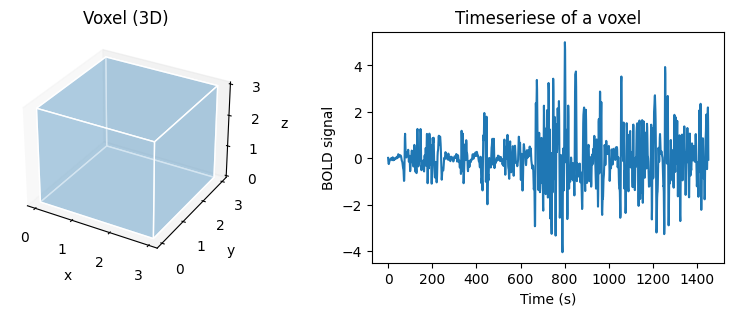

In [49]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from matplotlib import colormaps, colors

from nilearn import datasets, maskers, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from torch.utils.data import DataLoader, TensorDataset, Subset

# Device selection: DirectML or fallback to CUDA/CPU
#DEVICE = torch_directml.device() if torch_directml.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")




Using device: cuda


In [6]:
# Functions

def fetch_func_files(wdir, file_suffix='_bold.nii.gz'):
    # Construct the search pattern using the file suffix
    pattern = f'**/*{file_suffix}'
    
    # Convert wdir to a Path object if it's not already one
    wdir = Path(wdir)
    
    # Use glob to find and sort the files matching the pattern
    func_files = sorted(glob(str(wdir / pattern), recursive=True))
    
    # Print the number of files found
    print(f"Number of functional files with suffix '{file_suffix}': {len(func_files)}")
    
    # Return the list of functional file paths
    return func_files
# data = fetch_func_files(wdir, file_suffix='_bold.nii.gz' )

def fetch_dss_files(wdir, task_name='rest'):
    # Construct the search pattern based on the task name
    pattern = f'**/sub-*/func/*task-{task_name}_bold.nii.gz'

    
    # Convert wdir to a Path object if it's not already one
    wdir = Path(wdir)
    
    # Use glob to find and sort the files matching the pattern
    func_files = sorted(glob(str(wdir / pattern), recursive=True))
    
    # Print the number of files found
    print(f"Number of '{task_name}' functional files: {len(func_files)}")
    
    # Return the list of functional file paths
    return func_files
# data_func = fetch_dss_files(wdir, task_name='rest')

def load_json_file(file_name, data_dir):

    data_dir = Path(data_dir)
    file_path = data_dir / file_name
    
    # Check if the file exists
    if not file_path.exists():
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Read the JSON file
    with file_path.open('r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(data, indent=4))
    
    return data
# df_description = load_json_file("dataset_description.json", data_dir=wdir)


In [7]:
# Shortcuts

#dataset = datasets.fetch_adhd(n_subjects=None, data_dir=None, url=None, resume=True, verbose=1)

#dataset = datasets.fetch_openneuro_dataset(urls=None, data_dir=None, dataset_version='ds000030_R1.0.5', verbose=1)[source]

#dataset = datasets.fetch_abide_pcp(n_subjects=None, data_dir=None, url=None)

#dataset = datasets.fetch_development_fmri()

#pheno = pd.DataFrame(dataset.phenotypic)

#print('Keys:',list(data.keys()))
#print('Number of subjects:', len(data.func))
#print('Description:',data.description)

#---------------------------------------------


#wdir = r'C:\Users\lacom\nilearn_data\development_fmri\development_fmri'

#data_func = sorted(glob(os.path.join(wdir,'*.gz')))
#confounds = sorted(glob(os.path.join(wdir,'*desc-confounds_regressors.tsv')))

#print ('Func Data:',len(data))
#print ('Confounds:',len(confounds))

#pheno_path = os.path.join(wdir, 'participants.tsv')
#pheno = pd.read_csv(pheno_path, sep='\t').sort_values('participant_id')
#pheno.head()

## Load the data

In [8]:
dataset = datasets.fetch_development_fmri()

print('Keys:',list(dataset.keys()))
print('Number of subjects:', len(dataset.func))


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/development_fmri


Added README.md to /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Keys: ['func', 'confounds', 'phenotypic', 'description']
Number of subjects: 155


In [9]:
data = dataset.func

In [10]:
fmri_filenames = data[5]
print(fmri_filenames)

/root/nilearn_data/development_fmri/development_fmri/sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


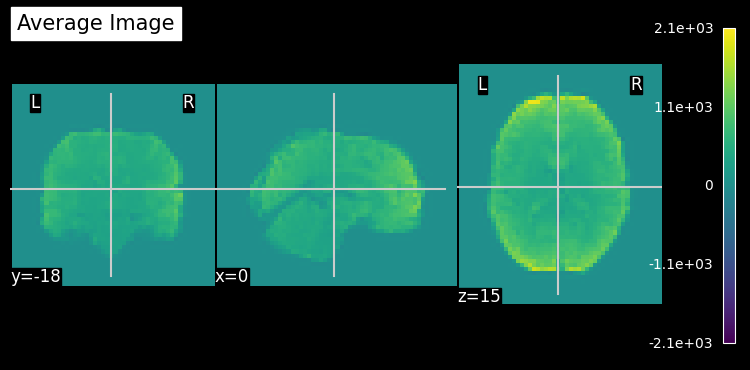

In [11]:
from nilearn import image 
averaged_Img = image.mean_img(image.mean_img(fmri_filenames))
plotting.plot_stat_map(averaged_Img,title='Average Image', cmap='viridis',threshold=0.1, dim=-2, colorbar=True,black_bg=True)

In [12]:
confounds = dataset.confounds
conf = confounds[5]
conf_df = pd.read_table(conf)
conf_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,framewise_displacement,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,csf,white_matter
0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,525.521464,473.476960
1,0.002290,0.039488,-0.000004,0.000000,0.000190,0.0,0.051301,-0.009419,0.064324,-0.046474,0.006744,-0.007179,0.025285,529.577966,476.734232
2,-0.000011,-0.104030,-0.009560,0.000164,0.000366,0.0,0.172322,-0.013124,0.010970,0.072557,0.030795,0.015773,-0.063280,531.250261,476.517911
3,-0.000031,0.169104,0.013041,-0.000843,0.000453,0.0,0.350465,0.033150,0.025784,0.036211,0.005530,0.048968,-0.025824,531.240585,476.460569
4,-0.000061,-0.145348,-0.025025,0.000060,0.000386,0.0,0.401084,-0.035600,-0.035397,-0.127860,0.001092,-0.031902,0.048258,531.931781,476.174483


### Explore the Target Variable (Y)

In [13]:
pheno = pd.DataFrame(dataset.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [14]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(pheno.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',pheno.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(pheno.dtypes.value_counts())

# Check for missing values
missing_columns = pheno.columns[pheno.isnull().any()]
if missing_columns.size > 0:
    missing_values = pheno[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(pheno)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(155, 6)

Duplicate Values:
( 0 )

Data Types:
object     5
float64    1
Name: count, dtype: int64

No Missing Values Found


In [15]:
pheno.columns

Index(['participant_id', 'Age', 'AgeGroup', 'Child_Adult', 'Gender',
       'Handedness'],
      dtype='object')

In [16]:
pheno[['participant_id', 'Age', 'Gender']].sample(10)

,participant_id,Age,Gender
37,sub-pixar005,4.837782,F
6,sub-pixar129,23.000000,F
30,sub-pixar153,30.000000,M
9,sub-pixar132,22.000000,F
83,sub-pixar051,5.380000,M
52,sub-pixar020,3.594798,M
142,sub-pixar110,10.780000,F
61,sub-pixar029,4.309377,M
27,sub-pixar150,19.000000,F
108,sub-pixar076,7.060000,M


In [17]:
print('Number of classes:',pheno['Child_Adult'].value_counts())

Number of classes: Child_Adult
child    122
adult     33
Name: count, dtype: int64


Number of classes: ['F' 'M']
Gender
F    84
M    71
Name: count, dtype: int64


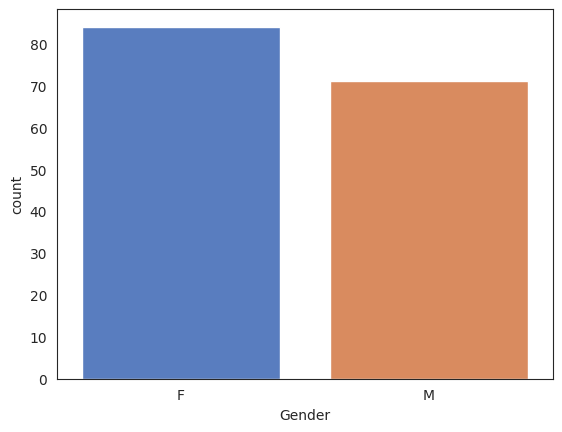

In [18]:
sex = pheno['Gender']

print('Number of classes:',sex.unique())

sns.set_style("white")
sns.set_palette("muted")
sns.countplot(x= sex)

print(sex.value_counts())

**AGE DISTRIBUTION**

Asymmetry: 1.544492
Kurtosis: 1.425876


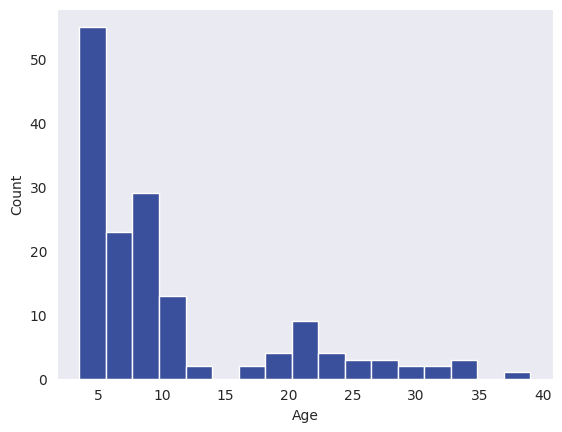

In [19]:
age = pheno['Age']

sns.set_style("dark")
sns.set_palette("dark")
sns.histplot(age)

#skewness and kurtosis
print("Asymmetry: %f" % age.skew())
print("Kurtosis: %f" % age.kurt())

In [20]:
# Group by column
diagnosis = pheno.groupby('Child_Adult')

# Calculate descriptive statistics
diagnosis['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Child_Adult,,,,,,,,
adult,33.0,24.772727,5.308521,18.000000,21.00000,23.00,28.0000,39.0
child,122.0,6.709461,2.330938,3.518138,4.89521,5.98,8.3975,12.3


### Probabilistic Atlas
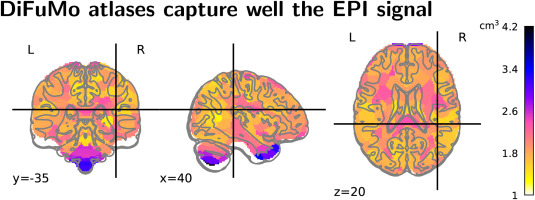

In [21]:
dim = 64
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=2, legacy_format=False
)

atlas_filename = difumo.maps





Dataset created in /root/nilearn_data/difumo_atlases



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/difumo_atlases/0fd53859aa9fed124e741c85ec45c705/download..... done.


 ...done. (2 seconds, 0 min)


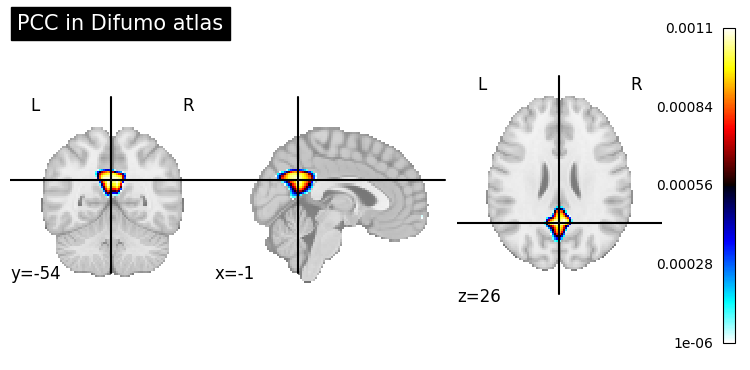

In [22]:
from nilearn import image, plotting

# First plot the map for the PCC: index 3 in the atlas
display = plotting.plot_stat_map(
    image.index_img(atlas_filename, 3),
    colorbar=True,
    title="PCC in Difumo atlas",
)

plotting.show()

In [23]:
difumo.labels

,component,difumo_names,yeo_networks7,yeo_networks17,gm,wm,csf
0,1,Superior frontal sulcus,DefaultB,DefaultA,0.689996,0.185709,0.116884
1,2,Fusiform gyrus,No network found,No network found,0.844733,0.021026,0.133789
2,3,Calcarine cortex posterior,VisCent,VisPeri,0.601768,0.302067,0.091297
3,4,Cingulate cortex posterior,DefaultB,DefaultA,0.740086,0.140368,0.119567
4,5,Parieto-occipital sulcus superior,ContA,ContC,0.640157,0.241492,0.117826
...,...,...,...,...,...,...,...
59,60,Cuneus,VisCent,VisPeri,0.627179,0.269783,0.103005
60,61,Middle temporal gyrus,DefaultB,DefaultB,0.726527,0.149595,0.107329
61,62,Superior frontal gyrus,DefaultB,DefaultB,0.651182,0.062243,0.224067
62,63,Central sulcus,SomMotA,SomMotB,0.578502,0.291674,0.109244


### Extract features with nilearn masker

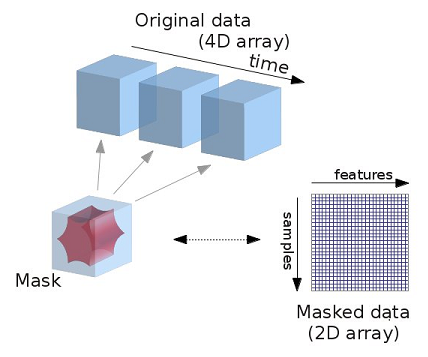 

Compute a correlation matrix, representing regional coactivation between regions and extract signals from a brain parcellation 


In [24]:
from nilearn.maskers import MultiNiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

# create masker using MultiNiftiMapsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# # computation
masker = MultiNiftiMapsMasker(
    maps_img=atlas_filename,
    standardize='zscore_sample',
    standardize_confounds='zscore_sample',
    memory='nilearn_cache',
    n_jobs=2, verbose=0
)

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(
    kind='correlation', vectorize=True, discard_diagonal=True)




In [25]:
# METHOD 2

# extract time series from all subjects
#time_series = masker.fit_transform(data, confounds=data_confounds)

# calculate correlation matrices across subjects and display
#correlation_matrices = connectome_measure.fit_transform(time_series)

In [26]:
data[:4]

['/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/root/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/root/nilearn_data/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/root/nilearn_data/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

**Extract fMRI connectivity features from every subject.**



In [27]:
# all_features = [connectome_measure.fit_transform([masker.fit_transform(sub, confounds=confounds[i])])[0] for i, sub in enumerate(data)]

In [28]:
# Let's save the data to disk

# np.savez_compressed('Age_Regressor_featuress.npz',a = all_features)

In [31]:
# Load the features 

feat_file = '/kaggle/input/features/Age_Regressor_featuress.npz'
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)


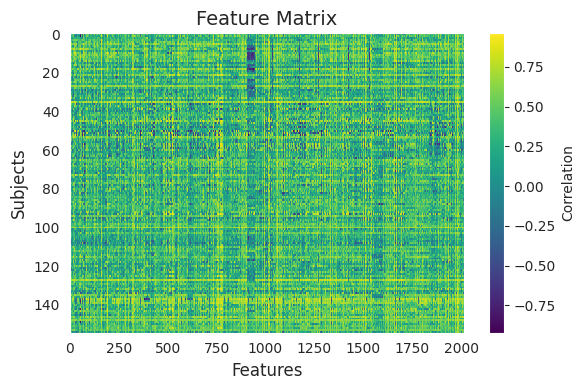

In [32]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.imshow(X_features, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(label='Correlation')

# Add title and labels
plt.title('Feature Matrix', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Subjects', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Prepare data for machine learning

In [33]:
# Select features and target
X = X_features
y = pheno['Age'].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [34]:
# Constants
TEST_SIZE = 0.2  # Example test size
RANDOM_STATE = 42  # Example random state
BATCH_SIZE = 32  # Example batch size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

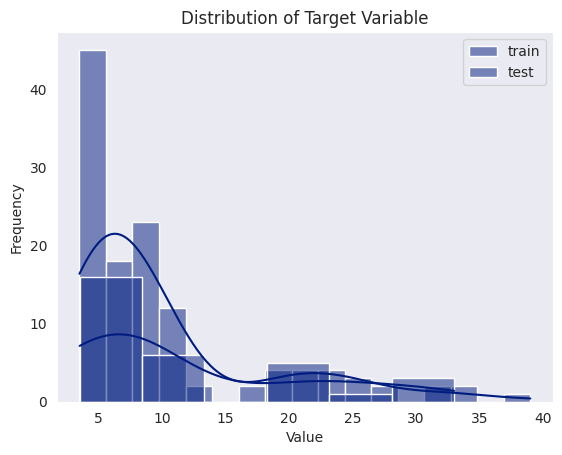

training: 124 testing: 31


In [35]:
# Check data distribution
sns.histplot(y_train, label='train', kde=True)
sns.histplot(y_test, label='test', kde=True)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

# Print the size of the training and test sets
print('training:', len(X_train), 'testing:', len(X_test))


## **Non-Linear Model**

In [36]:
# Assuming you have labels from difumo
labels = difumo.labels["difumo_names"]

# Generate feature names and indices
feature_names = [f'{labels[i]} - {labels[j]}' for i in range(64) for j in range(i + 1, 64)]
feature_indices = list(range(1, len(feature_names) + 1))

# Create a DataFrame
feature_mapping_df = pd.DataFrame({
    'Feature Index': feature_indices,
    'Feature Name': feature_names
})

# Display a sample of the feature mapping DataFrame
feature_mapping_df.head(5)

,Feature Index,Feature Name
0,1,Superior frontal sulcus - Fusiform gyrus
1,2,Superior frontal sulcus - Calcarine cortex pos...
2,3,Superior frontal sulcus - Cingulate cortex pos...
3,4,Superior frontal sulcus - Parieto-occipital su...
4,5,Superior frontal sulcus - Insula antero-superior


In [37]:
# Model Definition
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        super(RegressionModel, self).__init__()
        layers = []
        last_dim = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim
            
        layers.append(nn.Linear(last_dim, 1))  # Single output for regression
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Hyperparameter Optimization Function
def objective(trial):
    # Suggest hyperparameters
    hidden_layers_options = [
        (256, 128),  # Converted to tuples
        (512, 256, 128),  # Converted to tuples
        (512, 256)  # Converted to tuples
    ]
    hidden_layers = trial.suggest_categorical('hidden_layers', hidden_layers_options)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Model and optimizer
    model = RegressionModel(input_dim=X_train.shape[1], hidden_layers=hidden_layers, dropout_rate=dropout_rate).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS_OPTUNA)
    
    # Training loop
    best_loss = float('inf')
    no_improvement = 0
    patience = 10

    for epoch in range(MAX_EPOCHS_OPTUNA):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(inputs.to(DEVICE)), labels.to(DEVICE)).item() for inputs, labels in test_loader) / len(test_loader)
        
        scheduler.step()
        
        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return val_loss

# Create study and optimize
MAX_EPOCHS_OPTUNA = 1000  # Example maximum number of epochs
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, n_jobs=4)

# Best model parameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")



[I 2024-09-15 14:38:39,489] A new study created in memory with name: no-name-c3431dbb-c6d2-4a11-af1c-0df785f56d59
[I 2024-09-15 14:38:42,678] Trial 0 finished with value: 16.407094955444336 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2876294562477651, 'lr': 0.006775045483379638, 'weight_decay': 1.6660424513525713e-06}. Best is trial 0 with value: 16.407094955444336.


Early stopping at epoch 23


[I 2024-09-15 14:38:44,292] Trial 1 finished with value: 12.998926162719727 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.46486643246508896, 'lr': 0.0017842186445507233, 'weight_decay': 4.423472766291811e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 54


[I 2024-09-15 14:38:45,059] Trial 2 finished with value: 28.54349136352539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4732225690814231, 'lr': 0.0005479603016640377, 'weight_decay': 1.2830523188624003e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 79


[I 2024-09-15 14:38:46,126] Trial 6 finished with value: 27.138513565063477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.49199547676804595, 'lr': 0.007336585679599792, 'weight_decay': 8.908297945252542e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 20


[I 2024-09-15 14:38:47,203] Trial 3 finished with value: 176.16134643554688 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.24323337878765008, 'lr': 1.234917812639524e-05, 'weight_decay': 2.1399546494774167e-05}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 115


[I 2024-09-15 14:38:50,720] Trial 8 finished with value: 23.954364776611328 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.25155570976986213, 'lr': 0.0006501944449848985, 'weight_decay': 4.469831695530677e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 68


[I 2024-09-15 14:38:51,682] Trial 4 finished with value: 88.7338638305664 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.4948255040210187, 'lr': 4.831405137967228e-05, 'weight_decay': 5.338170062356386e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 148


[I 2024-09-15 14:38:54,961] Trial 5 finished with value: 162.4256591796875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3306064985888887, 'lr': 1.2226901254511164e-05, 'weight_decay': 2.0159145246099952e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 197


[I 2024-09-15 14:38:55,402] Trial 7 finished with value: 145.3730010986328 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.38712341199260325, 'lr': 3.0280997320930377e-05, 'weight_decay': 9.92461531249279e-05}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 166


[I 2024-09-15 14:38:55,794] Trial 10 finished with value: 17.505115509033203 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.4348696653923199, 'lr': 0.0006118949381853918, 'weight_decay': 3.240564927715806e-05}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 68


[I 2024-09-15 14:38:58,169] Trial 13 finished with value: 22.495542526245117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.39752874901975266, 'lr': 0.0025324940346316284, 'weight_decay': 0.0006247928384826662}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 39


[I 2024-09-15 14:38:58,603] Trial 9 finished with value: 140.30416870117188 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.42749341836127586, 'lr': 1.4933257684160123e-05, 'weight_decay': 4.987614242713599e-05}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 176


[I 2024-09-15 14:38:59,260] Trial 14 finished with value: 13.391815185546875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3093390577563513, 'lr': 0.009335777849078863, 'weight_decay': 1.1418464203238978e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 17


[I 2024-09-15 14:38:59,516] Trial 15 finished with value: 23.498775482177734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3150551455047419, 'lr': 0.00877034339024056, 'weight_decay': 1.1154564946185571e-06}. Best is trial 1 with value: 12.998926162719727.


Early stopping at epoch 19


[I 2024-09-15 14:39:01,306] Trial 16 finished with value: 16.209444046020508 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3262118910481719, 'lr': 0.0022059560992655955, 'weight_decay': 1.0156951220479014e-06}. Best is trial 1 with value: 12.998926162719727.
[I 2024-09-15 14:39:01,364] Trial 17 finished with value: 12.527835845947266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36795973942851135, 'lr': 0.0019324216032913456, 'weight_decay': 1.2860704922388105e-05}. Best is trial 17 with value: 12.527835845947266.


Early stopping at epoch 33
Early stopping at epoch 39


[I 2024-09-15 14:39:02,408] Trial 11 finished with value: 38.843223571777344 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3732677653578456, 'lr': 0.00011245637135745331, 'weight_decay': 1.2081489981023497e-06}. Best is trial 17 with value: 12.527835845947266.


Early stopping at epoch 136


[I 2024-09-15 14:39:03,153] Trial 12 finished with value: 165.1318817138672 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2991973109122533, 'lr': 2.1559385867671296e-05, 'weight_decay': 0.0007307157418253652}. Best is trial 17 with value: 12.527835845947266.


Early stopping at epoch 132


[I 2024-09-15 14:39:03,448] Trial 18 finished with value: 15.822246551513672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2150471777394502, 'lr': 0.0024794806039414386, 'weight_decay': 1.0694511234112601e-05}. Best is trial 17 with value: 12.527835845947266.
[I 2024-09-15 14:39:03,597] Trial 19 finished with value: 10.21178150177002 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.201098457999658, 'lr': 0.0017524051349421064, 'weight_decay': 1.6168522895461957e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 33
Early stopping at epoch 49


[I 2024-09-15 14:39:04,933] Trial 21 finished with value: 16.750131607055664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4361912052158137, 'lr': 0.002221648186449118, 'weight_decay': 1.378594113233625e-05}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:05,129] Trial 20 finished with value: 14.493921279907227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.439285469779318, 'lr': 0.0018561114346831516, 'weight_decay': 1.149942830782877e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 36
Early stopping at epoch 49


[I 2024-09-15 14:39:06,959] Trial 25 finished with value: 27.262794494628906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3624471723113178, 'lr': 0.0010806554430782124, 'weight_decay': 8.119262231944601e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 34


[I 2024-09-15 14:39:07,466] Trial 23 finished with value: 65.86514282226562 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3591973424966367, 'lr': 0.00025997887431351645, 'weight_decay': 0.0001527685056869084}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 83
Early stopping at epoch 54


[I 2024-09-15 14:39:07,667] Trial 24 finished with value: 18.8885440826416 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36465943292850117, 'lr': 0.0010148078823634633, 'weight_decay': 4.07326362477004e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:09,235] Trial 22 finished with value: 86.3745346069336 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4384481706102137, 'lr': 0.00017983026328591864, 'weight_decay': 0.0001817431572360781}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:09,369] Trial 27 finished with value: 17.38382339477539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2724917296230285, 'lr': 0.004331591289672501, 'weight_decay': 3.5268673735237495e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 91
Early stopping at epoch 38


[I 2024-09-15 14:39:09,714] Trial 26 finished with value: 109.9879150390625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20548338501000513, 'lr': 0.00021326061909666865, 'weight_decay': 3.467531309766774e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 47


[I 2024-09-15 14:39:10,336] Trial 28 finished with value: 97.30670928955078 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4056756976192216, 'lr': 0.00026817133318262287, 'weight_decay': 2.301479358634072e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 50


[I 2024-09-15 14:39:10,647] Trial 30 finished with value: 18.25800132751465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20332723238272765, 'lr': 0.004201727883249828, 'weight_decay': 1.8138195022260027e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 25


[I 2024-09-15 14:39:11,554] Trial 32 finished with value: 19.17172622680664 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.4743743954770727, 'lr': 0.004115072813556331, 'weight_decay': 7.614393570383625e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 24


[I 2024-09-15 14:39:12,821] Trial 31 finished with value: 23.34384536743164 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.40254849218095445, 'lr': 0.00412001348297965, 'weight_decay': 2.9489452350578763e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 48


[I 2024-09-15 14:39:13,845] Trial 29 finished with value: 13.838728904724121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2011601728359205, 'lr': 0.0011762679312415929, 'weight_decay': 2.2510824980444204e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 71


[I 2024-09-15 14:39:14,257] Trial 34 finished with value: 11.591577529907227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2765974929670484, 'lr': 0.0011388016547397698, 'weight_decay': 2.468594079804135e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 54


[I 2024-09-15 14:39:14,635] Trial 33 finished with value: 17.556779861450195 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.4586046472714669, 'lr': 0.0012034424040007255, 'weight_decay': 6.045596487206459e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 73


[I 2024-09-15 14:39:15,582] Trial 35 finished with value: 15.165229797363281 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2830724564605895, 'lr': 0.0012700080974239743, 'weight_decay': 2.13451492232287e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 50


[I 2024-09-15 14:39:17,884] Trial 37 finished with value: 42.67413330078125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27688496680959135, 'lr': 0.00045332677047165484, 'weight_decay': 2.159210451474348e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 74


[I 2024-09-15 14:39:19,691] Trial 38 finished with value: 21.185495376586914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26679616143244356, 'lr': 0.0004512106743552569, 'weight_decay': 2.9055752765976506e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 109


[I 2024-09-15 14:39:20,740] Trial 39 finished with value: 17.56761932373047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23418077015666514, 'lr': 0.0005385479217087984, 'weight_decay': 2.481761251360016e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:20,919] Trial 36 finished with value: 25.68670082092285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2738587872672341, 'lr': 0.00043401257105580627, 'weight_decay': 7.023307731458199e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 95
Early stopping at epoch 114


[I 2024-09-15 14:39:22,364] Trial 40 finished with value: 34.21025085449219 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23371538572141742, 'lr': 0.0004156293765680691, 'weight_decay': 2.7509120574655935e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 90


[I 2024-09-15 14:39:23,414] Trial 44 finished with value: 21.6851749420166 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34019967028296605, 'lr': 0.00603059431817779, 'weight_decay': 1.4945057465268138e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:23,480] Trial 42 finished with value: 19.558942794799805 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2254960480415834, 'lr': 0.0008074747141564099, 'weight_decay': 6.705906909734483e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:23,603] Trial 41 finished with value: 14.319920539855957 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23240943092137167, 'lr': 0.0007622618337765447, 'weight_decay': 1.53631205835605e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 21
Early stopping at epoch 49
Early stopping at epoch 80


[I 2024-09-15 14:39:24,126] Trial 43 finished with value: 13.54533863067627 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.34099360975433507, 'lr': 0.0007671024823280275, 'weight_decay': 1.51160350550148e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 50


[I 2024-09-15 14:39:24,743] Trial 47 finished with value: 30.99635887145996 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.3029471215309788, 'lr': 0.00645150031046895, 'weight_decay': 5.3158661332827016e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:24,778] Trial 46 finished with value: 12.389007568359375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.30170515064627645, 'lr': 0.0058982975184487625, 'weight_decay': 1.7942401290375385e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 19
Early stopping at epoch 22


[I 2024-09-15 14:39:25,510] Trial 45 finished with value: 16.709117889404297 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3010188964893671, 'lr': 0.0015444697193194496, 'weight_decay': 1.7286325334471292e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 38


[I 2024-09-15 14:39:26,777] Trial 48 finished with value: 19.61315155029297 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.3006472416887759, 'lr': 0.0016241041636405808, 'weight_decay': 1.6369721026955697e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:26,911] Trial 51 finished with value: 15.450763702392578 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2579916825928518, 'lr': 0.003112385480970224, 'weight_decay': 5.699296780991076e-05}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:26,950] Trial 49 finished with value: 12.815427780151367 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25436139781220846, 'lr': 0.0016961331584317977, 'weight_decay': 1.461504533144187e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 33
Early stopping at epoch 28
Early stopping at epoch 45


[I 2024-09-15 14:39:27,168] Trial 50 finished with value: 18.25794219970703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24839815283156896, 'lr': 0.0017098579712154331, 'weight_decay': 1.7738950473697472e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 42


[I 2024-09-15 14:39:28,277] Trial 54 finished with value: 16.051136016845703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25103560018967264, 'lr': 0.0029787996059853802, 'weight_decay': 8.845374698049781e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 27


[I 2024-09-15 14:39:28,512] Trial 53 finished with value: 20.143869400024414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.38381787648859134, 'lr': 0.003108977946065763, 'weight_decay': 9.756295565346033e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 30


[I 2024-09-15 14:39:28,743] Trial 55 finished with value: 15.699834823608398 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2900183348261743, 'lr': 0.003042885396329073, 'weight_decay': 8.80179711053635e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 28


[I 2024-09-15 14:39:29,809] Trial 57 finished with value: 14.014907836914062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3242231470217701, 'lr': 0.00497596136113606, 'weight_decay': 4.703638741736799e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 25


[I 2024-09-15 14:39:30,573] Trial 56 finished with value: 24.97779083251953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.32254976445854944, 'lr': 0.0030969308292303393, 'weight_decay': 3.082502936858502e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 46


[I 2024-09-15 14:39:31,370] Trial 59 finished with value: 17.81241226196289 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26268002167868404, 'lr': 0.0023201103044738136, 'weight_decay': 1.417519801456669e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 30


[I 2024-09-15 14:39:32,011] Trial 58 finished with value: 145.51947021484375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3217220975758438, 'lr': 5.158797813800435e-05, 'weight_decay': 4.649178569512344e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 59


[I 2024-09-15 14:39:34,414] Trial 62 finished with value: 15.61251449584961 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4977133621532532, 'lr': 0.0017468641217731045, 'weight_decay': 3.437241055622303e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 46
Early stopping at epoch 121


[I 2024-09-15 14:39:34,615] Trial 52 finished with value: 111.65413665771484 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2489590031750205, 'lr': 7.546331836237346e-05, 'weight_decay': 5.337597228362221e-05}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:34,618] Trial 60 finished with value: 116.7077407836914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4960324491683228, 'lr': 0.00012694527237745246, 'weight_decay': 4.1720366532680486e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 84


[I 2024-09-15 14:39:35,532] Trial 65 finished with value: 13.140670776367188 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2850367221345652, 'lr': 0.006889273981557231, 'weight_decay': 2.251776083738438e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:35,547] Trial 63 finished with value: 24.715906143188477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2869841655581562, 'lr': 0.008140528642350507, 'weight_decay': 1.2665448533228094e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:35,694] Trial 64 finished with value: 23.154863357543945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.311818445131153, 'lr': 0.007182644846179764, 'weight_decay': 1.0759578674950436e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 18
Early stopping at epoch 19
Early stopping at epoch 15


[I 2024-09-15 14:39:36,415] Trial 66 finished with value: 13.663028717041016 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2896908804055211, 'lr': 0.009776925134918582, 'weight_decay': 2.4630759162419597e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 17


[I 2024-09-15 14:39:36,712] Trial 68 finished with value: 29.043212890625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.411580767571406, 'lr': 0.009447724779671223, 'weight_decay': 2.145239242318104e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 15


[I 2024-09-15 14:39:37,505] Trial 69 finished with value: 22.94561195373535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.42245083611989404, 'lr': 0.005357799189135194, 'weight_decay': 2.017122281014906e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 22


[I 2024-09-15 14:39:37,758] Trial 61 finished with value: 103.24259185791016 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.41849313028358587, 'lr': 8.128328601924604e-05, 'weight_decay': 3.153377655149368e-05}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:37,810] Trial 70 finished with value: 14.3121919631958 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21953848600689108, 'lr': 0.005470896641734094, 'weight_decay': 3.5684314180917894e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 124
Early stopping at epoch 16


[I 2024-09-15 14:39:40,067] Trial 72 finished with value: 22.336923599243164 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.21834346506775026, 'lr': 0.002080089983332314, 'weight_decay': 1.1707071289435624e-05}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:40,253] Trial 67 finished with value: 13.511777877807617 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2180527674764349, 'lr': 0.0009262627793905255, 'weight_decay': 2.325591727865216e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 41
Early stopping at epoch 86


[I 2024-09-15 14:39:41,307] Trial 75 finished with value: 15.642524719238281 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3104857336485357, 'lr': 0.007269860812652316, 'weight_decay': 1.1374925385820513e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 17


[I 2024-09-15 14:39:41,660] Trial 71 finished with value: 15.76229476928711 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2135057962941799, 'lr': 0.001358502864898785, 'weight_decay': 3.565722099938509e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 74


[I 2024-09-15 14:39:42,622] Trial 74 finished with value: 15.443561553955078 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3126520563062297, 'lr': 0.0014281018243834888, 'weight_decay': 1.245885646783464e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 47


[I 2024-09-15 14:39:43,016] Trial 77 finished with value: 24.35602378845215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4731559201071385, 'lr': 0.004553102601918666, 'weight_decay': 0.0004070122043037878}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 27


[I 2024-09-15 14:39:43,322] Trial 73 finished with value: 16.59023094177246 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.4761914546252421, 'lr': 0.0009017722038693593, 'weight_decay': 1.1751335065590989e-05}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 73


[I 2024-09-15 14:39:44,007] Trial 79 finished with value: 17.712846755981445 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3367820677526576, 'lr': 0.003750938172298708, 'weight_decay': 1.5833902509021798e-06}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:44,144] Trial 78 finished with value: 15.036490440368652 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33558137953528605, 'lr': 0.0039037505276180986, 'weight_decay': 0.00031772895917701324}. Best is trial 19 with value: 10.21178150177002.
[I 2024-09-15 14:39:44,181] Trial 76 finished with value: 15.110273361206055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35011312090828134, 'lr': 0.0013791521605905216, 'weight_decay': 1.4664534418112804e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 20
Early stopping at epoch 29
Early stopping at epoch 49


[I 2024-09-15 14:39:44,678] Trial 80 finished with value: 22.85565757751465 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.33476578959108766, 'lr': 0.0036611518712494494, 'weight_decay': 1.805413892580509e-06}. Best is trial 19 with value: 10.21178150177002.


Early stopping at epoch 20


[I 2024-09-15 14:39:45,912] Trial 83 finished with value: 9.992631912231445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2788261097020721, 'lr': 0.0021120289223768647, 'weight_decay': 1.8688878287339563e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:39:46,030] Trial 81 finished with value: 13.025496482849121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35492500739132793, 'lr': 0.0025308091728410364, 'weight_decay': 2.8761187746713435e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 31
Early stopping at epoch 40


[I 2024-09-15 14:39:46,281] Trial 82 finished with value: 12.453794479370117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35396888489817424, 'lr': 0.0020205032957372276, 'weight_decay': 1.01461213309896e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 41


[I 2024-09-15 14:39:47,745] Trial 86 finished with value: 26.70885467529297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3760407859726478, 'lr': 0.0019924614253987545, 'weight_decay': 3.0574714989414243e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 36


[I 2024-09-15 14:39:47,986] Trial 87 finished with value: 18.9251766204834 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3737990653790606, 'lr': 0.002129893378556879, 'weight_decay': 2.794659207023435e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 35


[I 2024-09-15 14:39:48,614] Trial 84 finished with value: 12.40907096862793 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24176819237568214, 'lr': 0.0019150526653817818, 'weight_decay': 2.5298193974434974e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 61


[I 2024-09-15 14:39:48,857] Trial 85 finished with value: 12.3878812789917 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2826969582665236, 'lr': 0.0020822315879641643, 'weight_decay': 1.0223877879030638e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 52


[I 2024-09-15 14:39:49,319] Trial 88 finished with value: 16.54334831237793 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3527892059157122, 'lr': 0.002237966301696326, 'weight_decay': 2.662679497484359e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 31


[I 2024-09-15 14:39:49,763] Trial 89 finished with value: 16.71831703186035 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3474423589695433, 'lr': 0.00256375105748823, 'weight_decay': 1.044974009927786e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 34


[I 2024-09-15 14:39:51,862] Trial 92 finished with value: 23.147247314453125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23982249399533043, 'lr': 0.0011316460202234974, 'weight_decay': 1.0577358471472899e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:39:52,053] Trial 90 finished with value: 31.29173469543457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24150056393956662, 'lr': 0.0006484427149094891, 'weight_decay': 1.8564756292699498e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 55
Early stopping at epoch 53


[I 2024-09-15 14:39:52,160] Trial 91 finished with value: 19.060569763183594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24157745599455116, 'lr': 0.0011059776937756558, 'weight_decay': 1.0003832738134671e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 61


[I 2024-09-15 14:39:53,169] Trial 93 finished with value: 10.353439331054688 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2593045549176526, 'lr': 0.0011153488041685568, 'weight_decay': 1.0013801611423763e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 70


[I 2024-09-15 14:39:53,918] Trial 94 finished with value: 10.836870193481445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2667881739322323, 'lr': 0.0018017746429561192, 'weight_decay': 1.3858888045165567e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:39:54,704] Trial 96 finished with value: 24.730791091918945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26935040132866, 'lr': 0.0018262642980659853, 'weight_decay': 1.862521410138214e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:39:54,888] Trial 95 finished with value: 12.939035415649414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27736716943563705, 'lr': 0.001746351538616437, 'weight_decay': 1.3462916181094608e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47
Early stopping at epoch 45


[I 2024-09-15 14:39:54,981] Trial 97 finished with value: 12.599347114562988 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2570567469672405, 'lr': 0.0018273483709556027, 'weight_decay': 1.4404492755747984e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 35


[I 2024-09-15 14:39:55,992] Trial 98 finished with value: 15.797996520996094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26932006967377553, 'lr': 0.0026534477418221247, 'weight_decay': 1.3452158994938583e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:39:56,916] Trial 101 finished with value: 16.791471481323242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26108148561182637, 'lr': 0.002698989320718183, 'weight_decay': 2.5897576556093835e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39


[I 2024-09-15 14:39:58,422] Trial 100 finished with value: 23.07651710510254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2945386015032465, 'lr': 0.0009975287179973724, 'weight_decay': 1.2244491219446851e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56


[I 2024-09-15 14:39:58,989] Trial 103 finished with value: 25.575613021850586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2971709640083527, 'lr': 0.0009148233411784468, 'weight_decay': 1.9258774953314324e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:39:59,280] Trial 102 finished with value: 12.688562393188477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2805651613074565, 'lr': 0.0009169414063640341, 'weight_decay': 4.0077804494633436e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:39:59,414] Trial 99 finished with value: 28.567306518554688 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27858668195312325, 'lr': 0.000548493755071709, 'weight_decay': 1.4191400397289675e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 69
Early stopping at epoch 84


[I 2024-09-15 14:40:00,934] Trial 104 finished with value: 22.324859619140625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2798444031811088, 'lr': 0.0014717575763665547, 'weight_decay': 1.7001395619222546e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:00,984] Trial 106 finished with value: 18.074384689331055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3672459615756603, 'lr': 0.0015145725457621148, 'weight_decay': 1.7376057035161915e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 40
Early stopping at epoch 35


[I 2024-09-15 14:40:01,567] Trial 107 finished with value: 10.124180793762207 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22793068153635704, 'lr': 0.0015815012253723728, 'weight_decay': 1.6079168122101903e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 40


[I 2024-09-15 14:40:03,251] Trial 105 finished with value: 18.16282081604004 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27931731170750723, 'lr': 0.0005649777886670681, 'weight_decay': 1.5884349511144614e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 86


[I 2024-09-15 14:40:03,646] Trial 110 finished with value: 10.68346881866455 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2094366290889436, 'lr': 0.003391511367720862, 'weight_decay': 1.2167485437838565e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 37


[I 2024-09-15 14:40:04,015] Trial 108 finished with value: 16.254579544067383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25418955473965643, 'lr': 0.001280939483539499, 'weight_decay': 1.6632264609617528e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 49


[I 2024-09-15 14:40:04,437] Trial 111 finished with value: 21.084842681884766 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.20740973670570698, 'lr': 0.003282488024708626, 'weight_decay': 1.160248046516576e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 23


[I 2024-09-15 14:40:05,081] Trial 109 finished with value: 11.689949035644531 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25525207727821264, 'lr': 0.0012447975649429572, 'weight_decay': 1.197225508525991e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 86


[I 2024-09-15 14:40:05,463] Trial 113 finished with value: 13.617303848266602 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22688749750662607, 'lr': 0.003300964805290454, 'weight_decay': 1.1593165564785874e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 22


[I 2024-09-15 14:40:06,006] Trial 112 finished with value: 14.99157428741455 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.20741381460666758, 'lr': 0.0012452760275786393, 'weight_decay': 1.1790152720737994e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 41


[I 2024-09-15 14:40:06,283] Trial 114 finished with value: 12.659761428833008 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21297457056593677, 'lr': 0.0022878207635761275, 'weight_decay': 2.087611123500207e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 36


[I 2024-09-15 14:40:07,907] Trial 117 finished with value: 13.96580982208252 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22710098335571674, 'lr': 0.0020496056386069437, 'weight_decay': 2.1116392634868543e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 35


[I 2024-09-15 14:40:08,414] Trial 118 finished with value: 12.298450469970703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2653135576139228, 'lr': 0.001515975310983596, 'weight_decay': 9.233095384503329e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44


[I 2024-09-15 14:40:08,657] Trial 116 finished with value: 15.697364807128906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2252480874826163, 'lr': 0.0012481565903577421, 'weight_decay': 2.0428172628878446e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 50


[I 2024-09-15 14:40:09,591] Trial 115 finished with value: 14.985258102416992 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22371318272376747, 'lr': 0.0007312636351662948, 'weight_decay': 1.2258310325710803e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 95


[I 2024-09-15 14:40:10,759] Trial 120 finished with value: 12.00605583190918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26411840673514664, 'lr': 0.0016049266556858034, 'weight_decay': 0.00011204453106015154}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47


[I 2024-09-15 14:40:11,878] Trial 119 finished with value: 20.08060646057129 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23522391187786246, 'lr': 0.0006949725335588217, 'weight_decay': 0.00012006597449701798}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:12,058] Trial 122 finished with value: 14.903714179992676 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26443068063340797, 'lr': 0.0015838078525291037, 'weight_decay': 0.00013264614581265776}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 72
Early stopping at epoch 52


[I 2024-09-15 14:40:13,345] Trial 123 finished with value: 18.227174758911133 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.264846270718812, 'lr': 0.0016537565283857851, 'weight_decay': 9.827122998049466e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 50


[I 2024-09-15 14:40:13,855] Trial 124 finished with value: 19.032833099365234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2634968105072591, 'lr': 0.0015766217890166888, 'weight_decay': 8.293397235949613e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 35


[I 2024-09-15 14:40:14,281] Trial 121 finished with value: 15.454000473022461 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26514928533689586, 'lr': 0.0007565259573822744, 'weight_decay': 0.00011328366095851503}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 90


[I 2024-09-15 14:40:14,908] Trial 125 finished with value: 16.324932098388672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25027209745562673, 'lr': 0.0010705832527597825, 'weight_decay': 6.433081378945665e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56


[I 2024-09-15 14:40:16,405] Trial 127 finished with value: 17.244455337524414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2469685498331096, 'lr': 0.0011456076022295042, 'weight_decay': 7.438756397270878e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47


[I 2024-09-15 14:40:16,635] Trial 129 finished with value: 18.238378524780273 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.24582968829965948, 'lr': 0.0027874665077039424, 'weight_decay': 7.617411752094227e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 31


[I 2024-09-15 14:40:17,673] Trial 128 finished with value: 15.139683723449707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24768090309792806, 'lr': 0.0010539140549027382, 'weight_decay': 0.0001677386433488988}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 55


[I 2024-09-15 14:40:18,258] Trial 130 finished with value: 20.80842399597168 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.27333998601028353, 'lr': 0.002801505924289317, 'weight_decay': 0.0001564427697058733}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 28


[I 2024-09-15 14:40:18,810] Trial 131 finished with value: 12.506634712219238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2000986202699268, 'lr': 0.0014017775780429537, 'weight_decay': 0.00021094398778008592}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 48


[I 2024-09-15 14:40:19,884] Trial 132 finished with value: 14.632820129394531 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27169168188125387, 'lr': 0.002402541444959103, 'weight_decay': 0.00023860060203784587}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 34


[I 2024-09-15 14:40:21,043] Trial 134 finished with value: 17.136167526245117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23561090336315746, 'lr': 0.0019971163460698804, 'weight_decay': 1.0223933200992999e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47


[I 2024-09-15 14:40:22,049] Trial 133 finished with value: 62.20793533325195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23616233919364976, 'lr': 0.00036319003646876263, 'weight_decay': 0.0002597145597418991}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 70


[I 2024-09-15 14:40:22,469] Trial 126 finished with value: 169.077392578125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24571304115378323, 'lr': 1.4843888155056034e-05, 'weight_decay': 7.127272039403749e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:22,589] Trial 135 finished with value: 15.34081745147705 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2874522222370478, 'lr': 0.0020319854437933207, 'weight_decay': 1.410623094895664e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 183
Early stopping at epoch 42


[I 2024-09-15 14:40:22,820] Trial 136 finished with value: 15.763200759887695 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.29091066023324885, 'lr': 0.0018917499465432534, 'weight_decay': 2.473773544107017e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 36


[I 2024-09-15 14:40:23,950] Trial 140 finished with value: 15.887425422668457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25700848819003436, 'lr': 0.003521160746419692, 'weight_decay': 1.3302114987883041e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 24


[I 2024-09-15 14:40:24,226] Trial 137 finished with value: 15.727433204650879 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.29097015043405133, 'lr': 0.0018704996441505238, 'weight_decay': 1.341409234796389e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 38


[I 2024-09-15 14:40:24,700] Trial 138 finished with value: 12.560376167297363 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25579506991690193, 'lr': 0.0019621744493759402, 'weight_decay': 2.431098607851644e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 43


[I 2024-09-15 14:40:25,456] Trial 139 finished with value: 14.31490707397461 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25540018775595597, 'lr': 0.00182289338568842, 'weight_decay': 2.5068552574815402e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:25,627] Trial 142 finished with value: 21.15041732788086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.30394993963530403, 'lr': 0.004779530921348211, 'weight_decay': 1.676116285971039e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44
Early stopping at epoch 24


[I 2024-09-15 14:40:25,879] Trial 141 finished with value: 17.359098434448242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2108823820116069, 'lr': 0.0013691632952981408, 'weight_decay': 1.5628950951922765e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 38


[I 2024-09-15 14:40:26,994] Trial 143 finished with value: 33.75521469116211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27087874066569945, 'lr': 0.0013707195401397962, 'weight_decay': 4.438310265839931e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46


[I 2024-09-15 14:40:28,018] Trial 146 finished with value: 14.692742347717285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20046084044071988, 'lr': 0.0013259299017813594, 'weight_decay': 4.783596749316374e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44


[I 2024-09-15 14:40:28,938] Trial 147 finished with value: 24.658954620361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2005600631956772, 'lr': 0.002392037306007749, 'weight_decay': 0.0006979359344295622}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:29,109] Trial 144 finished with value: 13.12391185760498 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20969740007303925, 'lr': 0.0013268539318112024, 'weight_decay': 0.00046458959905736074}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39
Early stopping at epoch 57


[I 2024-09-15 14:40:29,420] Trial 148 finished with value: 14.911018371582031 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20143420011217134, 'lr': 0.002367370304437637, 'weight_decay': 0.00020620244821028836}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 28


[I 2024-09-15 14:40:30,061] Trial 145 finished with value: 18.261938095092773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20387741781504956, 'lr': 0.001339718913729311, 'weight_decay': 0.0002139406731846873}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 81


[I 2024-09-15 14:40:31,129] Trial 149 finished with value: 24.662900924682617 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20561897511187724, 'lr': 0.0015640258812622944, 'weight_decay': 0.0004563181771402679}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 43


[I 2024-09-15 14:40:32,075] Trial 150 finished with value: 13.657478332519531 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2206036357227977, 'lr': 0.0016277986072281974, 'weight_decay': 1.0206831810669212e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:32,175] Trial 151 finished with value: 16.617530822753906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27345478114773075, 'lr': 0.0008606587878916791, 'weight_decay': 1.0138098958390036e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46
Early stopping at epoch 57


[I 2024-09-15 14:40:32,630] Trial 152 finished with value: 16.704652786254883 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.260401353742741, 'lr': 0.0016420917529060936, 'weight_decay': 1.0186202130122043e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 45


[I 2024-09-15 14:40:34,158] Trial 155 finished with value: 15.341005325317383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36328797976778426, 'lr': 0.002167730266618389, 'weight_decay': 1.7314040882268014e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:40:34,656] Trial 153 finished with value: 12.162796974182129 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21992523806367698, 'lr': 0.0008855680720793016, 'weight_decay': 0.00031345617952412895}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 71


[I 2024-09-15 14:40:34,949] Trial 154 finished with value: 13.245864868164062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3464889727634384, 'lr': 0.0022291255208156946, 'weight_decay': 2.0596241787426737e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 45


[I 2024-09-15 14:40:36,506] Trial 157 finished with value: 17.358154296875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3434451779847506, 'lr': 0.001134487306252324, 'weight_decay': 1.833554285971954e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 49


[I 2024-09-15 14:40:38,470] Trial 159 finished with value: 13.678516387939453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2308824033317818, 'lr': 0.0010288295938566657, 'weight_decay': 0.0002999142448135015}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:38,577] Trial 158 finished with value: 13.901496887207031 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21574265228965683, 'lr': 0.000992267964471125, 'weight_decay': 1.9219582867459367e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56
Early stopping at epoch 81


[I 2024-09-15 14:40:39,382] Trial 160 finished with value: 16.52823257446289 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21722758403697462, 'lr': 0.0010223403880145778, 'weight_decay': 1.228529117557565e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 62


[I 2024-09-15 14:40:39,851] Trial 161 finished with value: 15.132739067077637 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2169027322007463, 'lr': 0.005802155857626986, 'weight_decay': 1.2202590791558076e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 21


[I 2024-09-15 14:40:40,136] Trial 156 finished with value: 157.95297241210938 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3606005216248637, 'lr': 2.623194884364237e-05, 'weight_decay': 1.873432184214226e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 139


[I 2024-09-15 14:40:40,464] Trial 162 finished with value: 33.18898010253906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.217974925834527, 'lr': 0.0014741092609955025, 'weight_decay': 0.00035849229759470145}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 36


[I 2024-09-15 14:40:42,150] Trial 163 finished with value: 14.968939781188965 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.267693633904881, 'lr': 0.0012473864268011969, 'weight_decay': 9.393475664842138e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 57


[I 2024-09-15 14:40:42,590] Trial 166 finished with value: 16.098440170288086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28340381059076225, 'lr': 0.0016858333961873911, 'weight_decay': 0.0005546808334229378}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:40:42,852] Trial 164 finished with value: 12.598196983337402 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.39251454890990606, 'lr': 0.0014908120212649, 'weight_decay': 1.3093015186893814e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46


[I 2024-09-15 14:40:43,068] Trial 165 finished with value: 13.436546325683594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3804261425345943, 'lr': 0.0015335310334855135, 'weight_decay': 5.752182029968254e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 53


[I 2024-09-15 14:40:44,141] Trial 168 finished with value: 16.831884384155273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3901163327251545, 'lr': 0.0027135826490235866, 'weight_decay': 2.781875238983646e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 30


[I 2024-09-15 14:40:44,544] Trial 167 finished with value: 16.739744186401367 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3808527829421827, 'lr': 0.0016580031488631405, 'weight_decay': 1.5858449245475465e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 48


[I 2024-09-15 14:40:45,371] Trial 170 finished with value: 15.21158504486084 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22732473443722884, 'lr': 0.002830186732647079, 'weight_decay': 2.6687277127930376e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:45,508] Trial 169 finished with value: 22.310501098632812 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3784258214864723, 'lr': 0.0028468515106941064, 'weight_decay': 1.4814472826152232e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 41
Early stopping at epoch 40


[I 2024-09-15 14:40:46,513] Trial 171 finished with value: 14.336960792541504 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23986735288108296, 'lr': 0.0018452141544520355, 'weight_decay': 7.664897386189485e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:46,682] Trial 172 finished with value: 16.33863067626953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24066058807849944, 'lr': 0.00211233534101809, 'weight_decay': 1.5178417435736361e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44
Early stopping at epoch 43


[I 2024-09-15 14:40:48,335] Trial 174 finished with value: 10.518227577209473 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25528024828696, 'lr': 0.0020035771737036303, 'weight_decay': 7.701969967619472e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:48,465] Trial 175 finished with value: 19.387704849243164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2538943134751708, 'lr': 0.0019842481095857325, 'weight_decay': 3.2703871313242904e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:48,510] Trial 176 finished with value: 18.844226837158203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2602448126662068, 'lr': 0.0019319585378533468, 'weight_decay': 0.0002755550403555865}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 43
Early stopping at epoch 40
Early stopping at epoch 39


[I 2024-09-15 14:40:48,699] Trial 173 finished with value: 17.144590377807617 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.3697986751292943, 'lr': 0.0018920487994325906, 'weight_decay': 0.00028278948435119097}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 48


[I 2024-09-15 14:40:50,521] Trial 179 finished with value: 28.521825790405273 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.26699446392801063, 'lr': 0.0011967400643676288, 'weight_decay': 9.660063557257189e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 38


[I 2024-09-15 14:40:51,131] Trial 180 finished with value: 14.206682205200195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2770601660957466, 'lr': 0.0012244370576351936, 'weight_decay': 4.134679353680579e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 45


[I 2024-09-15 14:40:51,517] Trial 177 finished with value: 19.347368240356445 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.26059800458095306, 'lr': 0.0018902903210226759, 'weight_decay': 1.5203269129464035e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42


[I 2024-09-15 14:40:52,250] Trial 181 finished with value: 15.029739379882812 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27600034984859845, 'lr': 0.002438618466511787, 'weight_decay': 1.426055633529155e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 36


[I 2024-09-15 14:40:53,770] Trial 178 finished with value: 17.848541259765625 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2604685864414156, 'lr': 0.000835541126597008, 'weight_decay': 1.2979945114174624e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:53,866] Trial 183 finished with value: 15.007245063781738 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.35590666993733805, 'lr': 0.0024260287274829534, 'weight_decay': 0.00019774602075905398}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 91
Early stopping at epoch 38


[I 2024-09-15 14:40:54,304] Trial 182 finished with value: 10.696099281311035 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3543143979565931, 'lr': 0.0008375959748823633, 'weight_decay': 1.3379555577338367e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 55


[I 2024-09-15 14:40:54,520] Trial 184 finished with value: 11.318039894104004 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24612900847617292, 'lr': 0.0014263349984403354, 'weight_decay': 2.459639820062184e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47


[I 2024-09-15 14:40:55,765] Trial 185 finished with value: 21.251480102539062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.249017564627955, 'lr': 0.0023135821753884787, 'weight_decay': 2.207718479158153e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39


[I 2024-09-15 14:40:56,586] Trial 187 finished with value: 12.720281600952148 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3294051974027921, 'lr': 0.0014596663583531446, 'weight_decay': 1.1464809094982055e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 42
Early stopping at epoch 47


[I 2024-09-15 14:40:56,784] Trial 188 finished with value: 27.607263565063477 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21094071472812234, 'lr': 0.0014103260529236257, 'weight_decay': 1.3005487048737375e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:40:56,870] Trial 186 finished with value: 14.163792610168457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25091200594947466, 'lr': 0.0014435237859663377, 'weight_decay': 2.2041034526757638e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 47


[I 2024-09-15 14:40:58,552] Trial 189 finished with value: 13.744938850402832 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22999346158340356, 'lr': 0.0013986440670339703, 'weight_decay': 3.6043039229635776e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56


[I 2024-09-15 14:40:59,386] Trial 190 finished with value: 16.43752670288086 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23183517770926435, 'lr': 0.0008853431274032842, 'weight_decay': 1.302040687764644e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 51


[I 2024-09-15 14:41:00,511] Trial 193 finished with value: 19.884706497192383 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.244251666815552, 'lr': 0.0008286209150208988, 'weight_decay': 1.2017048836844307e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:00,615] Trial 191 finished with value: 38.8431510925293 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24331158351435625, 'lr': 0.00018031343806566326, 'weight_decay': 1.1500044409414725e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:00,697] Trial 192 finished with value: 13.002232551574707 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23229390028201363, 'lr': 0.0009202331424997976, 'weight_decay': 1.149590500930759e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39
Early stopping at epoch 80
Early stopping at epoch 61


[I 2024-09-15 14:41:01,346] Trial 194 finished with value: 15.838541984558105 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3517579878959911, 'lr': 0.0011974629450777815, 'weight_decay': 1.8313125025692052e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 34


[I 2024-09-15 14:41:02,395] Trial 198 finished with value: 16.23206901550293 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26866833178744376, 'lr': 0.008214760654499163, 'weight_decay': 2.9270086865700774e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 19


[I 2024-09-15 14:41:03,180] Trial 197 finished with value: 20.735591888427734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2704733895458535, 'lr': 0.001753586619750985, 'weight_decay': 1.8381516802655794e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39


[I 2024-09-15 14:41:03,692] Trial 196 finished with value: 14.32937240600586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3574310333079053, 'lr': 0.001068129887710109, 'weight_decay': 8.39887469077254e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:03,813] Trial 195 finished with value: 11.858960151672363 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35596055580835184, 'lr': 0.0011910954652837376, 'weight_decay': 4.987588600443313e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 63
Early stopping at epoch 63


[I 2024-09-15 14:41:04,731] Trial 199 finished with value: 19.69256019592285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22289457575445598, 'lr': 0.0017493101633787578, 'weight_decay': 5.201335262173689e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 41


[I 2024-09-15 14:41:05,464] Trial 201 finished with value: 25.388776779174805 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28515272031229, 'lr': 0.004160609368743463, 'weight_decay': 0.0003702358901178911}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 37


[I 2024-09-15 14:41:05,867] Trial 203 finished with value: 22.160995483398438 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28319250128631784, 'lr': 0.004155660712308223, 'weight_decay': 0.0003572822916940185}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 20


[I 2024-09-15 14:41:06,344] Trial 202 finished with value: 15.72668743133545 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2815122274773796, 'lr': 0.0011945264159893604, 'weight_decay': 6.977147129349103e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:06,425] Trial 200 finished with value: 16.10516929626465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35863291426202315, 'lr': 0.0011209843863747362, 'weight_decay': 1.4745684066304665e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 50
Early stopping at epoch 49


[I 2024-09-15 14:41:08,151] Trial 204 finished with value: 13.864432334899902 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3695104355938336, 'lr': 0.001153532095205802, 'weight_decay': 0.0008548034640019379}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 55


[I 2024-09-15 14:41:08,568] Trial 205 finished with value: 16.671998977661133 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3678139459922275, 'lr': 0.0011511618374747156, 'weight_decay': 1.007536803374e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:08,637] Trial 206 finished with value: 15.279626846313477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3653013012536257, 'lr': 0.001571676532955497, 'weight_decay': 1.0570911706958288e-05}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 49
Early stopping at epoch 45


[I 2024-09-15 14:41:09,338] Trial 207 finished with value: 11.482805252075195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3727618948395139, 'lr': 0.0015775736579920336, 'weight_decay': 3.3916957812444816e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46


[I 2024-09-15 14:41:10,489] Trial 208 finished with value: 15.788519859313965 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20747662968833205, 'lr': 0.0016712804751333444, 'weight_decay': 6.1279860943749326e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:10,593] Trial 209 finished with value: 19.065011978149414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.211087088092729, 'lr': 0.0017558382206516493, 'weight_decay': 2.3198088819539946e-05}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:10,637] Trial 210 finished with value: 15.16186237335205 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34935195170842864, 'lr': 0.001687505185996788, 'weight_decay': 6.100219606311025e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 49
Early stopping at epoch 36
Early stopping at epoch 41


[I 2024-09-15 14:41:11,474] Trial 211 finished with value: 18.182554244995117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2064019951819605, 'lr': 0.0016541455761729395, 'weight_decay': 3.729619474756183e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 33


[I 2024-09-15 14:41:12,740] Trial 214 finished with value: 11.488492012023926 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2573526116678661, 'lr': 0.002117789601133625, 'weight_decay': 2.9068923453323873e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:12,794] Trial 213 finished with value: 18.895877838134766 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34173364918146926, 'lr': 0.001370974043344705, 'weight_decay': 3.629716802442619e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44
Early stopping at epoch 41


[I 2024-09-15 14:41:14,411] Trial 215 finished with value: 22.86982536315918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37508151296505954, 'lr': 0.0021593116767165224, 'weight_decay': 0.00013447456058564888}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:14,582] Trial 216 finished with value: 17.204267501831055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.253460664351655, 'lr': 0.0020663750986292645, 'weight_decay': 2.6290969433301273e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46
Early stopping at epoch 37


[I 2024-09-15 14:41:15,288] Trial 212 finished with value: 18.035137176513672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2544365910936346, 'lr': 0.000662857016813482, 'weight_decay': 3.931033804734072e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 103


[I 2024-09-15 14:41:15,522] Trial 217 finished with value: 11.211034774780273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25494399177237287, 'lr': 0.002122652626619375, 'weight_decay': 2.687043204362089e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 51


[I 2024-09-15 14:41:16,763] Trial 218 finished with value: 17.201515197753906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2538539685433874, 'lr': 0.0020919311915264392, 'weight_decay': 2.5577523478654054e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 37


[I 2024-09-15 14:41:17,285] Trial 221 finished with value: 13.765453338623047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2646046576478109, 'lr': 0.0032703711166823905, 'weight_decay': 3.0156692651367547e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 32


[I 2024-09-15 14:41:17,623] Trial 219 finished with value: 17.324665069580078 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26398419156002384, 'lr': 0.0010034362760262818, 'weight_decay': 3.119738642186746e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 60


[I 2024-09-15 14:41:17,893] Trial 220 finished with value: 14.182473182678223 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26445188988460977, 'lr': 0.0009944788536299615, 'weight_decay': 4.668284576869432e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 53


[I 2024-09-15 14:41:18,700] Trial 222 finished with value: 17.980443954467773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26251942858556554, 'lr': 0.0024689317307513415, 'weight_decay': 3.1648420527087127e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 29


[I 2024-09-15 14:41:19,628] Trial 223 finished with value: 18.164880752563477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2613873989272183, 'lr': 0.002478514685044007, 'weight_decay': 5.04115590186624e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39


[I 2024-09-15 14:41:20,939] Trial 224 finished with value: 15.05915641784668 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25906698782136, 'lr': 0.0013381388176069244, 'weight_decay': 2.319750562515496e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 65


[I 2024-09-15 14:41:21,489] Trial 226 finished with value: 14.538810729980469 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27307445621005366, 'lr': 0.0013928706301162014, 'weight_decay': 2.055547670534074e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:21,680] Trial 225 finished with value: 11.677717208862305 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25887775619297215, 'lr': 0.001321921305497835, 'weight_decay': 2.4123400593482588e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 44
Early stopping at epoch 77


[I 2024-09-15 14:41:22,571] Trial 227 finished with value: 17.02576446533203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27369061855745097, 'lr': 0.0014559335450776282, 'weight_decay': 1.7843693760730527e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 54


[I 2024-09-15 14:41:23,583] Trial 230 finished with value: 15.600810050964355 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2468684182362531, 'lr': 0.0020544533922596513, 'weight_decay': 2.461677661197943e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 40


[I 2024-09-15 14:41:23,789] Trial 228 finished with value: 17.12555503845215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24936274061248295, 'lr': 0.001419370607005333, 'weight_decay': 1.988034156633448e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56


[I 2024-09-15 14:41:24,669] Trial 231 finished with value: 17.1224308013916 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24769323133224133, 'lr': 0.0019425851368346683, 'weight_decay': 2.545228954681744e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:24,725] Trial 229 finished with value: 10.438251495361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25019955428240515, 'lr': 0.001522645643657862, 'weight_decay': 2.7023734572185857e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 37
Early stopping at epoch 50


[I 2024-09-15 14:41:25,769] Trial 232 finished with value: 14.587059020996094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24904854835956702, 'lr': 0.001881682056692099, 'weight_decay': 2.5639646933409334e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 45


[I 2024-09-15 14:41:26,497] Trial 233 finished with value: 14.466058731079102 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23956365417988054, 'lr': 0.0018630189428303604, 'weight_decay': 2.6291047168965235e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 54


[I 2024-09-15 14:41:27,277] Trial 234 finished with value: 11.773078918457031 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25711970955992086, 'lr': 0.0015512035753452939, 'weight_decay': 2.7189661532613906e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 48


[I 2024-09-15 14:41:27,590] Trial 235 finished with value: 11.04615592956543 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23927844482181707, 'lr': 0.0016207873619015086, 'weight_decay': 2.788461860531127e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 45


[I 2024-09-15 14:41:28,012] Trial 236 finished with value: 14.14777660369873 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25619902243973547, 'lr': 0.0015890866368979868, 'weight_decay': 2.9084481844805487e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46


[I 2024-09-15 14:41:28,462] Trial 237 finished with value: 24.242443084716797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2559765431389098, 'lr': 0.0015862509252376933, 'weight_decay': 3.2543289246822277e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 38


[I 2024-09-15 14:41:29,060] Trial 238 finished with value: 19.01219940185547 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25785598878573335, 'lr': 0.001578872105387736, 'weight_decay': 3.3487843498957224e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 31


[I 2024-09-15 14:41:30,385] Trial 241 finished with value: 111.06205749511719 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23837654536467012, 'lr': 0.00028370707277485083, 'weight_decay': 3.6381531386575705e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 39


[I 2024-09-15 14:41:30,663] Trial 240 finished with value: 14.309162139892578 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2575962285712055, 'lr': 0.0015372240760063612, 'weight_decay': 3.026133080525859e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 56


[I 2024-09-15 14:41:31,705] Trial 242 finished with value: 16.985347747802734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2682172263295767, 'lr': 0.0011731711112886222, 'weight_decay': 2.8681569563565675e-06}. Best is trial 83 with value: 9.992631912231445.
[I 2024-09-15 14:41:31,839] Trial 239 finished with value: 20.601377487182617 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25678317233297865, 'lr': 0.0012492476792376269, 'weight_decay': 2.7632296115040024e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 48
Early stopping at epoch 64


[I 2024-09-15 14:41:33,062] Trial 244 finished with value: 17.348316192626953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24276653178367574, 'lr': 0.0012453972632030241, 'weight_decay': 2.281548440990902e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 50


[I 2024-09-15 14:41:33,407] Trial 243 finished with value: 10.578335762023926 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27202295023234785, 'lr': 0.0013035817451061997, 'weight_decay': 2.208230385794424e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 60


[I 2024-09-15 14:41:34,487] Trial 245 finished with value: 13.048242568969727 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24337616237310214, 'lr': 0.0012854619098161108, 'weight_decay': 2.282368187727978e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 50


[I 2024-09-15 14:41:34,797] Trial 246 finished with value: 20.847068786621094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2502881514745031, 'lr': 0.0012623424482062632, 'weight_decay': 2.2395373146613506e-06}. Best is trial 83 with value: 9.992631912231445.


Early stopping at epoch 46


[I 2024-09-15 14:41:35,510] Trial 247 finished with value: 9.768714904785156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25199847958406635, 'lr': 0.0018040293625338011, 'weight_decay': 2.1310862584809747e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 49


[I 2024-09-15 14:41:35,869] Trial 248 finished with value: 11.273031234741211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.270286175598753, 'lr': 0.001331414053777871, 'weight_decay': 2.131916936762197e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 47


[I 2024-09-15 14:41:37,924] Trial 251 finished with value: 24.504165649414062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26833836330584876, 'lr': 0.001011248050732531, 'weight_decay': 1.9319760781286395e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 50


[I 2024-09-15 14:41:38,155] Trial 249 finished with value: 14.17900562286377 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27708619152304326, 'lr': 0.001025024990283625, 'weight_decay': 1.9831230067859364e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 65


[I 2024-09-15 14:41:38,758] Trial 252 finished with value: 21.41684913635254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2725136950584897, 'lr': 0.0009824436155164557, 'weight_decay': 1.9811810592154803e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 57


[I 2024-09-15 14:41:39,364] Trial 250 finished with value: 11.641581535339355 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2692675966899176, 'lr': 0.0010323355808470561, 'weight_decay': 1.7819423709598063e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 71


[I 2024-09-15 14:41:39,921] Trial 253 finished with value: 16.42078399658203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26417023071888307, 'lr': 0.0014545807811677575, 'weight_decay': 2.0978141929311716e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 40


[I 2024-09-15 14:41:40,660] Trial 255 finished with value: 23.283023834228516 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25353417961200503, 'lr': 0.0015059066519580362, 'weight_decay': 1.6863051240431424e-06}. Best is trial 247 with value: 9.768714904785156.


Early stopping at epoch 37


[I 2024-09-15 14:41:41,516] Trial 254 finished with value: 9.169965744018555 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26423373697837077, 'lr': 0.0014873649576904483, 'weight_decay': 4.29248175081017e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:41:42,700] Trial 256 finished with value: 14.897496223449707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2515680472380266, 'lr': 0.001170080564410241, 'weight_decay': 1.6497216424090098e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:41:43,921] Trial 258 finished with value: 15.700979232788086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25892946817793255, 'lr': 0.0011596850788366082, 'weight_decay': 4.174158102414208e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65


[I 2024-09-15 14:41:44,244] Trial 259 finished with value: 12.126546859741211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2626776099005808, 'lr': 0.0017093748599107425, 'weight_decay': 3.964011059774693e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:41:44,438] Trial 257 finished with value: 12.27320384979248 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2518038688253648, 'lr': 0.0007628379057875236, 'weight_decay': 1.6891621588377766e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49
Early stopping at epoch 93


[I 2024-09-15 14:41:45,781] Trial 260 finished with value: 15.294527053833008 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2607030725618069, 'lr': 0.001745073971791497, 'weight_decay': 3.3932845452745873e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:41:46,137] Trial 261 finished with value: 10.653346061706543 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26546798116258485, 'lr': 0.0017293784574984948, 'weight_decay': 4.059612262618246e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:41:46,408] Trial 262 finished with value: 23.66753578186035 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27189602648309535, 'lr': 0.0013257563414202616, 'weight_decay': 3.437932223723673e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:41:47,184] Trial 263 finished with value: 12.521594047546387 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26950558466230373, 'lr': 0.0013403182067691032, 'weight_decay': 3.4948073030477052e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:41:48,517] Trial 267 finished with value: 18.29340934753418 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.27548519205094135, 'lr': 0.001755166485120239, 'weight_decay': 4.250383623430074e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:41:48,855] Trial 266 finished with value: 24.650440216064453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2683228032740072, 'lr': 0.0013332587752564364, 'weight_decay': 2.802569571055778e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:41:49,409] Trial 265 finished with value: 13.802191734313965 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2703937937440265, 'lr': 0.001315205671049018, 'weight_decay': 4.9679300173418255e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:41:49,553] Trial 264 finished with value: 15.034818649291992 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2701596703487164, 'lr': 0.0013124106999942964, 'weight_decay': 2.2631412261948153e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 63
Early stopping at epoch 56


[I 2024-09-15 14:41:50,436] Trial 268 finished with value: 15.073261260986328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2464846522503766, 'lr': 0.002149049670880807, 'weight_decay': 2.846826416604612e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:41:51,374] Trial 270 finished with value: 13.222641944885254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24600314127708114, 'lr': 0.002226667107293438, 'weight_decay': 4.5887117310800015e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:41:51,718] Trial 271 finished with value: 15.355583190917969 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2470666392676137, 'lr': 0.0022744806395300987, 'weight_decay': 2.6209007539849124e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:41:51,889] Trial 269 finished with value: 13.251922607421875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24738050386712354, 'lr': 0.002145777711418122, 'weight_decay': 4.854289979293871e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34
Early stopping at epoch 50


[I 2024-09-15 14:41:52,710] Trial 272 finished with value: 16.562904357910156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2584981906238484, 'lr': 0.0017920051145153995, 'weight_decay': 2.428559164593206e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:41:53,802] Trial 273 finished with value: 12.087971687316895 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2558416109962057, 'lr': 0.0017955661905598845, 'weight_decay': 2.48767448686926e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:41:54,210] Trial 275 finished with value: 18.389373779296875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2609991215045366, 'lr': 0.0010995810001788947, 'weight_decay': 2.3195927055274914e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:41:55,275] Trial 276 finished with value: 15.718583106994629 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2362293971520727, 'lr': 0.001534480520566593, 'weight_decay': 1.7636660937602312e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:41:55,776] Trial 274 finished with value: 14.409459114074707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2591241588026661, 'lr': 0.0010998898975093676, 'weight_decay': 2.3461929464896965e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 64


[I 2024-09-15 14:41:56,268] Trial 278 finished with value: 19.020483016967773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26381017375077903, 'lr': 0.0015085151010879301, 'weight_decay': 1.4558963850458785e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:41:56,705] Trial 277 finished with value: 16.324628829956055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23843673831707812, 'lr': 0.0010727682933984357, 'weight_decay': 1.4721724474361885e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:41:57,720] Trial 279 finished with value: 23.45370864868164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28082621497538407, 'lr': 0.0010804287634343837, 'weight_decay': 1.4154982536925123e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:41:57,886] Trial 280 finished with value: 15.23638916015625 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.265154847363792, 'lr': 0.0015643192257268242, 'weight_decay': 1.4701195512746695e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51
Early stopping at epoch 32


[I 2024-09-15 14:41:58,775] Trial 281 finished with value: 14.1784029006958 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.28118080480800967, 'lr': 0.0008778701600840609, 'weight_decay': 7.81598228850061e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:41:58,886] Trial 282 finished with value: 14.055480003356934 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28108039940829843, 'lr': 0.0016497795654045909, 'weight_decay': 3.893290494714619e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44
Early stopping at epoch 42


[I 2024-09-15 14:41:59,678] Trial 283 finished with value: 13.614043235778809 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.252960676238075, 'lr': 0.001541390584583244, 'weight_decay': 3.0577655293879732e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:42:00,674] Trial 285 finished with value: 13.245797157287598 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.40141780523940584, 'lr': 0.0018605233403728868, 'weight_decay': 3.841571294711154e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:42:01,160] Trial 287 finished with value: 21.241588592529297 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.25616921031274154, 'lr': 0.002760037952210695, 'weight_decay': 1.9182535236671587e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:42:01,475] Trial 286 finished with value: 16.598514556884766 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25302557116592644, 'lr': 0.0017952890641758429, 'weight_decay': 3.0588164310204413e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:42:02,064] Trial 284 finished with value: 18.90230369567871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25147193756753633, 'lr': 0.0008607506656895282, 'weight_decay': 3.89155266354609e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 64


[I 2024-09-15 14:42:03,494] Trial 289 finished with value: 15.848457336425781 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26603852855916915, 'lr': 0.0013272375028373449, 'weight_decay': 5.686197705653212e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:42:03,849] Trial 290 finished with value: 12.683408737182617 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2749929092061449, 'lr': 0.001338194091281258, 'weight_decay': 6.008883327321899e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:42:04,221] Trial 288 finished with value: 119.7960205078125 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2502912976911387, 'lr': 0.00012421926220100322, 'weight_decay': 1.9476523853324104e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:42:04,952] Trial 292 finished with value: 12.551308631896973 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24065943379683846, 'lr': 0.0019588115827545694, 'weight_decay': 2.1016132335635136e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:42:05,656] Trial 291 finished with value: 12.642601013183594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26638467199507426, 'lr': 0.0013138488683546734, 'weight_decay': 5.563431165046171e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:42:06,028] Trial 294 finished with value: 11.840065002441406 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23315422633312527, 'lr': 0.0019972447462669805, 'weight_decay': 2.781908144237292e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:42:07,390] Trial 295 finished with value: 28.963380813598633 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.48786097625881064, 'lr': 0.0012057323572972401, 'weight_decay': 2.6353816516939163e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:42:08,338] Trial 297 finished with value: 15.29382038116455 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22471472477669252, 'lr': 0.002516298078405348, 'weight_decay': 2.7098666678499497e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:08,492] Trial 293 finished with value: 98.54454040527344 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23304759811735892, 'lr': 0.00011549790276425705, 'weight_decay': 2.1015843032810547e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43
Early stopping at epoch 92


[I 2024-09-15 14:42:09,438] Trial 298 finished with value: 19.071382522583008 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23415830993192152, 'lr': 0.002413169862289372, 'weight_decay': 2.8730907326793716e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:42:10,377] Trial 299 finished with value: 13.048648834228516 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23313411327924494, 'lr': 0.0020926952014376303, 'weight_decay': 2.141737422150258e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:42:10,743] Trial 301 finished with value: 13.275629043579102 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2426842349475723, 'lr': 0.0030979279518403256, 'weight_decay': 1.746081555287094e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:42:12,065] Trial 296 finished with value: 148.03466796875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2746497433047598, 'lr': 4.360775998042569e-05, 'weight_decay': 3.1765642994765225e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 100


[I 2024-09-15 14:42:12,832] Trial 303 finished with value: 18.70484161376953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26162584173941883, 'lr': 0.0016657636261939593, 'weight_decay': 3.266545302230544e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:12,992] Trial 302 finished with value: 18.534282684326172 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24230859787152398, 'lr': 0.001693343175575228, 'weight_decay': 3.2420697458507223e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 47


[I 2024-09-15 14:42:14,101] Trial 300 finished with value: 126.88934326171875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2375981290802884, 'lr': 4.982184867764008e-05, 'weight_decay': 3.234794810474268e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 113


[I 2024-09-15 14:42:14,971] Trial 305 finished with value: 14.82155990600586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.31711169087305624, 'lr': 0.0020382136178559345, 'weight_decay': 1.2736640072456287e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:42:15,337] Trial 304 finished with value: 12.865626335144043 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.257683374600907, 'lr': 0.001724624653635693, 'weight_decay': 2.424201642126194e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:15,402] Trial 306 finished with value: 14.49415397644043 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25882776169118493, 'lr': 0.002020452072121736, 'weight_decay': 1.2791126674121256e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51
Early stopping at epoch 44


[I 2024-09-15 14:42:15,995] Trial 307 finished with value: 14.444878578186035 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25746449036848096, 'lr': 0.0021715728798846795, 'weight_decay': 1.1905524484897741e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:42:17,525] Trial 308 finished with value: 13.918221473693848 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.226713657022328, 'lr': 0.0014785145383083007, 'weight_decay': 2.3934837973682997e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:42:18,226] Trial 310 finished with value: 18.58725357055664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2693234657834719, 'lr': 0.0015494830133916926, 'weight_decay': 1.6832214804544743e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:18,313] Trial 311 finished with value: 12.763439178466797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4523562419064064, 'lr': 0.0014928178005410157, 'weight_decay': 1.6800444453489149e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52
Early stopping at epoch 46


[I 2024-09-15 14:42:18,800] Trial 309 finished with value: 17.584169387817383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3867296678778154, 'lr': 0.0022592084358679545, 'weight_decay': 2.6844246349058122e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55


[I 2024-09-15 14:42:20,083] Trial 314 finished with value: 11.688961029052734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2505641107711345, 'lr': 0.0025479892628726343, 'weight_decay': 2.666995393785501e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:42:20,475] Trial 312 finished with value: 16.041173934936523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2683756895634692, 'lr': 0.0014292536506201217, 'weight_decay': 1.6481869488675178e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:42:21,472] Trial 316 finished with value: 14.349061965942383 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2517111839353631, 'lr': 0.002579599669920944, 'weight_decay': 2.1568451300342323e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26


[I 2024-09-15 14:42:21,766] Trial 317 finished with value: 13.676970481872559 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2513472113415851, 'lr': 0.002825497270265514, 'weight_decay': 1.953143586860033e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24


[I 2024-09-15 14:42:22,286] Trial 315 finished with value: 14.371966361999512 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2510307124211892, 'lr': 0.0026057317984248102, 'weight_decay': 1.938146701526461e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:42:23,203] Trial 318 finished with value: 21.04804039001465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24690139410348386, 'lr': 0.0030417792857265584, 'weight_decay': 1.9585740090093456e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:23,283] Trial 319 finished with value: 13.341926574707031 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2923193213159245, 'lr': 0.003041785133673188, 'weight_decay': 2.4529743712234362e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31
Early stopping at epoch 29


[I 2024-09-15 14:42:24,005] Trial 313 finished with value: 19.25345230102539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2508810480457284, 'lr': 0.0005039162524991854, 'weight_decay': 2.733189516161222e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 102


[I 2024-09-15 14:42:24,443] Trial 320 finished with value: 12.983474731445312 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20001478717109133, 'lr': 0.003323981904866591, 'weight_decay': 2.230123834072521e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:42:24,685] Trial 322 finished with value: 15.052635192871094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26316585138431536, 'lr': 0.003600303798273182, 'weight_decay': 2.7793222797957305e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:42:24,956] Trial 321 finished with value: 23.654216766357422 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26338842752807, 'lr': 0.0036200132139848217, 'weight_decay': 2.342862824128464e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:42:26,507] Trial 323 finished with value: 22.626018524169922 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26402161572991656, 'lr': 0.0018174442563530337, 'weight_decay': 1.1348921550074786e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:42:26,836] Trial 325 finished with value: 18.44994354248047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26295328608914703, 'lr': 0.0017939814490292338, 'weight_decay': 1.0829564265588833e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:42:27,240] Trial 326 finished with value: 12.219202995300293 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27265588813608826, 'lr': 0.0018086365723685629, 'weight_decay': 1.094495941602344e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:27,424] Trial 324 finished with value: 15.676600456237793 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2630110554059507, 'lr': 0.0018252442216720414, 'weight_decay': 1.0822836738140194e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 46


[I 2024-09-15 14:42:29,115] Trial 330 finished with value: 51.98419952392578 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2769478734711403, 'lr': 0.001034678500595269, 'weight_decay': 1.4004711922718144e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:29,150] Trial 328 finished with value: 24.005035400390625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27345684862378644, 'lr': 0.0009413472712993847, 'weight_decay': 1.4300435707117312e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 22
Early stopping at epoch 49


[I 2024-09-15 14:42:29,828] Trial 327 finished with value: 13.982171058654785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2772441812924111, 'lr': 0.0009661294413427609, 'weight_decay': 1.3721070875321514e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:42:30,370] Trial 329 finished with value: 16.041500091552734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2438969368810614, 'lr': 0.0009701456315388771, 'weight_decay': 9.334674802442025e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 63


[I 2024-09-15 14:42:31,662] Trial 332 finished with value: 14.882726669311523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4115546688580417, 'lr': 0.001281217174759726, 'weight_decay': 1.6270775265784416e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:31,835] Trial 334 finished with value: 55.19892120361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2569645071143368, 'lr': 0.0012310755277992029, 'weight_decay': 1.5630329457210426e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53
Early stopping at epoch 29


[I 2024-09-15 14:42:33,023] Trial 333 finished with value: 24.462472915649414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25588633131333893, 'lr': 0.0012035518026777428, 'weight_decay': 3.5600838759382237e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:33,072] Trial 331 finished with value: 12.24279499053955 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25637837060228397, 'lr': 0.0012386856971889461, 'weight_decay': 2.1550826424168192e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58
Early stopping at epoch 62


[I 2024-09-15 14:42:33,410] Trial 335 finished with value: 14.353425979614258 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25687306384609665, 'lr': 0.002378350182229069, 'weight_decay': 3.509654657270497e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:42:33,642] Trial 336 finished with value: 15.28300952911377 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2547694685026489, 'lr': 0.0023051821140470845, 'weight_decay': 3.6541994304219464e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:42:35,824] Trial 339 finished with value: 17.35666847229004 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2145011852664081, 'lr': 0.0014553156845048402, 'weight_decay': 1.826356686930915e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:42:36,071] Trial 340 finished with value: 10.82280445098877 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24472978510410767, 'lr': 0.0015507320166771967, 'weight_decay': 1.8022558308823489e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:36,162] Trial 338 finished with value: 11.104631423950195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21171056843922692, 'lr': 0.0014912307927092785, 'weight_decay': 1.7978992802452454e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50
Early stopping at epoch 49


[I 2024-09-15 14:42:36,760] Trial 337 finished with value: 12.099859237670898 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21323512470187467, 'lr': 0.0015109049285523643, 'weight_decay': 6.8680283855936e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:42:37,882] Trial 343 finished with value: 11.822239875793457 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.20773532201543712, 'lr': 0.0020273705063543032, 'weight_decay': 1.624886498740652e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:42:38,142] Trial 341 finished with value: 14.583050727844238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24464301678060346, 'lr': 0.0016137714184260561, 'weight_decay': 1.1801061626080006e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:42:39,371] Trial 342 finished with value: 21.43767738342285 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2451295362734851, 'lr': 0.0003780624608026555, 'weight_decay': 1.602127411862173e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 67


[I 2024-09-15 14:42:39,727] Trial 344 finished with value: 51.885860443115234 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2045143843656986, 'lr': 0.00022863470242661304, 'weight_decay': 1.6794335940191786e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:42:39,945] Trial 346 finished with value: 20.221261978149414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22303908594764624, 'lr': 0.002020186409312576, 'weight_decay': 1.7989778130884742e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:42:40,964] Trial 345 finished with value: 15.031444549560547 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22123502700265327, 'lr': 0.0016756829006599578, 'weight_decay': 1.8821975239344937e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:41,043] Trial 347 finished with value: 13.371623039245605 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2234086788036046, 'lr': 0.001941738215802984, 'weight_decay': 1.8718683797866643e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49
Early stopping at epoch 32


[I 2024-09-15 14:42:42,167] Trial 349 finished with value: 10.795836448669434 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21960116206613672, 'lr': 0.001669215016703673, 'weight_decay': 2.262715136739843e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:42:42,456] Trial 348 finished with value: 13.603493690490723 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21528602000086283, 'lr': 0.0019053208219525328, 'weight_decay': 2.1135357940881077e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:42:44,039] Trial 352 finished with value: 13.830574035644531 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2180896196719331, 'lr': 0.0013994093710574709, 'weight_decay': 2.1944349426621917e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:42:44,629] Trial 351 finished with value: 11.9345703125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21315229236493527, 'lr': 0.0007670959440837776, 'weight_decay': 2.1645458239798046e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:44,805] Trial 350 finished with value: 11.232720375061035 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2877077870756027, 'lr': 0.0013978722461812222, 'weight_decay': 2.2592788861716216e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 73
Early stopping at epoch 59


[I 2024-09-15 14:42:44,861] Trial 353 finished with value: 19.365182876586914 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.20756906601672298, 'lr': 0.0014812990215534833, 'weight_decay': 2.288917755097216e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:42:46,682] Trial 357 finished with value: 20.421539306640625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2883151698286893, 'lr': 0.001715371865154688, 'weight_decay': 4.329834762534759e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:42:47,585] Trial 355 finished with value: 22.529945373535156 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.20800454136289856, 'lr': 0.001428980950554454, 'weight_decay': 2.4222055221727903e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:42:47,872] Trial 354 finished with value: 24.90347671508789 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.20797659546420555, 'lr': 0.0007470756348866532, 'weight_decay': 2.273625021305824e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:42:48,190] Trial 356 finished with value: 13.749579429626465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20888907716478616, 'lr': 0.0015907782855397131, 'weight_decay': 4.433962931245439e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:42:49,213] Trial 358 finished with value: 25.11573600769043 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.29609011634511995, 'lr': 0.0011111737939318298, 'weight_decay': 1.5995691295345325e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:42:50,330] Trial 359 finished with value: 14.024328231811523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22875877659134686, 'lr': 0.0011177164540230485, 'weight_decay': 1.575045777409086e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55


[I 2024-09-15 14:42:50,991] Trial 360 finished with value: 12.999101638793945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2833589914055656, 'lr': 0.001119604701846118, 'weight_decay': 1.5966180542426262e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:42:51,403] Trial 362 finished with value: 17.390077590942383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2863657583040516, 'lr': 0.0016803143231396906, 'weight_decay': 2.008892015497924e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:42:51,627] Trial 361 finished with value: 13.94482707977295 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33612159142151055, 'lr': 0.0011172336177865162, 'weight_decay': 1.8722769632964887e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:42:52,948] Trial 364 finished with value: 28.207788467407227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33659059542885655, 'lr': 0.001742260360887687, 'weight_decay': 1.9297807510327995e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:42:54,142] Trial 365 finished with value: 18.392873764038086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22776491797511145, 'lr': 0.001355848914953472, 'weight_decay': 1.8787916684628124e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:42:54,440] Trial 366 finished with value: 17.362060546875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2757434507714096, 'lr': 0.0013591385419910074, 'weight_decay': 2.781887638263304e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:54,522] Trial 363 finished with value: 122.87797546386719 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22921361903336074, 'lr': 9.322768093932522e-05, 'weight_decay': 1.8796876290409848e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 79


[I 2024-09-15 14:42:55,247] Trial 367 finished with value: 15.889531135559082 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22981816266484467, 'lr': 0.0013991354563162668, 'weight_decay': 2.854443651559939e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:42:55,748] Trial 368 finished with value: 15.718855857849121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20001583687656915, 'lr': 0.005039227060833815, 'weight_decay': 2.7805854108579172e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26


[I 2024-09-15 14:42:56,691] Trial 370 finished with value: 13.515573501586914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2797795985105388, 'lr': 0.00221501504010201, 'weight_decay': 1.3854473298607042e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:42:57,272] Trial 369 finished with value: 9.570714950561523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23627659504948473, 'lr': 0.0020449336493422047, 'weight_decay': 3.023925393848675e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:57,424] Trial 371 finished with value: 15.732413291931152 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23741231735518992, 'lr': 0.0016520135898084943, 'weight_decay': 1.344886646761343e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 45


[I 2024-09-15 14:42:58,105] Trial 372 finished with value: 17.60576629638672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.269320129480773, 'lr': 0.002162625773790256, 'weight_decay': 1.3727903593201425e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:42:59,576] Trial 375 finished with value: 12.699938774108887 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23865825363063745, 'lr': 0.0021697991137197116, 'weight_decay': 3.135378015337676e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:42:59,710] Trial 373 finished with value: 15.607884407043457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23814118654622649, 'lr': 0.0015989039966142614, 'weight_decay': 3.219828639298599e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46
Early stopping at epoch 60


[I 2024-09-15 14:42:59,908] Trial 374 finished with value: 10.957033157348633 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23537215422926466, 'lr': 0.0020465312313755002, 'weight_decay': 3.1198651768961755e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:43:00,482] Trial 376 finished with value: 13.883925437927246 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23704528266877614, 'lr': 0.0019465835692348654, 'weight_decay': 3.1776329109177966e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:43:01,969] Trial 378 finished with value: 11.270875930786133 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21775253560197635, 'lr': 0.0020337529346637438, 'weight_decay': 3.1901912719747835e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:02,063] Trial 377 finished with value: 14.421157836914062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2178391863684872, 'lr': 0.0018799196969149887, 'weight_decay': 3.129538879663086e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 50


[I 2024-09-15 14:43:02,695] Trial 379 finished with value: 14.732017517089844 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23466997941982745, 'lr': 0.00187426095667739, 'weight_decay': 3.871247597012427e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:02,729] Trial 380 finished with value: 15.975491523742676 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21725355314523087, 'lr': 0.0024257707434890904, 'weight_decay': 3.4243546715315502e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43
Early stopping at epoch 39


[I 2024-09-15 14:43:03,227] Trial 382 finished with value: 12.550383567810059 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21745641605169475, 'lr': 0.0023394367628412354, 'weight_decay': 3.7360273379188946e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 23


[I 2024-09-15 14:43:04,082] Trial 384 finished with value: 12.531803131103516 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22243696434531052, 'lr': 0.0026376089944243953, 'weight_decay': 4.069594600797928e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:04,165] Trial 381 finished with value: 14.737210273742676 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22193147926871087, 'lr': 0.0019019213105512078, 'weight_decay': 4.244526102961461e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24
Early stopping at epoch 41


[I 2024-09-15 14:43:04,649] Trial 385 finished with value: 13.512982368469238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22441184650326793, 'lr': 0.002704158199466885, 'weight_decay': 2.3818908329171798e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:43:05,118] Trial 383 finished with value: 19.220577239990234 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.220026415171832, 'lr': 0.0026364670302531767, 'weight_decay': 4.3613724748594845e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:43:06,618] Trial 386 finished with value: 23.73688316345215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22716729225788543, 'lr': 0.0018214586252805489, 'weight_decay': 2.466074850081565e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:06,812] Trial 387 finished with value: 12.198599815368652 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.228975374035768, 'lr': 0.0016203348699939137, 'weight_decay': 8.841525876997304e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47
Early stopping at epoch 52


[I 2024-09-15 14:43:07,564] Trial 388 finished with value: 12.895356178283691 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23386089717626066, 'lr': 0.001661714685426915, 'weight_decay': 2.5731272231293794e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:07,756] Trial 389 finished with value: 11.065896987915039 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22891526031151319, 'lr': 0.0016288535724537493, 'weight_decay': 2.585437304487266e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62
Early stopping at epoch 41


[I 2024-09-15 14:43:09,464] Trial 392 finished with value: 14.943827629089355 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21059531731262904, 'lr': 0.002159572975691567, 'weight_decay': 2.9952738914000733e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:09,611] Trial 391 finished with value: 14.404685020446777 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21346339328705008, 'lr': 0.0015717410685140262, 'weight_decay': 3.1663550407975423e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40
Early stopping at epoch 56


[I 2024-09-15 14:43:10,857] Trial 393 finished with value: 12.352806091308594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24152302859776567, 'lr': 0.0021567662529494006, 'weight_decay': 2.166335549748154e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:43:11,215] Trial 394 finished with value: 15.438554763793945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23119933198128573, 'lr': 0.001982799550872007, 'weight_decay': 2.176324976446758e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:43:11,842] Trial 395 finished with value: 13.589115142822266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24045800419386076, 'lr': 0.002042680032325196, 'weight_decay': 2.3062041607842164e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:43:13,390] Trial 397 finished with value: 16.018640518188477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24269432252756365, 'lr': 0.0014615595358793729, 'weight_decay': 1.2859565176065372e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:43:14,495] Trial 396 finished with value: 14.947456359863281 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22941624280740514, 'lr': 0.001438105618826569, 'weight_decay': 1.3061995990391372e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:14,622] Trial 390 finished with value: 155.80453491210938 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21304580289486785, 'lr': 1.913286537240888e-05, 'weight_decay': 8.158587208849278e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56
Early stopping at epoch 146


[I 2024-09-15 14:43:14,782] Trial 398 finished with value: 18.597124099731445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23089860796372658, 'lr': 0.001446512007983679, 'weight_decay': 1.1002628356111801e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:43:15,056] Trial 399 finished with value: 27.03470230102539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2233901361501565, 'lr': 0.0018337560117028097, 'weight_decay': 2.558393239702365e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:43:16,706] Trial 402 finished with value: 13.704962730407715 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.222578041216483, 'lr': 0.0017579603196808773, 'weight_decay': 2.6510126259809527e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:43:17,250] Trial 401 finished with value: 11.924559593200684 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22393724306064722, 'lr': 0.0017615897804648315, 'weight_decay': 2.5306002155886046e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:17,443] Trial 400 finished with value: 12.917993545532227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20405568718419856, 'lr': 0.0017305374551185285, 'weight_decay': 7.105325358131153e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46
Early stopping at epoch 45


[I 2024-09-15 14:43:17,717] Trial 403 finished with value: 14.609416007995605 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2441848274513293, 'lr': 0.0017234682395422941, 'weight_decay': 2.855976749803905e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:43:18,685] Trial 407 finished with value: 21.643205642700195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2354060859158467, 'lr': 0.0065102859886845355, 'weight_decay': 1.5616804545936168e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 20


[I 2024-09-15 14:43:19,611] Trial 404 finished with value: 11.553680419921875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2060368357723784, 'lr': 0.001240554066967023, 'weight_decay': 2.890226937246807e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:43:20,331] Trial 406 finished with value: 17.26081657409668 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24594337833771104, 'lr': 0.002354097285808661, 'weight_decay': 2.140979620209259e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:20,344] Trial 405 finished with value: 10.905298233032227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20332353068991532, 'lr': 0.0012663416027760828, 'weight_decay': 2.1081047940547683e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 54


[I 2024-09-15 14:43:20,573] Trial 408 finished with value: 15.757735252380371 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2456215880988694, 'lr': 0.002253298784465407, 'weight_decay': 2.102079351543571e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:43:21,617] Trial 409 finished with value: 15.622016906738281 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24757440802638678, 'lr': 0.0023425814021187084, 'weight_decay': 1.0131212294793202e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:43:22,587] Trial 412 finished with value: 15.226324081420898 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20222761292097552, 'lr': 0.001271050575617668, 'weight_decay': 1.5421504236507602e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:43:23,769] Trial 410 finished with value: 19.033159255981445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23636113311309254, 'lr': 0.0012912112523037285, 'weight_decay': 3.854167089427136e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:23,926] Trial 413 finished with value: 15.421250343322754 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20772085846887442, 'lr': 0.0012821258971460272, 'weight_decay': 1.2185556354652671e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53
Early stopping at epoch 46


[I 2024-09-15 14:43:24,070] Trial 411 finished with value: 13.448402404785156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21365145900326898, 'lr': 0.0013201903104265056, 'weight_decay': 1.2425439235064098e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:43:25,418] Trial 414 finished with value: 14.220305442810059 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.211976135602656, 'lr': 0.001464917372957924, 'weight_decay': 1.2842785394056105e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 59


[I 2024-09-15 14:43:26,921] Trial 418 finished with value: 17.80621910095215 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2025539078048929, 'lr': 0.0029484789108320704, 'weight_decay': 1.7787342511648748e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:27,114] Trial 415 finished with value: 15.300934791564941 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20880851566982303, 'lr': 0.0014990937240841734, 'weight_decay': 1.254990066213169e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26
Early stopping at epoch 52


[I 2024-09-15 14:43:27,506] Trial 417 finished with value: 12.477066040039062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21524572807213213, 'lr': 0.001523010104328401, 'weight_decay': 1.8208285417666039e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:43:27,975] Trial 416 finished with value: 88.01327514648438 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21410258342030636, 'lr': 0.00017160448211439588, 'weight_decay': 1.8434531555808607e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 78


[I 2024-09-15 14:43:28,464] Trial 420 finished with value: 18.978849411010742 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2142886778890374, 'lr': 0.004438548502226295, 'weight_decay': 1.9813105165864276e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 20


[I 2024-09-15 14:43:28,766] Trial 419 finished with value: 15.713542938232422 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2176410103717093, 'lr': 0.0019300948503632052, 'weight_decay': 1.733313516505007e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:43:29,445] Trial 422 finished with value: 12.891230583190918 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2001335642700916, 'lr': 0.0019855687763906263, 'weight_decay': 3.6076831632898524e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:43:29,703] Trial 421 finished with value: 20.608688354492188 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.34477937097012257, 'lr': 0.001945973237522716, 'weight_decay': 2.066651085031713e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:43:30,364] Trial 423 finished with value: 14.559792518615723 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2008894297366372, 'lr': 0.002052384001518199, 'weight_decay': 3.5600888603241026e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29


[I 2024-09-15 14:43:31,164] Trial 424 finished with value: 16.582544326782227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20180047102927284, 'lr': 0.001993582740896588, 'weight_decay': 3.455391676067472e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:43:31,920] Trial 425 finished with value: 14.749737739562988 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34960203100186, 'lr': 0.0015856879383576259, 'weight_decay': 2.4191703961497256e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:43:32,469] Trial 426 finished with value: 11.76161003112793 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21951447345975755, 'lr': 0.0016257332347967834, 'weight_decay': 5.031431415701472e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:43:34,026] Trial 429 finished with value: 16.12565040588379 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22758098014276515, 'lr': 0.001705260160707926, 'weight_decay': 2.538234934826408e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:34,179] Trial 430 finished with value: 18.376827239990234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23046826005035803, 'lr': 0.0026119978818736457, 'weight_decay': 2.043832242923279e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 30


[I 2024-09-15 14:43:34,807] Trial 427 finished with value: 27.522180557250977 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22548804254569974, 'lr': 0.0006315689010380921, 'weight_decay': 5.117923956399811e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:34,997] Trial 428 finished with value: 15.175966262817383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21911075175969344, 'lr': 0.0016274067030351425, 'weight_decay': 2.4004330402715667e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 67
Early stopping at epoch 78


[I 2024-09-15 14:43:37,358] Trial 431 finished with value: 14.128632545471191 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27135185611533497, 'lr': 0.001230365293777795, 'weight_decay': 1.4941279144969213e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:43:37,577] Trial 432 finished with value: 15.910778045654297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2678678604902031, 'lr': 0.0011653614590627517, 'weight_decay': 1.4863308756721297e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:43:37,782] Trial 434 finished with value: 13.755590438842773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27276610183191347, 'lr': 0.0011624742408610298, 'weight_decay': 1.5480957064692196e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:43:38,150] Trial 433 finished with value: 13.923299789428711 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2678816837366169, 'lr': 0.0011445424662240697, 'weight_decay': 2.9959901438462458e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:43:39,270] Trial 435 finished with value: 17.423593521118164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26768105156168664, 'lr': 0.0022752352686569266, 'weight_decay': 3.038289716818998e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:43:39,710] Trial 437 finished with value: 19.326576232910156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23850390931002685, 'lr': 0.0023181564079017823, 'weight_decay': 3.013871733117621e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:43:40,466] Trial 436 finished with value: 10.817646026611328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23840593754879325, 'lr': 0.0014168652774362955, 'weight_decay': 3.0299752722275913e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:43:40,730] Trial 438 finished with value: 15.345149993896484 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23733596086088632, 'lr': 0.0023045606808167695, 'weight_decay': 2.198161796133712e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:43:41,597] Trial 439 finished with value: 13.693219184875488 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2360159714478333, 'lr': 0.0014269497986154, 'weight_decay': 2.00368654384447e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:43:41,958] Trial 440 finished with value: 21.37939453125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23387765076106387, 'lr': 0.0013816350076950824, 'weight_decay': 2.1135478140721246e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:43:43,109] Trial 441 finished with value: 18.398839950561523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2353275174763571, 'lr': 0.001493111783481752, 'weight_decay': 3.418599468416742e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:43:43,581] Trial 444 finished with value: 24.65325355529785 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2417501042432314, 'lr': 0.001739589581786972, 'weight_decay': 3.968866695857555e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:43:44,015] Trial 443 finished with value: 19.479455947875977 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2310954492800665, 'lr': 0.0018405892315193147, 'weight_decay': 4.016652539082361e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:43:45,174] Trial 442 finished with value: 27.599790573120117 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.3069019916601714, 'lr': 0.0014362769954988038, 'weight_decay': 6.4584077912621345e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:45,361] Trial 445 finished with value: 15.13153076171875 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.24993229040456186, 'lr': 0.0030128748359444777, 'weight_decay': 2.6069709619503555e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58
Early stopping at epoch 34


[I 2024-09-15 14:43:45,734] Trial 446 finished with value: 15.5841646194458 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2097250236610765, 'lr': 0.0018497192041965196, 'weight_decay': 2.615307107267209e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:43:45,994] Trial 447 finished with value: 11.474652290344238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.251112019480387, 'lr': 0.0029746301318217274, 'weight_decay': 6.628468329952655e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:43:47,461] Trial 450 finished with value: 19.42109489440918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22539969340904747, 'lr': 0.0016369156373188662, 'weight_decay': 3.0573443250270188e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:43:47,664] Trial 448 finished with value: 10.886011123657227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20695646468322407, 'lr': 0.0027806187034330517, 'weight_decay': 2.698631412630353e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:43:48,286] Trial 451 finished with value: 12.961196899414062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22531555161726818, 'lr': 0.0016262095362008216, 'weight_decay': 3.1176092169474364e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:48,424] Trial 449 finished with value: 12.037642478942871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20872245271868495, 'lr': 0.0019094559161669153, 'weight_decay': 9.968711707092152e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 53


[I 2024-09-15 14:43:49,380] Trial 453 finished with value: 14.916312217712402 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20643700961759257, 'lr': 0.003131902672320884, 'weight_decay': 2.665847615745266e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:49,542] Trial 454 finished with value: 26.007028579711914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20620874456624635, 'lr': 0.003915193593583434, 'weight_decay': 2.4776403295507005e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26
Early stopping at epoch 24


[I 2024-09-15 14:43:49,671] Trial 452 finished with value: 11.322720527648926 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24195024970678294, 'lr': 0.0020579050422557354, 'weight_decay': 4.45109632417917e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:43:50,406] Trial 455 finished with value: 15.106975555419922 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20536516782420774, 'lr': 0.0028153267733409715, 'weight_decay': 2.536083378451119e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:43:50,916] Trial 458 finished with value: 15.87595272064209 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24703225457289196, 'lr': 0.003464187335696384, 'weight_decay': 1.023468640720908e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 25


[I 2024-09-15 14:43:51,532] Trial 457 finished with value: 15.55469036102295 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2407961628682378, 'lr': 0.0022639044683567585, 'weight_decay': 1.1349965625412991e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:43:51,643] Trial 456 finished with value: 14.246678352355957 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24198917153062655, 'lr': 0.0025199232741467416, 'weight_decay': 1.4756411741349798e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 33


[I 2024-09-15 14:43:52,294] Trial 460 finished with value: 12.648386001586914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21149428344358764, 'lr': 0.003491242755780434, 'weight_decay': 1.6805472826036446e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:43:52,884] Trial 459 finished with value: 21.28346824645996 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24791159568972537, 'lr': 0.0025624505712920397, 'weight_decay': 1.7002479438038883e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:43:53,347] Trial 461 finished with value: 14.34001636505127 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.44430798202972505, 'lr': 0.00262338517836789, 'weight_decay': 1.4300754086242612e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:43:53,741] Trial 463 finished with value: 17.882802963256836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4334482084589966, 'lr': 0.002591839122632643, 'weight_decay': 2.2775232334071765e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29


[I 2024-09-15 14:43:55,534] Trial 465 finished with value: 18.386415481567383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26137046678585524, 'lr': 0.0013343364672062448, 'weight_decay': 2.059582281353914e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:43:55,850] Trial 462 finished with value: 11.824286460876465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3617038358490454, 'lr': 0.0009856642764315185, 'weight_decay': 5.957076898528352e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:43:56,813] Trial 466 finished with value: 11.848623275756836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20016669702245354, 'lr': 0.0009541716637368428, 'weight_decay': 2.099030036407731e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:43:58,118] Trial 467 finished with value: 16.080284118652344 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25317135740382946, 'lr': 0.0015985225177630464, 'weight_decay': 2.8953025169579408e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:43:58,843] Trial 468 finished with value: 59.97749710083008 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20021514608102117, 'lr': 0.00045713366688839794, 'weight_decay': 1.7716491643137173e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:43:59,166] Trial 469 finished with value: 13.156919479370117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25255520860846936, 'lr': 0.0016191291969155992, 'weight_decay': 2.7850526076278347e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:43:59,465] Trial 464 finished with value: 26.632055282592773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36015865074414394, 'lr': 0.0003323701443858569, 'weight_decay': 2.240047355107874e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 119


[I 2024-09-15 14:43:59,855] Trial 470 finished with value: 12.966451644897461 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22054831504288525, 'lr': 0.0019020403690851344, 'weight_decay': 1.374478066251392e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:44:00,745] Trial 472 finished with value: 39.2490234375 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21964515269347182, 'lr': 0.00033221707254229183, 'weight_decay': 1.4116377309260514e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:00,890] Trial 473 finished with value: 14.577132225036621 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21698567058387708, 'lr': 0.0018092029135249883, 'weight_decay': 1.8046798493024146e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32
Early stopping at epoch 25


[I 2024-09-15 14:44:01,008] Trial 471 finished with value: 15.783452033996582 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21785671521413658, 'lr': 0.003994135743614134, 'weight_decay': 2.3506245205320633e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:44:02,206] Trial 474 finished with value: 13.510034561157227 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2315236670330628, 'lr': 0.0012879576589559464, 'weight_decay': 1.7707187592728262e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:44:02,815] Trial 475 finished with value: 27.36086654663086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2303740771235065, 'lr': 0.0013797127863056453, 'weight_decay': 1.7353210788324936e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:03,001] Trial 476 finished with value: 15.071063995361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3264423264413303, 'lr': 0.001271660988993756, 'weight_decay': 3.6582517980132442e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41
Early stopping at epoch 37


[I 2024-09-15 14:44:04,069] Trial 478 finished with value: 19.075729370117188 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2604789558468775, 'lr': 0.0014633199449311744, 'weight_decay': 3.704454951156912e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:44:04,324] Trial 477 finished with value: 12.128747940063477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23159894964192426, 'lr': 0.0013579838824526787, 'weight_decay': 2.764028569078418e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:44:04,888] Trial 479 finished with value: 13.056529998779297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21082825799284552, 'lr': 0.0015132240197053505, 'weight_decay': 1.004679696626999e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:44:05,214] Trial 480 finished with value: 12.078378677368164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20975711210392323, 'lr': 0.0022282689131322762, 'weight_decay': 1.0047695017528398e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:44:07,019] Trial 482 finished with value: 20.097454071044922 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2788081469592817, 'lr': 0.00218534935342907, 'weight_decay': 1.2195625116330313e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:07,204] Trial 481 finished with value: 17.497547149658203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23957398858196913, 'lr': 0.0020251741552888888, 'weight_decay': 2.589545846666516e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43
Early stopping at epoch 62


[I 2024-09-15 14:44:08,277] Trial 483 finished with value: 136.5219268798828 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2826522967489628, 'lr': 6.050092108073258e-05, 'weight_decay': 1.184144675905201e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 71


[I 2024-09-15 14:44:09,434] Trial 484 finished with value: 14.760663032531738 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26121242790024224, 'lr': 0.0010800835826853632, 'weight_decay': 5.560016030633177e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 77


[I 2024-09-15 14:44:10,549] Trial 485 finished with value: 14.703099250793457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2897705388101621, 'lr': 0.0011004367396067675, 'weight_decay': 2.342633565504577e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:44:10,872] Trial 486 finished with value: 16.20179557800293 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2612422636745147, 'lr': 0.0010576262565490425, 'weight_decay': 8.411173295929986e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:11,044] Trial 487 finished with value: 16.278932571411133 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2621723002705552, 'lr': 0.001123564428958701, 'weight_decay': 2.0488556066039083e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 74
Early stopping at epoch 57


[I 2024-09-15 14:44:11,928] Trial 488 finished with value: 13.849472999572754 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24737349525839275, 'lr': 0.0016950610990386827, 'weight_decay': 2.0075597141017878e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:44:12,726] Trial 491 finished with value: 17.762208938598633 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2480195607414044, 'lr': 0.001724594535502525, 'weight_decay': 1.5256626378879766e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:44:13,769] Trial 489 finished with value: 16.182518005371094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24742984568183513, 'lr': 0.0017393384877801349, 'weight_decay': 2.008276762830745e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:44:13,987] Trial 490 finished with value: 11.62689208984375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24772644476970535, 'lr': 0.0016187526349773712, 'weight_decay': 3.2951079001060857e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:14,096] Trial 492 finished with value: 18.040390014648438 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24434857241780675, 'lr': 0.0018086671450404151, 'weight_decay': 3.3407097107856475e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61
Early stopping at epoch 38


[I 2024-09-15 14:44:15,603] Trial 494 finished with value: 12.409975051879883 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22601500198311697, 'lr': 0.0030472890723397513, 'weight_decay': 3.220405871004308e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:15,659] Trial 495 finished with value: 13.681896209716797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25465010387946835, 'lr': 0.0029037600952182877, 'weight_decay': 2.9441718769993394e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:15,715] Trial 496 finished with value: 17.583608627319336 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25437791479740046, 'lr': 0.0029140643949110245, 'weight_decay': 2.8538917447758614e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28
Early stopping at epoch 32
Early stopping at epoch 28


[I 2024-09-15 14:44:18,027] Trial 498 finished with value: 25.589698791503906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.355126893291113, 'lr': 0.0008481817825523749, 'weight_decay': 2.4212842319802506e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:44:19,329] Trial 499 finished with value: 15.991415977478027 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2057518867290244, 'lr': 0.0008231965705888943, 'weight_decay': 4.517087797813589e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 67


[I 2024-09-15 14:44:19,776] Trial 500 finished with value: 12.675084114074707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20552813062167805, 'lr': 0.0021220373231451532, 'weight_decay': 4.498377087977086e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:44:20,835] Trial 497 finished with value: 12.526691436767578 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2537715504439587, 'lr': 0.0008507948154064482, 'weight_decay': 2.4587114622030604e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 81


[I 2024-09-15 14:44:21,413] Trial 501 finished with value: 15.95987606048584 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3007905925120837, 'lr': 0.0020919605355360737, 'weight_decay': 1.5958952611061693e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:44:21,924] Trial 493 finished with value: 159.04212951660156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2536738277556764, 'lr': 1.2601659773029596e-05, 'weight_decay': 3.5128622889653557e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 191


[I 2024-09-15 14:44:22,498] Trial 502 finished with value: 10.230287551879883 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2370745554198466, 'lr': 0.0014911142841741059, 'weight_decay': 1.5311921044802387e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:44:24,065] Trial 505 finished with value: 13.128059387207031 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2361316540013966, 'lr': 0.001485954422656638, 'weight_decay': 1.1476751750969336e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:24,139] Trial 503 finished with value: 13.740482330322266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21456881953851975, 'lr': 0.0015216954441603947, 'weight_decay': 1.1387453914149058e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 50


[I 2024-09-15 14:44:24,356] Trial 506 finished with value: 13.599549293518066 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23660611652223285, 'lr': 0.0015048233383707689, 'weight_decay': 1.440103203993688e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:44:25,843] Trial 507 finished with value: 20.225847244262695 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2384091913043929, 'lr': 0.002464941717723859, 'weight_decay': 1.273854545477445e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:44:26,106] Trial 509 finished with value: 14.699240684509277 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2403255218931294, 'lr': 0.0025080162487794936, 'weight_decay': 1.2045506980341343e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:44:26,597] Trial 508 finished with value: 12.475944519042969 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23931987329601317, 'lr': 0.0023562316247992716, 'weight_decay': 1.3526920176009194e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:44:27,345] Trial 504 finished with value: 144.7655029296875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23738285216066013, 'lr': 3.2474180799910146e-05, 'weight_decay': 1.355057467477721e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 106


[I 2024-09-15 14:44:28,098] Trial 511 finished with value: 15.002702713012695 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22674949573371075, 'lr': 0.001832030717315637, 'weight_decay': 1.506501237077032e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:28,133] Trial 510 finished with value: 18.585241317749023 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22074091641157656, 'lr': 0.00195260911510165, 'weight_decay': 1.3814666078614936e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39
Early stopping at epoch 46


[I 2024-09-15 14:44:28,880] Trial 512 finished with value: 18.66339683532715 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22654649094029292, 'lr': 0.0018394566708218978, 'weight_decay': 1.6816475287427771e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:44:29,490] Trial 514 finished with value: 18.53377914428711 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23243460169730315, 'lr': 0.003481947664086827, 'weight_decay': 1.6689244881814932e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26


[I 2024-09-15 14:44:29,745] Trial 515 finished with value: 23.49596405029297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23202193382908268, 'lr': 0.003380063314897579, 'weight_decay': 1.7154961992970246e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:44:30,280] Trial 513 finished with value: 12.058372497558594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22922480167590667, 'lr': 0.0018239510428430398, 'weight_decay': 1.7839923090608065e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:44:30,725] Trial 516 finished with value: 17.63848304748535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23108415602877655, 'lr': 0.0034890867378239467, 'weight_decay': 1.8564995672661502e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:44:32,626] Trial 517 finished with value: 13.52653694152832 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24393282707905398, 'lr': 0.0012232971221264072, 'weight_decay': 1.8621721091429648e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:44:32,848] Trial 518 finished with value: 15.572931289672852 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2434273888444921, 'lr': 0.0012596412228370812, 'weight_decay': 4.550796406835013e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:44:33,554] Trial 519 finished with value: 13.696582794189453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21109575445617332, 'lr': 0.0012323061119486453, 'weight_decay': 2.585098864650319e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:44:34,282] Trial 520 finished with value: 14.69388198852539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2439986963614842, 'lr': 0.001249906840162936, 'weight_decay': 2.99721125048738e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55


[I 2024-09-15 14:44:35,049] Trial 522 finished with value: 13.805218696594238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21196471390879493, 'lr': 0.0015656199089029849, 'weight_decay': 2.8815923235875273e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:35,209] Trial 521 finished with value: 17.105728149414062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22267706068424953, 'lr': 0.0013454917350905077, 'weight_decay': 2.638105753874666e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 49


[I 2024-09-15 14:44:36,496] Trial 523 finished with value: 16.68514060974121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2000642965824506, 'lr': 0.0015692810776016639, 'weight_decay': 2.902914412515284e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:36,567] Trial 524 finished with value: 10.85975170135498 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22332791164417645, 'lr': 0.0021413892344852633, 'weight_decay': 2.2872728751662845e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:36,647] Trial 525 finished with value: 19.074567794799805 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.26534569140411224, 'lr': 0.0021628068847746617, 'weight_decay': 3.969246305516394e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52
Early stopping at epoch 35
Early stopping at epoch 27


[I 2024-09-15 14:44:37,528] Trial 526 finished with value: 20.195960998535156 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2638490141509606, 'lr': 0.002156819440656991, 'weight_decay': 1.1516900509109664e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:44:38,366] Trial 529 finished with value: 11.788766860961914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2226304086332972, 'lr': 0.0020634209099754403, 'weight_decay': 7.663516323320895e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:38,485] Trial 527 finished with value: 20.21082305908203 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.26667417130212245, 'lr': 0.0023093305508997165, 'weight_decay': 3.9534886517959416e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 28


[I 2024-09-15 14:44:39,472] Trial 528 finished with value: 16.746007919311523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22423160261156552, 'lr': 0.002194340726417497, 'weight_decay': 2.195765566245885e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:39,623] Trial 531 finished with value: 17.509233474731445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21631244812716172, 'lr': 0.004586183779887466, 'weight_decay': 2.2575482822823106e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43
Early stopping at epoch 24


[I 2024-09-15 14:44:41,410] Trial 534 finished with value: 13.841282844543457 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21490846635819721, 'lr': 0.0016604730206407313, 'weight_decay': 2.058785758895577e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:44:41,856] Trial 533 finished with value: 10.68480396270752 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21641983783074153, 'lr': 0.0018052758216402117, 'weight_decay': 1.9737569946482483e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:42,020] Trial 532 finished with value: 12.399357795715332 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21459286230582672, 'lr': 0.0016447163956683512, 'weight_decay': 2.304830459302627e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36
Early stopping at epoch 61


[I 2024-09-15 14:44:43,454] Trial 530 finished with value: 55.89567565917969 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22526528816527003, 'lr': 0.00016195176981728774, 'weight_decay': 2.2452418419757466e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 119


[I 2024-09-15 14:44:43,817] Trial 537 finished with value: 11.57773208618164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22717521636114918, 'lr': 0.0026322287733256916, 'weight_decay': 3.019666481731954e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:44:44,218] Trial 536 finished with value: 16.336618423461914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22563648989639185, 'lr': 0.0026813562349766906, 'weight_decay': 1.8387819582135305e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:44:44,427] Trial 535 finished with value: 16.27825927734375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20694367370541142, 'lr': 0.0017984042319806929, 'weight_decay': 1.95923074088792e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 59


[I 2024-09-15 14:44:45,580] Trial 538 finished with value: 19.94269371032715 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22835136278264, 'lr': 0.0018931571954175954, 'weight_decay': 1.812568300925781e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:44:45,989] Trial 539 finished with value: 19.281055450439453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23392497914665342, 'lr': 0.0019024637459642783, 'weight_decay': 1.8593382278343346e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:44:46,474] Trial 541 finished with value: 14.059114456176758 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23312408808382437, 'lr': 0.0019179088140362948, 'weight_decay': 1.1330036117493468e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:44:46,979] Trial 540 finished with value: 12.317009925842285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2337849452883047, 'lr': 0.0018830242269523452, 'weight_decay': 1.922976136970932e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:44:48,010] Trial 542 finished with value: 10.742438316345215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23376086300117477, 'lr': 0.001910592467010622, 'weight_decay': 1.6292337663692857e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:44:48,293] Trial 544 finished with value: 15.487300872802734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23676080960496199, 'lr': 0.0013795398452923593, 'weight_decay': 1.641231713434621e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:48,380] Trial 543 finished with value: 16.55203628540039 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21943255812972168, 'lr': 0.00141030771825848, 'weight_decay': 1.5519407739199207e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36
Early stopping at epoch 40


[I 2024-09-15 14:44:49,279] Trial 545 finished with value: 12.740241050720215 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.35102583906596085, 'lr': 0.0014186095296967267, 'weight_decay': 1.2800941719330029e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:44:49,551] Trial 546 finished with value: 13.980186462402344 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24095587554136982, 'lr': 0.0022941068840016754, 'weight_decay': 2.2379868246500192e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27


[I 2024-09-15 14:44:49,921] Trial 547 finished with value: 19.617591857910156 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21975241980477134, 'lr': 0.0024173128166676008, 'weight_decay': 1.4097026872178269e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:44:50,382] Trial 548 finished with value: 16.717769622802734 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.220037327513457, 'lr': 0.002587683851442634, 'weight_decay': 1.4430299845027194e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:44:51,435] Trial 550 finished with value: 15.1533784866333 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24984235901431617, 'lr': 0.002463865315636316, 'weight_decay': 1.3434828246494457e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:44:51,834] Trial 551 finished with value: 11.590851783752441 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.250484167074058, 'lr': 0.00266718241908039, 'weight_decay': 2.2345422035584598e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:51,985] Trial 549 finished with value: 19.259624481201172 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24006116331287655, 'lr': 0.002352633269902357, 'weight_decay': 2.2603898041325504e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 40


[I 2024-09-15 14:44:52,584] Trial 552 finished with value: 12.891742706298828 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24214276275429167, 'lr': 0.001957945608979235, 'weight_decay': 1.308605833180855e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:44:53,645] Trial 553 finished with value: 14.759743690490723 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20480421224924897, 'lr': 0.0017333020123844077, 'weight_decay': 1.6367541707467983e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:44:53,772] Trial 554 finished with value: 37.576934814453125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24052193508772984, 'lr': 0.002117830544224311, 'weight_decay': 1.792874668879998e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41
Early stopping at epoch 37


[I 2024-09-15 14:44:54,577] Trial 555 finished with value: 13.858660697937012 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20653268662985433, 'lr': 0.0020401233606998177, 'weight_decay': 1.5720206821760187e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:44:54,924] Trial 556 finished with value: 16.902528762817383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20850923308506167, 'lr': 0.0016668367373834315, 'weight_decay': 1.7341273061468723e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:44:55,666] Trial 557 finished with value: 13.72623348236084 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20547030670711924, 'lr': 0.0016740503742225994, 'weight_decay': 1.1313101204548973e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:44:56,279] Trial 558 finished with value: 16.88610076904297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20955037450942715, 'lr': 0.0016431897539619178, 'weight_decay': 1.1119948412567166e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:44:57,614] Trial 559 finished with value: 17.54947280883789 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2586559457836929, 'lr': 0.0016478989968228776, 'weight_decay': 1.636569319262936e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:44:57,932] Trial 562 finished with value: 18.392431259155273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3148895057170333, 'lr': 0.0032116871043914494, 'weight_decay': 5.613380964962752e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:44:58,460] Trial 560 finished with value: 18.681167602539062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25958766086403906, 'lr': 0.000985713856052475, 'weight_decay': 1.057613568271389e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 63


[I 2024-09-15 14:44:58,978] Trial 561 finished with value: 12.630602836608887 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25738792025087154, 'lr': 0.0009982676979928256, 'weight_decay': 2.062275119234055e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65


[I 2024-09-15 14:44:59,404] Trial 564 finished with value: 15.438517570495605 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23268162686774485, 'lr': 0.0038749325892505565, 'weight_decay': 3.4077443300472196e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29


[I 2024-09-15 14:45:01,088] Trial 563 finished with value: 37.847900390625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23437091274682967, 'lr': 0.0005588692519720389, 'weight_decay': 3.504817410093186e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:45:01,354] Trial 565 finished with value: 16.613544464111328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2347095015098937, 'lr': 0.0011610108032298532, 'weight_decay': 1.5003081568349922e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:01,517] Trial 567 finished with value: 15.888757705688477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27563988968351943, 'lr': 0.0012255968336014468, 'weight_decay': 1.3119578203952433e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50
Early stopping at epoch 42


[I 2024-09-15 14:45:03,139] Trial 570 finished with value: 18.21536636352539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21539031882875384, 'lr': 0.0014734946665612434, 'weight_decay': 9.843157848200025e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:45:03,710] Trial 566 finished with value: 26.39199447631836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23530420628133564, 'lr': 0.0005793290514717409, 'weight_decay': 4.7958144592288394e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 90


[I 2024-09-15 14:45:04,635] Trial 568 finished with value: 13.263833999633789 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2752568195709953, 'lr': 0.0014529653149465073, 'weight_decay': 1.5291116115842954e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:45:05,136] Trial 571 finished with value: 12.81762409210205 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2467502038775299, 'lr': 0.0019571452593513485, 'weight_decay': 1.4437847392028547e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:45:05,502] Trial 572 finished with value: 14.824435234069824 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24543939019500272, 'lr': 0.002019098477806003, 'weight_decay': 1.513844721964494e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:45:06,019] Trial 569 finished with value: 12.12901782989502 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24900029250235428, 'lr': 0.0014321880480166508, 'weight_decay': 1.239119974507733e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 80


[I 2024-09-15 14:45:07,200] Trial 574 finished with value: 17.471817016601562 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22035197810775062, 'lr': 0.0020094142744136938, 'weight_decay': 3.576949998964615e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:45:07,411] Trial 576 finished with value: 25.268651962280273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.46184275579615613, 'lr': 0.0030793521631208, 'weight_decay': 1.0076491964349549e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:07,484] Trial 575 finished with value: 17.184364318847656 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22453063982468013, 'lr': 0.0029794064630202935, 'weight_decay': 1.166406810771574e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24
Early stopping at epoch 36


[I 2024-09-15 14:45:08,637] Trial 577 finished with value: 15.174004554748535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2001930117206197, 'lr': 0.0029665085711016418, 'weight_decay': 1.95073515685812e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:45:09,501] Trial 578 finished with value: 13.060942649841309 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2263357659181292, 'lr': 0.001771273092006685, 'weight_decay': 2.574480397523823e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:45:09,973] Trial 579 finished with value: 20.17711639404297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20041625063896026, 'lr': 0.0017662770773695469, 'weight_decay': 1.940733883353243e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:45:10,451] Trial 573 finished with value: 40.21797180175781 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25021809658145894, 'lr': 0.00027159566375617667, 'weight_decay': 1.94534950929224e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 88


[I 2024-09-15 14:45:10,760] Trial 580 finished with value: 11.71165657043457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3467658672029151, 'lr': 0.0018095611826415463, 'weight_decay': 2.949040618766334e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:45:11,696] Trial 581 finished with value: 14.073360443115234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25231714471979644, 'lr': 0.002295001164057926, 'weight_decay': 3.037957374087911e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:45:12,476] Trial 584 finished with value: 23.836523056030273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2692546322955604, 'lr': 0.0023147916138338475, 'weight_decay': 2.6497439184000224e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:45:13,161] Trial 583 finished with value: 9.650575637817383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26756184372729847, 'lr': 0.002172290947411672, 'weight_decay': 0.0009749355253352067}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:45:14,084] Trial 582 finished with value: 62.039241790771484 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3403399195876916, 'lr': 0.0002467993814030262, 'weight_decay': 2.9693275146701447e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:14,189] Trial 585 finished with value: 17.315011978149414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2677638579157507, 'lr': 0.001281770431234162, 'weight_decay': 2.381269408704287e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 82
Early stopping at epoch 45


[I 2024-09-15 14:45:14,540] Trial 586 finished with value: 14.205196380615234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24026080242462938, 'lr': 0.0012564658394246878, 'weight_decay': 2.3611899495164896e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:45:15,197] Trial 587 finished with value: 12.818532943725586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2657384841100965, 'lr': 0.0025245047068948173, 'weight_decay': 0.00023093069152084033}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:45:16,151] Trial 588 finished with value: 14.760425567626953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2726720082941466, 'lr': 0.002819516786658069, 'weight_decay': 9.258301325542021e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:16,200] Trial 589 finished with value: 19.91216278076172 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2723381770131407, 'lr': 0.0022492683829453, 'weight_decay': 9.260738496201967e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:16,341] Trial 590 finished with value: 14.905109405517578 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.275589626633273, 'lr': 0.0027332209222094826, 'weight_decay': 6.556983751935702e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39
Early stopping at epoch 36
Early stopping at epoch 31


[I 2024-09-15 14:45:17,791] Trial 594 finished with value: 11.723573684692383 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.25859653700871915, 'lr': 0.002068115075453982, 'weight_decay': 1.9896996308918135e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:45:18,059] Trial 591 finished with value: 18.268171310424805 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.27048510057764713, 'lr': 0.0021365818988683793, 'weight_decay': 9.14735195149961e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:18,176] Trial 592 finished with value: 29.04971694946289 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.260834863105636, 'lr': 0.002234708633927726, 'weight_decay': 1.975090720655422e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36
Early stopping at epoch 34


[I 2024-09-15 14:45:19,233] Trial 593 finished with value: 19.140953063964844 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.26197148452469987, 'lr': 0.0019979232526137654, 'weight_decay': 6.867020822715976e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:45:19,722] Trial 595 finished with value: 13.73615837097168 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2633507393869277, 'lr': 0.0020712701837535775, 'weight_decay': 1.6883892013241296e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:45:20,778] Trial 597 finished with value: 20.543224334716797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21362170135760936, 'lr': 0.0015496666748999628, 'weight_decay': 0.000946845061094884}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:45:21,093] Trial 596 finished with value: 15.168848991394043 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26273344328631054, 'lr': 0.00192889290000261, 'weight_decay': 1.6265868479056394e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:45:21,722] Trial 598 finished with value: 10.716774940490723 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36707555738985953, 'lr': 0.0016144931242576726, 'weight_decay': 0.0005520136243189269}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:45:22,173] Trial 599 finished with value: 14.094435691833496 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20955971159109343, 'lr': 0.0015526598035630332, 'weight_decay': 5.0549207983407725e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:45:22,779] Trial 600 finished with value: 12.710254669189453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28229875294837786, 'lr': 0.0018108324037250103, 'weight_decay': 1.5070087864422457e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:45:25,384] Trial 601 finished with value: 12.11575984954834 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2137626611609264, 'lr': 0.0010498175569123196, 'weight_decay': 0.0001534259362745928}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 66


[I 2024-09-15 14:45:25,603] Trial 602 finished with value: 20.23298454284668 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3644494141435925, 'lr': 0.0011642739702317146, 'weight_decay': 0.0005217271791325107}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:25,631] Trial 603 finished with value: 14.892343521118164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35848750315861816, 'lr': 0.0007066169572725956, 'weight_decay': 0.0005060675018234682}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 69
Early stopping at epoch 72


[I 2024-09-15 14:45:25,884] Trial 604 finished with value: 16.618635177612305 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25689545705143074, 'lr': 0.0010355588923530866, 'weight_decay': 0.0004055884920959945}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:45:27,887] Trial 606 finished with value: 17.64379119873047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3957876641679, 'lr': 0.0013805971157106632, 'weight_decay': 1.451170356603918e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:45:28,350] Trial 607 finished with value: 13.416792869567871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.38227790580660603, 'lr': 0.0013657287725068361, 'weight_decay': 0.0008519119049773149}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:28,491] Trial 608 finished with value: 17.92974281311035 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.39567130683054275, 'lr': 0.0013242976308571784, 'weight_decay': 0.0004275653627718906}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55
Early stopping at epoch 51


[I 2024-09-15 14:45:28,896] Trial 605 finished with value: 19.659027099609375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36728425115779123, 'lr': 0.0013859180931336968, 'weight_decay': 0.0007864987735292433}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:45:29,998] Trial 609 finished with value: 14.85905933380127 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3638035474829566, 'lr': 0.0014926283968797758, 'weight_decay': 1.2856407290426105e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:45:30,261] Trial 610 finished with value: 11.244745254516602 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3701315481287893, 'lr': 0.0015436002273864092, 'weight_decay': 0.0006708264595699041}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:45:31,041] Trial 612 finished with value: 15.606743812561035 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.37903794293382187, 'lr': 0.0016010761983274637, 'weight_decay': 0.0008629835647374224}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:45:32,128] Trial 611 finished with value: 15.14961051940918 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3503733292928477, 'lr': 0.0016139217300686923, 'weight_decay': 0.0008681630413322288}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 70


[I 2024-09-15 14:45:32,619] Trial 613 finished with value: 16.691457748413086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37379671991248986, 'lr': 0.0016789440075068401, 'weight_decay': 0.0009666073446368823}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:32,715] Trial 614 finished with value: 15.55657958984375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2198610883795726, 'lr': 0.0016985586662475463, 'weight_decay': 0.0006131519496241766}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46
Early stopping at epoch 48


[I 2024-09-15 14:45:33,887] Trial 615 finished with value: 10.943167686462402 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3540572940227552, 'lr': 0.001788006711498753, 'weight_decay': 1.3390489172851072e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:45:34,289] Trial 616 finished with value: 12.85622501373291 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3782565638353728, 'lr': 0.0017296867778374219, 'weight_decay': 1.6532223969768543e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:45:34,972] Trial 618 finished with value: 15.759220123291016 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33206633036164523, 'lr': 0.0011682633343148901, 'weight_decay': 0.00018011343091331997}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:45:35,605] Trial 620 finished with value: 15.757926940917969 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3218724376041755, 'lr': 0.003911367790901533, 'weight_decay': 1.2138175705061204e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 23


[I 2024-09-15 14:45:36,502] Trial 621 finished with value: 12.92939281463623 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26772182467706324, 'lr': 0.0024776820602760014, 'weight_decay': 1.6635628433695425e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:36,579] Trial 617 finished with value: 10.978672981262207 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27776175442978795, 'lr': 0.0011404375229310262, 'weight_decay': 0.0005697735178529238}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30
Early stopping at epoch 67


[I 2024-09-15 14:45:37,339] Trial 619 finished with value: 13.462041854858398 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26707405482635826, 'lr': 0.0011574476999824653, 'weight_decay': 1.3225876611824096e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:45:37,701] Trial 622 finished with value: 10.456676483154297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26880224700183875, 'lr': 0.0024393810824720596, 'weight_decay': 0.0007912379739895466}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:45:38,926] Trial 624 finished with value: 13.217549324035645 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25291637676049805, 'lr': 0.00193205030761117, 'weight_decay': 0.00033505401712068534}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:45:39,308] Trial 626 finished with value: 21.20610809326172 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4704840254027833, 'lr': 0.003329885475282651, 'weight_decay': 0.0007978208029244813}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:45:39,578] Trial 623 finished with value: 13.989970207214355 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.369435386999786, 'lr': 0.0009281585209589901, 'weight_decay': 0.0007301827342841467}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:45:40,803] Trial 627 finished with value: 18.80365562438965 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4841199163728217, 'lr': 0.002609932394407177, 'weight_decay': 0.0007551801788001038}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:40,914] Trial 628 finished with value: 15.831395149230957 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2763408972148472, 'lr': 0.0027168811775163232, 'weight_decay': 1.161199375416999e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33
Early stopping at epoch 30


[I 2024-09-15 14:45:41,027] Trial 629 finished with value: 14.774453163146973 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26943249522761226, 'lr': 0.0028719091215244244, 'weight_decay': 7.72625377867638e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:45:42,266] Trial 625 finished with value: 14.03632926940918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25453572296140853, 'lr': 0.0009225661357888363, 'weight_decay': 1.1115480982771808e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 74


[I 2024-09-15 14:45:42,713] Trial 632 finished with value: 15.966817855834961 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2566856359654831, 'lr': 0.002308926420659405, 'weight_decay': 0.0009982670068508202}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:45:42,940] Trial 631 finished with value: 14.528368949890137 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2807237723187649, 'lr': 0.00229675282398259, 'weight_decay': 0.0005627322315204259}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:43,123] Trial 630 finished with value: 20.991315841674805 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.278833564804947, 'lr': 0.0021973459680876832, 'weight_decay': 0.000656494377959178}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38
Early stopping at epoch 39


[I 2024-09-15 14:45:44,787] Trial 636 finished with value: 16.937515258789062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2636259817382378, 'lr': 0.0033749101354969098, 'weight_decay': 0.0009162363281040667}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30
Early stopping at epoch 40


[I 2024-09-15 14:45:44,989] Trial 635 finished with value: 19.561819076538086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.266301662632647, 'lr': 0.0024574314100087244, 'weight_decay': 0.0007747914750698577}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:45,161] Trial 633 finished with value: 20.415475845336914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2654371422889705, 'lr': 0.0021766039726874714, 'weight_decay': 0.0008660466620730855}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:45:46,888] Trial 638 finished with value: 13.256511688232422 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2732874455871933, 'lr': 0.002055336792724774, 'weight_decay': 0.0009950786372540197}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:47,080] Trial 637 finished with value: 13.201438903808594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2607664803734931, 'lr': 0.0019343233966156782, 'weight_decay': 0.0008203025772850202}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38
Early stopping at epoch 39


[I 2024-09-15 14:45:47,329] Trial 639 finished with value: 18.010316848754883 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27329139746221925, 'lr': 0.0018506917955062542, 'weight_decay': 0.000982977374666225}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:45:49,053] Trial 641 finished with value: 24.489120483398438 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27211467725505767, 'lr': 0.0025327489691484364, 'weight_decay': 0.0009039634988796937}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:49,155] Trial 642 finished with value: 18.85044288635254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3610576115002459, 'lr': 0.002666115419063017, 'weight_decay': 0.0006911002902551981}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35
Early stopping at epoch 28


[I 2024-09-15 14:45:50,943] Trial 643 finished with value: 16.50676918029785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25370645046551177, 'lr': 0.002854892443211752, 'weight_decay': 0.0006741086122390689}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:51,061] Trial 644 finished with value: 17.735933303833008 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2553723756379467, 'lr': 0.004436262027424845, 'weight_decay': 8.423291450436606e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33
Early stopping at epoch 30


[I 2024-09-15 14:45:51,470] Trial 640 finished with value: 104.8860855102539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3572438091913999, 'lr': 0.00014716209498947603, 'weight_decay': 0.0006352129886651684}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 89


[I 2024-09-15 14:45:52,208] Trial 634 finished with value: 160.4869384765625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28059837973672697, 'lr': 1.0231833872228038e-05, 'weight_decay': 0.0008213854961088864}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:52,356] Trial 645 finished with value: 18.89495277404785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25743515988808086, 'lr': 0.005021797251121191, 'weight_decay': 0.00010675616660132069}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 195
Early stopping at epoch 22


[I 2024-09-15 14:45:54,048] Trial 648 finished with value: 14.578843116760254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26016995087239414, 'lr': 0.0017676230141725705, 'weight_decay': 5.2495186984964724e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:45:54,291] Trial 646 finished with value: 13.879279136657715 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3436081461141136, 'lr': 0.0017992868673436181, 'weight_decay': 0.0006251392205179094}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:45:55,163] Trial 649 finished with value: 14.628026962280273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24964875784194335, 'lr': 0.0017574143501743985, 'weight_decay': 4.973298728986616e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:45:56,760] Trial 650 finished with value: 14.393089294433594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24693477909845302, 'lr': 0.0015605757819839472, 'weight_decay': 1.454857544217146e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:45:57,325] Trial 651 finished with value: 12.709735870361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24668850867589787, 'lr': 0.0015525617627349536, 'weight_decay': 1.5550027221849864e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:45:57,728] Trial 647 finished with value: 52.95319366455078 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2608360319159287, 'lr': 0.00019798481214416852, 'weight_decay': 1.4097012986305594e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:57,838] Trial 652 finished with value: 93.56729888916016 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2292107219608496, 'lr': 0.0002121841123761266, 'weight_decay': 5.9656497920273756e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 124
Early stopping at epoch 48


[I 2024-09-15 14:45:58,636] Trial 653 finished with value: 12.616907119750977 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2939876903448002, 'lr': 0.0023018834171475546, 'weight_decay': 2.3816267070506684e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:45:59,031] Trial 656 finished with value: 16.277353286743164 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2227030837243286, 'lr': 0.0031683666022319645, 'weight_decay': 2.268227540681321e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 21


[I 2024-09-15 14:45:59,488] Trial 655 finished with value: 18.446630477905273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22890686592087472, 'lr': 0.0022062796689065215, 'weight_decay': 2.3156765350989775e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:45:59,489] Trial 654 finished with value: 15.458271980285645 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2282865349769158, 'lr': 0.0032069148411157152, 'weight_decay': 2.4326030033714753e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33
Early stopping at epoch 31


[I 2024-09-15 14:46:00,369] Trial 657 finished with value: 18.550241470336914 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22294065970739002, 'lr': 0.00206518711330836, 'weight_decay': 1.8126505021366845e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:46:01,407] Trial 658 finished with value: 19.891735076904297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26988354561152356, 'lr': 0.002075325579225204, 'weight_decay': 1.1051177971918842e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:46:01,883] Trial 660 finished with value: 23.64668846130371 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2714289227404211, 'lr': 0.0014359364690758555, 'weight_decay': 1.146323043526013e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:46:02,165] Trial 661 finished with value: 23.77724838256836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2686506669062888, 'lr': 0.0014995463715551432, 'weight_decay': 1.0951704399389518e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:02,255] Trial 659 finished with value: 11.683889389038086 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26796416720382044, 'lr': 0.0014412734693053423, 'weight_decay': 1.8280373783909976e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35
Early stopping at epoch 50


[I 2024-09-15 14:46:04,067] Trial 663 finished with value: 15.65954303741455 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2654875748396227, 'lr': 0.003745624913898538, 'weight_decay': 1.0064680209070438e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:46:04,383] Trial 664 finished with value: 13.399943351745605 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24089932984434673, 'lr': 0.0018726949314556822, 'weight_decay': 1.731271567268468e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:46:04,937] Trial 662 finished with value: 13.460970878601074 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2645775550806783, 'lr': 0.0013988051694405648, 'weight_decay': 1.5860936339035322e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:46:06,032] Trial 667 finished with value: 13.80794906616211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2159752830629883, 'lr': 0.0024471420878035685, 'weight_decay': 1.3121741845248314e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:06,118] Trial 665 finished with value: 38.91880416870117 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21559570739153075, 'lr': 0.0004185070579699014, 'weight_decay': 1.7902598864945917e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34
Early stopping at epoch 77


[I 2024-09-15 14:46:07,289] Trial 668 finished with value: 11.84699821472168 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28371420877872483, 'lr': 0.0024754709311790497, 'weight_decay': 1.303778974783272e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:07,411] Trial 666 finished with value: 26.74152374267578 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3890469299855566, 'lr': 0.001843394540981112, 'weight_decay': 1.773716044028806e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40
Early stopping at epoch 51


[I 2024-09-15 14:46:08,446] Trial 669 finished with value: 11.760612487792969 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3866181451515285, 'lr': 0.0018845794696408747, 'weight_decay': 0.0004682114105866467}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:46:08,933] Trial 670 finished with value: 15.177946090698242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2834491911754211, 'lr': 0.0017776569257953857, 'weight_decay': 1.3586613210815367e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:46:09,735] Trial 672 finished with value: 17.032655715942383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37480969477680454, 'lr': 0.0016931634051377765, 'weight_decay': 2.2381004432182086e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:46:10,483] Trial 671 finished with value: 21.01801872253418 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25584014143260886, 'lr': 0.0018880370212068355, 'weight_decay': 0.0007390093167862324}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:46:11,053] Trial 673 finished with value: 11.333269119262695 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25334740366733705, 'lr': 0.0016081122836154875, 'weight_decay': 2.092803802590568e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:46:11,328] Trial 674 finished with value: 14.781550407409668 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37347236926680916, 'lr': 0.0016388858454858717, 'weight_decay': 2.0668651842087377e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:46:13,354] Trial 675 finished with value: 18.4233455657959 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2523092633293631, 'lr': 0.0012681414397053327, 'weight_decay': 2.0834692697018907e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:13,509] Trial 676 finished with value: 19.577972412109375 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.24997949493260535, 'lr': 0.0013540316747944754, 'weight_decay': 4.063134288679794e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45
Early stopping at epoch 46


[I 2024-09-15 14:46:13,790] Trial 678 finished with value: 23.206554412841797 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.245043606263142, 'lr': 0.0013550353436379435, 'weight_decay': 1.622721952427439e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:46:14,985] Trial 677 finished with value: 26.19145965576172 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.24353095321928697, 'lr': 0.0012773364045649072, 'weight_decay': 1.548070694463068e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:15,064] Trial 680 finished with value: 17.665939331054688 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24212838122400526, 'lr': 0.0023311219859042847, 'weight_decay': 7.177979898146977e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 72
Early stopping at epoch 26


[I 2024-09-15 14:46:15,453] Trial 679 finished with value: 15.075860023498535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24582626316803025, 'lr': 0.0027628804664059908, 'weight_decay': 1.6000646499960361e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:46:16,036] Trial 681 finished with value: 11.726983070373535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.219047889431457, 'lr': 0.002177077775566607, 'weight_decay': 6.963241430906981e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:46:16,706] Trial 682 finished with value: 19.831832885742188 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22140828168225435, 'lr': 0.002174313443393319, 'weight_decay': 2.4800319970365223e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:46:17,189] Trial 684 finished with value: 15.655866622924805 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2190060400073551, 'lr': 0.0021418133542096007, 'weight_decay': 1.424244008358864e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 26


[I 2024-09-15 14:46:17,495] Trial 683 finished with value: 10.714217185974121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21798898931531363, 'lr': 0.002098554837914134, 'weight_decay': 4.341861347696401e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:17,610] Trial 685 finished with value: 16.24889373779297 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23400414638833975, 'lr': 0.0020593395786147593, 'weight_decay': 3.8292934390555395e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 28


[I 2024-09-15 14:46:18,248] Trial 686 finished with value: 16.805809020996094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2600392543846786, 'lr': 0.002850710138136817, 'weight_decay': 1.8612710526819169e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29


[I 2024-09-15 14:46:19,263] Trial 687 finished with value: 15.004196166992188 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23715891945066223, 'lr': 0.0027837449631760327, 'weight_decay': 2.6035553907825683e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:46:19,739] Trial 689 finished with value: 16.34882926940918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2276687482684885, 'lr': 0.0015280318888688316, 'weight_decay': 1.1545339946402947e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:46:21,515] Trial 690 finished with value: 15.562568664550781 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.41746298702541296, 'lr': 0.001492137459573682, 'weight_decay': 5.059204703821386e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:46:22,006] Trial 692 finished with value: 16.69719886779785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3659809424304787, 'lr': 0.00163119998869484, 'weight_decay': 4.05343202373518e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:46:22,337] Trial 693 finished with value: 18.224632263183594 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3634696801126203, 'lr': 0.005530292789511456, 'weight_decay': 4.199701129538908e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 15


[I 2024-09-15 14:46:22,681] Trial 691 finished with value: 14.082097053527832 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2285589520630013, 'lr': 0.001509252937270974, 'weight_decay': 4.271432826938521e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:46:23,438] Trial 688 finished with value: 106.08758544921875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2360524381581121, 'lr': 9.949081613873134e-05, 'weight_decay': 4.119238827584348e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 104


[I 2024-09-15 14:46:23,953] Trial 695 finished with value: 14.55981731414795 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23097277129222765, 'lr': 0.0018530289814846495, 'weight_decay': 4.554303456065328e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:46:24,255] Trial 694 finished with value: 18.70577621459961 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2744347729522303, 'lr': 0.0019059686391324489, 'weight_decay': 5.855289737410025e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:46:24,917] Trial 696 finished with value: 12.129256248474121 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27387370920902115, 'lr': 0.001890033740960155, 'weight_decay': 5.730730251004094e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:46:26,280] Trial 697 finished with value: 15.629148483276367 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22391521403169726, 'lr': 0.0018976211493954224, 'weight_decay': 4.797578356195642e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:26,412] Trial 698 finished with value: 26.746936798095703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27547587575162036, 'lr': 0.001739683948397955, 'weight_decay': 5.652110313554633e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50
Early stopping at epoch 49


[I 2024-09-15 14:46:27,840] Trial 699 finished with value: 16.723600387573242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2232072127642323, 'lr': 0.001088210074248293, 'weight_decay': 4.959628504334698e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 72


[I 2024-09-15 14:46:29,102] Trial 702 finished with value: 12.118490219116211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2583309571008172, 'lr': 0.0011084348359129386, 'weight_decay': 1.2596067720665556e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:46:29,309] Trial 700 finished with value: 14.7593994140625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22405620600413725, 'lr': 0.001140417199735248, 'weight_decay': 4.777470765225925e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 69


[I 2024-09-15 14:46:29,905] Trial 701 finished with value: 11.919143676757812 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25955300031462525, 'lr': 0.0011239505130757434, 'weight_decay': 3.3960103630116787e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 64


[I 2024-09-15 14:46:30,782] Trial 703 finished with value: 15.260714530944824 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2572443947625328, 'lr': 0.0016224859530019817, 'weight_decay': 3.3477379553813887e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:46:31,699] Trial 704 finished with value: 12.049893379211426 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2618919397350546, 'lr': 0.0015937670698383487, 'weight_decay': 0.00012971468747259766}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:46:32,097] Trial 705 finished with value: 27.58015251159668 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.264262555954192, 'lr': 0.001589765305120361, 'weight_decay': 1.9862111745368937e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:46:32,376] Trial 706 finished with value: 19.979578018188477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3540116268951548, 'lr': 0.0015597050447314351, 'weight_decay': 2.0489805601607728e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:46:33,497] Trial 708 finished with value: 18.12122344970703 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21131923741257772, 'lr': 0.001373038411428358, 'weight_decay': 2.0650843387090414e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:46:33,745] Trial 707 finished with value: 13.556638717651367 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21351294913504437, 'lr': 0.0013234883453215928, 'weight_decay': 0.0007571733568477756}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:46:34,200] Trial 710 finished with value: 17.520967483520508 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21286757160131123, 'lr': 0.0013421345396693873, 'weight_decay': 0.000775652455026683}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:46:34,737] Trial 709 finished with value: 9.880775451660156 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23725529210167817, 'lr': 0.001339668953118571, 'weight_decay': 0.0009702008461988915}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:46:35,574] Trial 711 finished with value: 16.8378963470459 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28740555038837734, 'lr': 0.0020471193105070827, 'weight_decay': 1.5086777418442206e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:46:35,800] Trial 712 finished with value: 12.535679817199707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2509444803569349, 'lr': 0.0023792433599421586, 'weight_decay': 1.3313636195122437e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:35,869] Trial 713 finished with value: 16.98379135131836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23858612873598622, 'lr': 0.0023139684497241997, 'weight_decay': 1.3354301182030841e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39
Early stopping at epoch 29


[I 2024-09-15 14:46:37,410] Trial 717 finished with value: 19.938974380493164 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24259473104451926, 'lr': 0.0013017660483287167, 'weight_decay': 0.0009798870258982335}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29


[I 2024-09-15 14:46:37,938] Trial 716 finished with value: 11.518516540527344 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2393247875911436, 'lr': 0.0013312218240432553, 'weight_decay': 0.0007937740856808269}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:46:38,175] Trial 715 finished with value: 15.70791244506836 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24483996592147525, 'lr': 0.0011935683987595428, 'weight_decay': 0.0008944293223027382}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:46:38,449] Trial 714 finished with value: 19.249671936035156 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2418977127124337, 'lr': 0.0009792533852885947, 'weight_decay': 0.000611908408745285}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:46:39,870] Trial 718 finished with value: 15.08005142211914 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23673889014792526, 'lr': 0.0011825322407313169, 'weight_decay': 0.0009807884197765766}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:46:40,132] Trial 720 finished with value: 17.495609283447266 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2329923040582199, 'lr': 0.0015146740351677343, 'weight_decay': 0.0009451515652679412}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:46:40,594] Trial 719 finished with value: 15.911351203918457 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2477588756535077, 'lr': 0.0008287166918480192, 'weight_decay': 0.0009320295243024823}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:46:42,019] Trial 722 finished with value: 11.928647994995117 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.25050351663609927, 'lr': 0.0014925366363770034, 'weight_decay': 0.0006486803414239372}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:46:42,748] Trial 724 finished with value: 15.830714225769043 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2542156650432534, 'lr': 0.0017069499983588911, 'weight_decay': 0.000811122454437089}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:46:43,062] Trial 723 finished with value: 15.009373664855957 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.251820546372768, 'lr': 0.0007523347872397494, 'weight_decay': 0.0008595498089160191}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:46:43,858] Trial 725 finished with value: 12.915861129760742 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2694662594923342, 'lr': 0.0017202634536612367, 'weight_decay': 0.0009889970469827531}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:46:44,616] Trial 727 finished with value: 13.802082061767578 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2686744653504017, 'lr': 0.0017001687564282277, 'weight_decay': 0.0008888557957937384}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:46:44,831] Trial 721 finished with value: 111.77215576171875 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24995752388118794, 'lr': 3.7822229592757476e-05, 'weight_decay': 0.0007009390726319779}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:46:44,953] Trial 726 finished with value: 15.07226276397705 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2674545016707939, 'lr': 0.0010107453491724023, 'weight_decay': 0.0008688104390990453}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 99
Early stopping at epoch 41


[I 2024-09-15 14:46:47,064] Trial 729 finished with value: 13.358132362365723 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3465718651159968, 'lr': 0.0012285423314985114, 'weight_decay': 0.0007458397716747255}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:46:47,461] Trial 728 finished with value: 14.537109375 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.26504659213338977, 'lr': 0.000993789090314404, 'weight_decay': 0.000747790754041111}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62


[I 2024-09-15 14:46:48,251] Trial 731 finished with value: 14.762029647827148 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2334534623693169, 'lr': 0.0012298530128239972, 'weight_decay': 3.764285307579714e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 63


[I 2024-09-15 14:46:48,861] Trial 732 finished with value: 18.636823654174805 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23369398929954666, 'lr': 0.0014902366841259246, 'weight_decay': 8.09440958774863e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:46:49,247] Trial 730 finished with value: 17.551013946533203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23201640198027884, 'lr': 0.0009228853200098378, 'weight_decay': 8.260781529922369e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65


[I 2024-09-15 14:46:49,827] Trial 735 finished with value: 17.090017318725586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27596276312470963, 'lr': 0.007521779358569035, 'weight_decay': 1.210796768667781e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 18


[I 2024-09-15 14:46:50,747] Trial 734 finished with value: 19.82952308654785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23718507726886676, 'lr': 0.0014147880971624612, 'weight_decay': 1.175953727264379e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:46:51,382] Trial 736 finished with value: 22.352611541748047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33838150124691263, 'lr': 0.0018895055029562605, 'weight_decay': 1.2660396549199255e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:46:52,116] Trial 737 finished with value: 16.7094669342041 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24373132282517565, 'lr': 0.001971901426656651, 'weight_decay': 1.001449237425246e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:46:52,366] Trial 733 finished with value: 128.7625274658203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2308919769695816, 'lr': 6.408585339297865e-05, 'weight_decay': 3.7209242302817374e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 84


[I 2024-09-15 14:46:53,075] Trial 738 finished with value: 20.15317726135254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25851948292849664, 'lr': 0.0019263430300074933, 'weight_decay': 1.0449708730096215e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:46:54,416] Trial 739 finished with value: 13.683457374572754 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2579201474054762, 'lr': 0.0019975892610406723, 'weight_decay': 1.4844093620165055e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:46:54,771] Trial 740 finished with value: 12.156954765319824 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2590978847999801, 'lr': 0.0017382288441067976, 'weight_decay': 1.5541204283648714e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:46:55,646] Trial 741 finished with value: 20.89459800720215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2590546642326884, 'lr': 0.0014187290100411976, 'weight_decay': 1.479560683645841e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55


[I 2024-09-15 14:46:57,138] Trial 744 finished with value: 19.81928062438965 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2467135384746695, 'lr': 0.0014929483221513026, 'weight_decay': 1.5024418604088327e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:46:57,609] Trial 743 finished with value: 18.438905715942383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2466422775348398, 'lr': 0.0014188036077871346, 'weight_decay': 2.6519361238852092e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:46:58,741] Trial 745 finished with value: 17.51940155029297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27867835417259773, 'lr': 0.0016597532444472284, 'weight_decay': 6.2776654714295286e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 55


[I 2024-09-15 14:47:00,578] Trial 747 finished with value: 15.000948905944824 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2790927740825396, 'lr': 0.0016846995257670159, 'weight_decay': 1.7603279537302902e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:47:00,998] Trial 748 finished with value: 16.53658103942871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2641977966797631, 'lr': 0.0012658407103742003, 'weight_decay': 0.0005595020644423641}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:47:02,391] Trial 742 finished with value: 134.60594177246094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2572780870044258, 'lr': 2.5831537777327587e-05, 'weight_decay': 1.4905202050287262e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 183


[I 2024-09-15 14:47:02,707] Trial 746 finished with value: 157.62953186035156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2772721610182301, 'lr': 2.3231936610816565e-05, 'weight_decay': 1.7241500740469331e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:02,726] Trial 750 finished with value: 11.236459732055664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23930593704843242, 'lr': 0.002406128129936055, 'weight_decay': 1.879024107359054e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 116
Early stopping at epoch 30


[I 2024-09-15 14:47:03,684] Trial 749 finished with value: 17.565031051635742 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2630597278059581, 'lr': 0.0012165606961413245, 'weight_decay': 0.0005582626154990199}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:47:04,332] Trial 752 finished with value: 20.651371002197266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.45201527754262644, 'lr': 0.002306124001766035, 'weight_decay': 0.0002509590516171908}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:04,485] Trial 751 finished with value: 15.2660493850708 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2268453035945235, 'lr': 0.00233863593435058, 'weight_decay': 4.443086610636702e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31
Early stopping at epoch 38


[I 2024-09-15 14:47:04,823] Trial 753 finished with value: 11.251837730407715 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2185554671145117, 'lr': 0.002023062478830833, 'weight_decay': 4.263562888944863e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:47:06,209] Trial 755 finished with value: 15.783590316772461 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22978855687897617, 'lr': 0.002051005659730505, 'weight_decay': 0.0009730380684129083}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:06,306] Trial 754 finished with value: 12.857162475585938 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2262204387811571, 'lr': 0.0020199624926234934, 'weight_decay': 3.4634442046581408e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 40


[I 2024-09-15 14:47:06,839] Trial 756 finished with value: 14.773637771606445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3584748839778058, 'lr': 0.0019969934119800125, 'weight_decay': 5.599810085604362e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:47:07,677] Trial 757 finished with value: 14.929916381835938 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25151686296312886, 'lr': 0.0017348781811288435, 'weight_decay': 0.00098398903091227}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:47:08,669] Trial 759 finished with value: 13.325206756591797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35993727042268164, 'lr': 0.0017100832920293528, 'weight_decay': 1.665675069538976e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:47:08,950] Trial 761 finished with value: 41.27498245239258 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2412389267039969, 'lr': 0.0014521529563514585, 'weight_decay': 1.6730442486476812e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 18


[I 2024-09-15 14:47:09,562] Trial 760 finished with value: 17.729928970336914 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.25150438811465586, 'lr': 0.00168706682504279, 'weight_decay': 1.0073737044668015e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:47:09,924] Trial 758 finished with value: 22.233232498168945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.252164448367962, 'lr': 0.0006419844903239443, 'weight_decay': 1.64764164353157e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 77


[I 2024-09-15 14:47:11,398] Trial 763 finished with value: 16.50060272216797 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3098843016965535, 'lr': 0.0012892725158666937, 'weight_decay': 1.2387054907356799e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:47:11,958] Trial 765 finished with value: 15.98485279083252 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2702765935555061, 'lr': 0.0011146507855299265, 'weight_decay': 3.2423931476745045e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:47:12,426] Trial 764 finished with value: 16.97452735900879 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27082918470531214, 'lr': 0.0013309516557484932, 'weight_decay': 1.2797161220070518e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:47:14,023] Trial 762 finished with value: 22.333030700683594 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2405478792922838, 'lr': 0.0010737624650090068, 'weight_decay': 1.249697929987798e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:14,123] Trial 767 finished with value: 17.02859878540039 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36930150883705837, 'lr': 0.0015401476962380526, 'weight_decay': 1.2231712318929247e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 67
Early stopping at epoch 44


[I 2024-09-15 14:47:14,441] Trial 766 finished with value: 16.600244522094727 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23702802705230808, 'lr': 0.001104189330649207, 'weight_decay': 1.2270958851979803e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52


[I 2024-09-15 14:47:15,734] Trial 768 finished with value: 15.71218490600586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23786671614528532, 'lr': 0.0015039159765429084, 'weight_decay': 1.8393766488345266e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65


[I 2024-09-15 14:47:16,415] Trial 769 finished with value: 19.456132888793945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2144151079189573, 'lr': 0.0014688739746040035, 'weight_decay': 1.187116055429296e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:16,534] Trial 770 finished with value: 13.428629875183105 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2185797658648254, 'lr': 0.0018123310169149693, 'weight_decay': 1.974117598642423e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35
Early stopping at epoch 48


[I 2024-09-15 14:47:17,079] Trial 771 finished with value: 15.79925537109375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2183303556942922, 'lr': 0.0014834639051676105, 'weight_decay': 0.0006884500234006576}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:47:18,300] Trial 772 finished with value: 50.26052474975586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2886082020826807, 'lr': 0.0004942267730574298, 'weight_decay': 2.072118892411294e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:47:18,574] Trial 774 finished with value: 18.742780685424805 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2892543305156725, 'lr': 0.0018709086176324369, 'weight_decay': 3.248939557124478e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:47:19,030] Trial 775 finished with value: 17.838842391967773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28626062489744003, 'lr': 0.0026054317275334762, 'weight_decay': 1.005016716770753e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:47:19,680] Trial 773 finished with value: 13.872137069702148 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2654868728798232, 'lr': 0.0018251153401314599, 'weight_decay': 2.0280016508193754e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:47:20,269] Trial 777 finished with value: 11.829523086547852 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.42744815614404863, 'lr': 0.002549165865324826, 'weight_decay': 0.0008140696404441888}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:47:20,926] Trial 778 finished with value: 14.665191650390625 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20761610386412696, 'lr': 0.0021725400748680195, 'weight_decay': 1.4124612591670357e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 33


[I 2024-09-15 14:47:21,207] Trial 776 finished with value: 11.223485946655273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26422058634511036, 'lr': 0.002192527027203794, 'weight_decay': 1.0025717126954292e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:47:21,862] Trial 779 finished with value: 15.980018615722656 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24573499221233228, 'lr': 0.00226384624103695, 'weight_decay': 5.246611745341691e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:47:22,831] Trial 780 finished with value: 20.276771545410156 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.208449900172596, 'lr': 0.002159049876243681, 'weight_decay': 1.4765597019912899e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:47:23,881] Trial 781 finished with value: 24.972768783569336 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24428087186543637, 'lr': 0.0008680113131250331, 'weight_decay': 5.3509069476701485e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:23,985] Trial 783 finished with value: 14.87348461151123 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2296093674350953, 'lr': 0.0013154219948930748, 'weight_decay': 1.620038130569123e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51
Early stopping at epoch 32


[I 2024-09-15 14:47:24,482] Trial 782 finished with value: 13.98252010345459 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4032700139763096, 'lr': 0.001331872975094392, 'weight_decay': 2.468077995046694e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62


[I 2024-09-15 14:47:25,196] Trial 784 finished with value: 13.776674270629883 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22956461295857403, 'lr': 0.0008622285245294651, 'weight_decay': 3.8125107139933483e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:47:25,806] Trial 787 finished with value: 20.301427841186523 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3307366137454134, 'lr': 0.004234598118922451, 'weight_decay': 2.858951785510334e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24


[I 2024-09-15 14:47:26,028] Trial 785 finished with value: 14.91026782989502 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2292993462925802, 'lr': 0.0012604025175955132, 'weight_decay': 1.636912396356828e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:47:26,994] Trial 786 finished with value: 14.615362167358398 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2557681789972756, 'lr': 0.0016571568072297365, 'weight_decay': 3.7854244427052067e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:47:27,392] Trial 788 finished with value: 18.100452423095703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3490475184104489, 'lr': 0.0016526233246407906, 'weight_decay': 2.850264382053044e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:47:28,116] Trial 789 finished with value: 12.982982635498047 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2533065459495991, 'lr': 0.0016393590140611827, 'weight_decay': 1.7014627026262358e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:47:28,536] Trial 790 finished with value: 16.562374114990234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2701293727872532, 'lr': 0.0016573133551529265, 'weight_decay': 1.4612662500090731e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:47:29,676] Trial 792 finished with value: 13.661234855651855 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22201153261704507, 'lr': 0.0018952335430473014, 'weight_decay': 6.669387934667154e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:47:30,166] Trial 791 finished with value: 18.047412872314453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3482375455155315, 'lr': 0.0016610254450299235, 'weight_decay': 6.9374125371992365e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:47:30,539] Trial 793 finished with value: 13.835533142089844 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2711305039519821, 'lr': 0.001877732458967431, 'weight_decay': 1.4516019666845609e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:47:30,747] Trial 794 finished with value: 12.910248756408691 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22351077840571865, 'lr': 0.001938162442497394, 'weight_decay': 0.0004868912075665015}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:47:31,973] Trial 795 finished with value: 13.376806259155273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26271915576227933, 'lr': 0.001857288870499593, 'weight_decay': 1.0010101278312945e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:47:32,727] Trial 797 finished with value: 14.669027328491211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.29921508631438054, 'lr': 0.0024923601680662804, 'weight_decay': 0.0009967277111840754}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:32,873] Trial 798 finished with value: 20.90061378479004 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2610494536180108, 'lr': 0.002486392472055861, 'weight_decay': 0.0008150765349101423}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 37


[I 2024-09-15 14:47:33,378] Trial 796 finished with value: 12.46513843536377 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23579682700198523, 'lr': 0.0019614226170784643, 'weight_decay': 2.220400450409989e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:47:33,600] Trial 799 finished with value: 12.563406944274902 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2355188627061955, 'lr': 0.0024889191285239385, 'weight_decay': 2.3079575975699918e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:47:34,702] Trial 802 finished with value: 13.984536170959473 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23936691269459098, 'lr': 0.005967791134904795, 'weight_decay': 1.3809972171401778e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 19


[I 2024-09-15 14:47:35,252] Trial 800 finished with value: 14.483572006225586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24686511093538102, 'lr': 0.0014315691620905597, 'weight_decay': 2.75131630418139e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:47:35,734] Trial 801 finished with value: 13.717446327209473 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23568645367105595, 'lr': 0.0011606900649290088, 'weight_decay': 2.280006013582892e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:47:36,321] Trial 803 finished with value: 17.351972579956055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24566833411268063, 'lr': 0.0010492581583567031, 'weight_decay': 1.3352771306932033e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:47:38,006] Trial 807 finished with value: 14.663993835449219 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21269712985645275, 'lr': 0.0014429565318061746, 'weight_decay': 1.8757894050936227e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:47:38,454] Trial 805 finished with value: 11.89755630493164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21424656318114726, 'lr': 0.001148359705160141, 'weight_decay': 1.8429306107988734e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62


[I 2024-09-15 14:47:38,956] Trial 806 finished with value: 14.262075424194336 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21394514947109364, 'lr': 0.0010260089963810694, 'weight_decay': 0.00039613046896116695}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:47:39,612] Trial 804 finished with value: 16.7081298828125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21237339083033951, 'lr': 0.0010432576598801944, 'weight_decay': 1.8535616157450197e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 75


[I 2024-09-15 14:47:40,690] Trial 808 finished with value: 12.897528648376465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20450640594621725, 'lr': 0.0012465613112582494, 'weight_decay': 3.1973462977297934e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:47:41,151] Trial 809 finished with value: 13.583107948303223 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27488057588680515, 'lr': 0.0015135866616363051, 'weight_decay': 3.28680181497834e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:47:41,896] Trial 810 finished with value: 12.016114234924316 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20629848428712125, 'lr': 0.001491977936472914, 'weight_decay': 4.594394269243533e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:42,006] Trial 811 finished with value: 18.58613395690918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27581269807601055, 'lr': 0.0014674052892413164, 'weight_decay': 4.347721384832129e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51
Early stopping at epoch 36


[I 2024-09-15 14:47:43,222] Trial 812 finished with value: 13.447798728942871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2739145864273873, 'lr': 0.0015192951385416635, 'weight_decay': 2.590176536121224e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:43,330] Trial 813 finished with value: 16.49687957763672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2541189961657449, 'lr': 0.0022034801809861196, 'weight_decay': 4.293494821258922e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48
Early stopping at epoch 39


[I 2024-09-15 14:47:44,502] Trial 814 finished with value: 18.172460556030273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25068494859722995, 'lr': 0.0021163382820190055, 'weight_decay': 2.7890146733347496e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:47:44,720] Trial 816 finished with value: 19.101333618164062 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25601076712056603, 'lr': 0.0031027302894572452, 'weight_decay': 1.9429730036565957e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:44,905] Trial 815 finished with value: 10.846866607666016 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25076119255206175, 'lr': 0.0020868657681369918, 'weight_decay': 0.0006980093438575599}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 27
Early stopping at epoch 42


[I 2024-09-15 14:47:45,050] Trial 817 finished with value: 20.008426666259766 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2493942837251262, 'lr': 0.003091654354255649, 'weight_decay': 1.130519616714295e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:47:46,622] Trial 818 finished with value: 15.050202369689941 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22453557963512055, 'lr': 0.0017689835471096098, 'weight_decay': 0.0008478548141157674}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:47:47,208] Trial 821 finished with value: 11.976974487304688 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26518306215760384, 'lr': 0.0017765483595902202, 'weight_decay': 1.6436477099013186e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:47,265] Trial 819 finished with value: 15.765995979309082 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26499638351515536, 'lr': 0.0017437154342702045, 'weight_decay': 1.1597566562814748e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 50


[I 2024-09-15 14:47:47,728] Trial 820 finished with value: 20.520483016967773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26654060134634483, 'lr': 0.0017595553337999054, 'weight_decay': 1.2518975070825669e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:47:48,857] Trial 824 finished with value: 14.168220520019531 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24135596607063117, 'lr': 0.0012604226515982421, 'weight_decay': 1.3336299082444945e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:47:49,208] Trial 823 finished with value: 14.233622550964355 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24333900946474749, 'lr': 0.0012616636144999085, 'weight_decay': 1.7997845344648323e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:47:49,498] Trial 822 finished with value: 19.69139289855957 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2658566355880777, 'lr': 0.001304817853363166, 'weight_decay': 4.022743404825915e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:47:50,468] Trial 825 finished with value: 17.76076316833496 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24270805231017697, 'lr': 0.0012528843534134065, 'weight_decay': 3.555336982570234e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:50,571] Trial 828 finished with value: 22.346851348876953 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.28222569651164997, 'lr': 0.009152001448515754, 'weight_decay': 2.0696037551889453e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41
Early stopping at epoch 15


[I 2024-09-15 14:47:50,717] Trial 826 finished with value: 17.816110610961914 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.22153743966962888, 'lr': 0.002099955773565781, 'weight_decay': 2.045269615870086e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:47:51,518] Trial 827 finished with value: 20.917905807495117 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.23258919298936473, 'lr': 0.002053632055059284, 'weight_decay': 2.450690571888915e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:47:51,999] Trial 830 finished with value: 18.537689208984375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3829201773246756, 'lr': 0.003637336161681434, 'weight_decay': 2.610420490840056e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 23


[I 2024-09-15 14:47:52,350] Trial 831 finished with value: 17.286846160888672 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3550327353103868, 'lr': 0.0035877219656843214, 'weight_decay': 1.5386252232157872e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:47:52,677] Trial 829 finished with value: 16.2141170501709 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23141150442620032, 'lr': 0.002760099509172347, 'weight_decay': 2.192384008074902e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:47:53,264] Trial 832 finished with value: 14.222476959228516 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2580444067384108, 'lr': 0.0024578819816394545, 'weight_decay': 0.00029112872046769335}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:47:54,088] Trial 834 finished with value: 19.259296417236328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4995010942099659, 'lr': 0.0026884698303601723, 'weight_decay': 2.2747920347880505e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:47:54,732] Trial 833 finished with value: 20.685298919677734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35320832244980255, 'lr': 0.001564927316138768, 'weight_decay': 0.0009998146284668794}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:47:55,231] Trial 836 finished with value: 18.672555923461914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34166912397378896, 'lr': 0.0015868362205243404, 'weight_decay': 5.942339877792574e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:47:55,477] Trial 835 finished with value: 9.204021453857422 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36783806851506845, 'lr': 0.0015762187641437707, 'weight_decay': 5.840057639317926e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:47:56,511] Trial 837 finished with value: 14.137200355529785 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21885106806267948, 'lr': 0.0015389697637274821, 'weight_decay': 3.0317956002623994e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:47:57,143] Trial 838 finished with value: 13.674176216125488 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3688173660893177, 'lr': 0.0016393442888908507, 'weight_decay': 0.0008403079381800222}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:47:58,788] Trial 839 finished with value: 45.43201446533203 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2595180944894315, 'lr': 0.0003860563824616536, 'weight_decay': 0.0008259545335646544}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:47:58,955] Trial 840 finished with value: 17.490131378173828 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37253114004963056, 'lr': 0.0013753320511935571, 'weight_decay': 5.220635941831803e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 72
Early stopping at epoch 56


[I 2024-09-15 14:47:59,109] Trial 841 finished with value: 23.777498245239258 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3708007086299411, 'lr': 0.0013441113988046966, 'weight_decay': 6.09913736659437e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:48:00,456] Trial 842 finished with value: 25.809680938720703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3587694661188566, 'lr': 0.0009293658101068888, 'weight_decay': 5.246928844698666e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:48:01,348] Trial 844 finished with value: 19.534982681274414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.364340510672365, 'lr': 0.0013673430530702665, 'weight_decay': 5.592674872963623e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:48:01,597] Trial 843 finished with value: 25.88836669921875 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3655731345750951, 'lr': 0.000940263043329724, 'weight_decay': 6.650750798787343e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:48:01,981] Trial 845 finished with value: 28.465150833129883 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22671992918474637, 'lr': 0.0009512696965219375, 'weight_decay': 7.0134704590587455e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:48:04,074] Trial 846 finished with value: 15.928028106689453 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3769709698167025, 'lr': 0.001159469418858846, 'weight_decay': 6.086534119316689e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:04,209] Trial 847 finished with value: 26.278663635253906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37564653193809444, 'lr': 0.0018930457487874878, 'weight_decay': 7.4230568569394e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65
Early stopping at epoch 44


[I 2024-09-15 14:48:04,958] Trial 849 finished with value: 14.371684074401855 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23560938728302208, 'lr': 0.001165611642839983, 'weight_decay': 4.773737105407872e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62


[I 2024-09-15 14:48:05,255] Trial 848 finished with value: 17.16670799255371 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37849408343112767, 'lr': 0.0011107944510980532, 'weight_decay': 7.437780915092109e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 72


[I 2024-09-15 14:48:06,509] Trial 851 finished with value: 14.130938529968262 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3608188176023248, 'lr': 0.0017762077622341516, 'weight_decay': 4.281417423578828e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37


[I 2024-09-15 14:48:06,765] Trial 853 finished with value: 18.884172439575195 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3727228752850421, 'lr': 0.001789098631174325, 'weight_decay': 8.695718789203678e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:06,866] Trial 850 finished with value: 20.96546173095703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3682418008877894, 'lr': 0.00185323636380594, 'weight_decay': 4.943260238303826e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 29
Early stopping at epoch 46


[I 2024-09-15 14:48:07,374] Trial 852 finished with value: 17.868314743041992 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.20165158102573758, 'lr': 0.0018185637437706744, 'weight_decay': 3.999684188918843e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:48:08,899] Trial 854 finished with value: 13.756888389587402 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.36194541797181895, 'lr': 0.001466117808551139, 'weight_decay': 3.861767688932017e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:08,973] Trial 855 finished with value: 13.543554306030273 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3862969213751953, 'lr': 0.002279368010632701, 'weight_decay': 3.7935919812201e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35
Early stopping at epoch 42


[I 2024-09-15 14:48:09,210] Trial 857 finished with value: 13.38074016571045 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.38336720558855464, 'lr': 0.0022601743269997305, 'weight_decay': 3.6219237085597817e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:48:10,985] Trial 860 finished with value: 22.10137367248535 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36529984046747616, 'lr': 0.001437050555016207, 'weight_decay': 3.3865299175333937e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:11,088] Trial 858 finished with value: 15.63358211517334 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3540505408759288, 'lr': 0.002278819644161292, 'weight_decay': 3.2943022710571386e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:11,161] Trial 856 finished with value: 19.405973434448242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.38492631408973366, 'lr': 0.0014570004575727576, 'weight_decay': 3.1164663483848973e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 33
Early stopping at epoch 75


[I 2024-09-15 14:48:11,626] Trial 859 finished with value: 20.43671417236328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3654784219190814, 'lr': 0.0014203545491358893, 'weight_decay': 4.478368163686756e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 49


[I 2024-09-15 14:48:13,206] Trial 861 finished with value: 15.594194412231445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22933557655269302, 'lr': 0.0016213732291361447, 'weight_decay': 0.0007119621262459803}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:48:14,140] Trial 863 finished with value: 13.002763748168945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22768246664028077, 'lr': 0.0015881767372014548, 'weight_decay': 5.59396818109198e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:48:14,762] Trial 862 finished with value: 12.62971305847168 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22680124624975662, 'lr': 0.0015619324881086841, 'weight_decay': 4.601836751916218e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:14,867] Trial 864 finished with value: 22.504043579101562 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21905045259662234, 'lr': 0.0007280017060678781, 'weight_decay': 5.292398491458486e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56
Early stopping at epoch 63


[I 2024-09-15 14:48:15,218] Trial 865 finished with value: 14.873429298400879 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2086205946978259, 'lr': 0.002038540663733874, 'weight_decay': 5.288707180648462e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:48:16,754] Trial 866 finished with value: 12.795799255371094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2191186939524132, 'lr': 0.0020517046832586303, 'weight_decay': 4.481204696536863e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:48:16,984] Trial 868 finished with value: 17.45500373840332 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20817556147763416, 'lr': 0.0018682869297225436, 'weight_decay': 0.0002014864274949415}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:48:17,499] Trial 869 finished with value: 31.72968101501465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2398214821444301, 'lr': 0.001253597739655988, 'weight_decay': 1.140268575746842e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:48:18,503] Trial 867 finished with value: 21.854394912719727 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21899445796659242, 'lr': 0.0007099345095182086, 'weight_decay': 1.1589714263283871e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:48:19,243] Trial 872 finished with value: 17.46357536315918 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2490683691800346, 'lr': 0.0013340697233983712, 'weight_decay': 2.0634631212635087e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:19,354] Trial 870 finished with value: 18.090391159057617 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24077671608050635, 'lr': 0.001257683757594875, 'weight_decay': 1.3687835656958056e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35
Early stopping at epoch 44


[I 2024-09-15 14:48:19,542] Trial 871 finished with value: 14.94268798828125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23885612895049713, 'lr': 0.0012277384656515092, 'weight_decay': 1.1056069512634203e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:48:20,169] Trial 873 finished with value: 18.440595626831055 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24699737936409658, 'lr': 0.004993057542468312, 'weight_decay': 9.10940132856836e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 23


[I 2024-09-15 14:48:21,230] Trial 875 finished with value: 18.892723083496094 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2437961029436379, 'lr': 0.002666353609736082, 'weight_decay': 8.082105361658835e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:48:21,445] Trial 874 finished with value: 11.84068489074707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24497344239641367, 'lr': 0.0028395924500158273, 'weight_decay': 2.7858037189347934e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:21,637] Trial 876 finished with value: 23.223363876342773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2453542162532134, 'lr': 0.0028237949613784496, 'weight_decay': 9.008521213850147e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41
Early stopping at epoch 38


[I 2024-09-15 14:48:22,885] Trial 877 finished with value: 21.25771713256836 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23360411507408424, 'lr': 0.001671255663256376, 'weight_decay': 1.5408479016724007e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:23,024] Trial 878 finished with value: 17.448854446411133 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23252561239001626, 'lr': 0.0017215404661187679, 'weight_decay': 2.6189469544128624e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42
Early stopping at epoch 29


[I 2024-09-15 14:48:23,222] Trial 879 finished with value: 16.31312370300293 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2341114027180061, 'lr': 0.0016932414839864489, 'weight_decay': 2.4296623174481725e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:23,244] Trial 880 finished with value: 20.104211807250977 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.23216414772644917, 'lr': 0.001664636369858442, 'weight_decay': 0.0006068963221357126}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34
Early stopping at epoch 30


[I 2024-09-15 14:48:25,003] Trial 884 finished with value: 13.141789436340332 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2543216679077216, 'lr': 0.002314878553614477, 'weight_decay': 1.8827303173391385e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:48:25,378] Trial 881 finished with value: 12.91400146484375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25376432094925355, 'lr': 0.0020446526368218198, 'weight_decay': 2.5201435637904617e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:25,503] Trial 883 finished with value: 18.857349395751953 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21069701169349841, 'lr': 0.0020731797526652063, 'weight_decay': 1.8434878115943976e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36
Early stopping at epoch 45


[I 2024-09-15 14:48:25,811] Trial 882 finished with value: 13.718012809753418 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25469809154705525, 'lr': 0.002037325519122263, 'weight_decay': 1.6586200653007193e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:48:26,641] Trial 887 finished with value: 13.780253410339355 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3592065465227061, 'lr': 0.004328420725152946, 'weight_decay': 3.83416294605857e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 22


[I 2024-09-15 14:48:26,879] Trial 885 finished with value: 26.774776458740234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2241308298848436, 'lr': 0.001960310452637392, 'weight_decay': 0.0008849817887594761}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:48:27,530] Trial 888 finished with value: 19.618892669677734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35454896154199406, 'lr': 0.004100223011738522, 'weight_decay': 0.0008567601576761534}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:48:29,255] Trial 889 finished with value: 14.280519485473633 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22183628706685707, 'lr': 0.0010952419820713496, 'weight_decay': 6.564224109955112e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:48:29,838] Trial 886 finished with value: 12.002476692199707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21198779732851666, 'lr': 0.0010477610733184326, 'weight_decay': 9.472227614630148e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:48:30,260] Trial 890 finished with value: 13.803587913513184 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21466450209280674, 'lr': 0.001028461672653786, 'weight_decay': 1.8662846418805383e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:48:31,520] Trial 891 finished with value: 13.260350227355957 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20041208659141804, 'lr': 0.001049915662502824, 'weight_decay': 1.9424591601032445e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 73


[I 2024-09-15 14:48:31,930] Trial 892 finished with value: 12.086786270141602 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20158507022496022, 'lr': 0.001410260884030386, 'weight_decay': 1.9441474080858305e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:48:32,628] Trial 894 finished with value: 16.336469650268555 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20420094605122202, 'lr': 0.0013860855928767572, 'weight_decay': 2.6870819038851015e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 47


[I 2024-09-15 14:48:33,955] Trial 893 finished with value: 137.91995239257812 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.20274215271534665, 'lr': 0.0001388151266193637, 'weight_decay': 1.798433681107254e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:34,059] Trial 896 finished with value: 22.012392044067383 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.2588994431171219, 'lr': 0.0015914189740542028, 'weight_decay': 3.143126726716087e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51
Early stopping at epoch 37


[I 2024-09-15 14:48:34,305] Trial 897 finished with value: 11.34350299835205 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2594517004262702, 'lr': 0.0024002813571139033, 'weight_decay': 0.0009915475799596126}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:48:35,483] Trial 900 finished with value: 19.33432960510254 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23906021434718955, 'lr': 0.003275318136512134, 'weight_decay': 3.1122138657099913e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24


[I 2024-09-15 14:48:36,100] Trial 895 finished with value: 19.578170776367188 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.37699405724561225, 'lr': 0.0014575919067677733, 'weight_decay': 2.9683019003599743e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 69


[I 2024-09-15 14:48:36,680] Trial 898 finished with value: 13.052400588989258 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26074756337067, 'lr': 0.0025340004980430983, 'weight_decay': 3.0228133358464255e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:48:37,580] Trial 901 finished with value: 20.896488189697266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.3729318985936876, 'lr': 0.0018978504467599717, 'weight_decay': 2.293552124977386e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:48:38,456] Trial 902 finished with value: 13.246066093444824 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2483268809669094, 'lr': 0.0018550802400328237, 'weight_decay': 4.039760575911354e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:48:39,226] Trial 899 finished with value: 169.11729431152344 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.238923126407945, 'lr': 1.640147835492539e-05, 'weight_decay': 3.0480549797352444e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:39,261] Trial 903 finished with value: 20.430438995361328 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.37047466683650215, 'lr': 0.0018243807666481942, 'weight_decay': 4.838125606697625e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 106
Early stopping at epoch 38


[I 2024-09-15 14:48:40,247] Trial 904 finished with value: 19.470327377319336 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27121931655158643, 'lr': 0.0016195336014717386, 'weight_decay': 0.0007492569097170615}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:48:40,989] Trial 905 finished with value: 18.091283798217773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27986546291101483, 'lr': 0.001605995360165267, 'weight_decay': 3.4935289733460346e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:41,147] Trial 906 finished with value: 17.05529022216797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2806379442474677, 'lr': 0.0015964439901285463, 'weight_decay': 0.0007680244990239216}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44
Early stopping at epoch 36


[I 2024-09-15 14:48:42,067] Trial 907 finished with value: 14.802600860595703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22688913057288648, 'lr': 0.0015879134432719066, 'weight_decay': 0.0007559025301537383}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:48:43,215] Trial 909 finished with value: 16.74830436706543 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22488369442261974, 'lr': 0.0022766928806164533, 'weight_decay': 1.4341620800919374e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:48:43,735] Trial 910 finished with value: 20.492406845092773 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22641932998535602, 'lr': 0.0012519777268833914, 'weight_decay': 2.140014483505223e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:43,915] Trial 908 finished with value: 52.28580093383789 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.225696307329473, 'lr': 0.0002917964358863297, 'weight_decay': 6.001853340454833e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 52
Early stopping at epoch 69


[I 2024-09-15 14:48:44,445] Trial 911 finished with value: 20.333736419677734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.32104218833568066, 'lr': 0.0023270428178883322, 'weight_decay': 2.212303901154549e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:48:45,607] Trial 912 finished with value: 21.30771827697754 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23305530026888313, 'lr': 0.0012970349803829414, 'weight_decay': 6.350161331193662e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:48:45,873] Trial 913 finished with value: 12.057965278625488 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2492476252607394, 'lr': 0.0013578039580445231, 'weight_decay': 5.734459462775981e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:48:46,381] Trial 914 finished with value: 17.206689834594727 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21629141926653256, 'lr': 0.0013584217879397957, 'weight_decay': 1.6070449759536136e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 46


[I 2024-09-15 14:48:47,072] Trial 915 finished with value: 11.974536895751953 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24927338304421545, 'lr': 0.001386304942675244, 'weight_decay': 1.6317210824452308e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:48:47,906] Trial 917 finished with value: 17.328195571899414 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34703539628373054, 'lr': 0.0020385940842494385, 'weight_decay': 1.6613185950584147e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 39


[I 2024-09-15 14:48:48,344] Trial 916 finished with value: 11.813579559326172 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21694204254597493, 'lr': 0.0008289991889434708, 'weight_decay': 4.321836692750038e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:48:48,821] Trial 918 finished with value: 16.805805206298828 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2649474719854562, 'lr': 0.002038944334252569, 'weight_decay': 2.101094548292562e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:48:49,858] Trial 920 finished with value: 15.954030990600586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.33605440851037544, 'lr': 0.0018674049417967413, 'weight_decay': 4.6417124802589195e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:48:50,163] Trial 919 finished with value: 13.570024490356445 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2656347570931684, 'lr': 0.001938110912966203, 'weight_decay': 3.6094269405374145e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:48:50,605] Trial 921 finished with value: 12.952756881713867 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2653165409226907, 'lr': 0.0017834650173894529, 'weight_decay': 6.427164273719397e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38


[I 2024-09-15 14:48:50,984] Trial 922 finished with value: 12.807239532470703 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24236707769638308, 'lr': 0.001766546341100226, 'weight_decay': 3.470660517833777e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 40


[I 2024-09-15 14:48:52,918] Trial 923 finished with value: 13.09927749633789 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26978812836792887, 'lr': 0.0011816299669327333, 'weight_decay': 3.6193234718012685e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:48:53,860] Trial 926 finished with value: 16.186866760253906 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25487383137646197, 'lr': 0.0011706197321996042, 'weight_decay': 2.702435100965282e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:48:54,108] Trial 924 finished with value: 17.386266708374023 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.23842551593575004, 'lr': 0.0011718562713095948, 'weight_decay': 0.00013975128167292275}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:48:54,222] Trial 925 finished with value: 10.140971183776855 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2553772551314435, 'lr': 0.0011553543026132452, 'weight_decay': 2.617787491220328e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60
Early stopping at epoch 62


[I 2024-09-15 14:48:54,741] Trial 927 finished with value: 21.57278823852539 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25505908707311753, 'lr': 0.0025109189615011374, 'weight_decay': 1.0908650905626006e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 34


[I 2024-09-15 14:48:55,448] Trial 928 finished with value: 11.285191535949707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2335253943127758, 'lr': 0.0030767823392355287, 'weight_decay': 0.0006166463923772142}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 28


[I 2024-09-15 14:48:56,543] Trial 929 finished with value: 17.24713706970215 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2342782054249109, 'lr': 0.0024031357192731357, 'weight_decay': 1.62208219019184e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36


[I 2024-09-15 14:48:57,115] Trial 931 finished with value: 17.68100357055664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2706866227137344, 'lr': 0.0010179311530652433, 'weight_decay': 2.777893180891399e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:48:58,005] Trial 932 finished with value: 24.821367263793945 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2609496325219718, 'lr': 0.0009169399793370644, 'weight_decay': 2.7300436359695674e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 50


[I 2024-09-15 14:48:59,079] Trial 930 finished with value: 13.064799308776855 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2603825616924563, 'lr': 0.0007941186189901851, 'weight_decay': 2.8390120476498645e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 87


[I 2024-09-15 14:49:00,395] Trial 933 finished with value: 18.879756927490234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27269869581895306, 'lr': 0.0009081971463041992, 'weight_decay': 2.642015872602898e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 59


[I 2024-09-15 14:49:00,824] Trial 934 finished with value: 12.629780769348145 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2615565397372119, 'lr': 0.0008264675609750931, 'weight_decay': 2.508400636723146e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 77


[I 2024-09-15 14:49:01,467] Trial 935 finished with value: 14.86893367767334 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2618335981207308, 'lr': 0.0010177343539726394, 'weight_decay': 3.0958593042249284e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 68


[I 2024-09-15 14:49:02,547] Trial 936 finished with value: 13.762405395507812 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2735703255471569, 'lr': 0.0009403230843827304, 'weight_decay': 2.364014297729315e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 61


[I 2024-09-15 14:49:03,645] Trial 938 finished with value: 16.833995819091797 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2564746213085586, 'lr': 0.0010510770845769493, 'weight_decay': 4.151818668587513e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:49:04,213] Trial 939 finished with value: 14.060388565063477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36425098060346633, 'lr': 0.0011171607927996973, 'weight_decay': 4.000624270981986e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:49:05,115] Trial 937 finished with value: 15.24923324584961 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25772897061136113, 'lr': 0.0010697613884363784, 'weight_decay': 2.387460318473335e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 72


[I 2024-09-15 14:49:05,445] Trial 940 finished with value: 18.34189224243164 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.36011648277216846, 'lr': 0.0014377050477596036, 'weight_decay': 0.00046470661173458563}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 51


[I 2024-09-15 14:49:05,907] Trial 941 finished with value: 13.292716979980469 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35883231915149616, 'lr': 0.0012427639119266403, 'weight_decay': 1.4027361143018695e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:49:06,549] Trial 942 finished with value: 16.855897903442383 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.20776320333132225, 'lr': 0.0014573741878475925, 'weight_decay': 2.3315894363692975e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:49:07,674] Trial 945 finished with value: 11.891324043273926 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.21414476390673376, 'lr': 0.002191524656765243, 'weight_decay': 4.800466022548483e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 36
Early stopping at epoch 25


[I 2024-09-15 14:49:07,869] Trial 946 finished with value: 14.137303352355957 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.21041108449314308, 'lr': 0.002163926935473555, 'weight_decay': 2.2979159146136927e-05}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:08,116] Trial 943 finished with value: 18.408781051635742 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.207559935996262, 'lr': 0.0015122996298346212, 'weight_decay': 1.3504081115195046e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:49:08,643] Trial 944 finished with value: 17.10274314880371 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.22100189967486958, 'lr': 0.001222816053970963, 'weight_decay': 1.3531160512443695e-05}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:49:09,607] Trial 948 finished with value: 13.753243446350098 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.29468700164580797, 'lr': 0.002754979213951319, 'weight_decay': 3.316005554235587e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:09,725] Trial 947 finished with value: 13.80702018737793 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.22021150394435346, 'lr': 0.0015780220194049393, 'weight_decay': 3.2001292196403534e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32
Early stopping at epoch 38


[I 2024-09-15 14:49:10,127] Trial 950 finished with value: 17.32363510131836 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2533555711872289, 'lr': 0.0027208216506699637, 'weight_decay': 3.245385209446167e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 25


[I 2024-09-15 14:49:10,911] Trial 949 finished with value: 14.195501327514648 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26752660107742327, 'lr': 0.002744518042990484, 'weight_decay': 3.6336927246871075e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:49:11,777] Trial 951 finished with value: 10.155060768127441 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2533326214521743, 'lr': 0.0017226583159436178, 'weight_decay': 0.0009116386490974109}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:49:12,151] Trial 953 finished with value: 18.47205924987793 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26849797344291965, 'lr': 0.003421358335705157, 'weight_decay': 0.0006846629792480212}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 35


[I 2024-09-15 14:49:12,542] Trial 954 finished with value: 17.377771377563477 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2774230721350494, 'lr': 0.003633950479321408, 'weight_decay': 0.0003403584616182298}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 24
Early stopping at epoch 58


[I 2024-09-15 14:49:12,744] Trial 952 finished with value: 10.479145050048828 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25417242734435547, 'lr': 0.0013511658920409573, 'weight_decay': 5.238895470377753e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:14,089] Trial 955 finished with value: 20.374637603759766 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26476971286220163, 'lr': 0.0021747204100826195, 'weight_decay': 0.0009957253522947904}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 44


[I 2024-09-15 14:49:14,633] Trial 956 finished with value: 13.948371887207031 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2537461887320463, 'lr': 0.0021600651752032305, 'weight_decay': 0.0009388052073594504}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:14,706] Trial 958 finished with value: 21.91695785522461 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25312617064298404, 'lr': 0.0021800781610196987, 'weight_decay': 0.0008363201503759206}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43
Early stopping at epoch 40


[I 2024-09-15 14:49:15,143] Trial 957 finished with value: 18.159164428710938 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.255815693496005, 'lr': 0.0021227738706057924, 'weight_decay': 0.0008839293888345377}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 32


[I 2024-09-15 14:49:16,456] Trial 959 finished with value: 17.820938110351562 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4093842979068566, 'lr': 0.0017873791714013614, 'weight_decay': 5.319912729578378e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:49:17,100] Trial 961 finished with value: 11.441539764404297 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25733397635366684, 'lr': 0.0017875509617102142, 'weight_decay': 5.251613992364152e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:49:17,650] Trial 960 finished with value: 22.487638473510742 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.258479057234731, 'lr': 0.0017887350768892932, 'weight_decay': 0.0007681082905806844}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:49:18,837] Trial 962 finished with value: 11.475945472717285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2521605662793033, 'lr': 0.0012820697808738674, 'weight_decay': 5.071630465089017e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:49:19,495] Trial 963 finished with value: 18.517452239990234 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2582596083323363, 'lr': 0.0011483727489452215, 'weight_decay': 0.0007581391260472703}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 59


[I 2024-09-15 14:49:20,677] Trial 964 finished with value: 18.692623138427734 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26109630346847557, 'lr': 0.0006311299299674646, 'weight_decay': 0.0006685984093689357}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 73


[I 2024-09-15 14:49:20,939] Trial 965 finished with value: 14.794271469116211 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24994633194286617, 'lr': 0.0012532784039321733, 'weight_decay': 0.0006607304064559021}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 56


[I 2024-09-15 14:49:21,733] Trial 967 finished with value: 14.050219535827637 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24895572597575422, 'lr': 0.001489208408151725, 'weight_decay': 0.0006610065736947346}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 42


[I 2024-09-15 14:49:22,045] Trial 966 finished with value: 12.728740692138672 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2492115779911657, 'lr': 0.0011546324723154824, 'weight_decay': 6.2846097234430784e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:49:23,052] Trial 969 finished with value: 17.10921859741211 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.2487710746463935, 'lr': 0.0014453233209761, 'weight_decay': 6.521729819856026e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 37
Early stopping at epoch 49


[I 2024-09-15 14:49:23,252] Trial 968 finished with value: 20.468679428100586 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.24911793621245365, 'lr': 0.0004624351290266294, 'weight_decay': 6.339378464960417e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:23,924] Trial 970 finished with value: 11.755573272705078 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26632616664222053, 'lr': 0.002440560679875717, 'weight_decay': 6.05541436887159e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41


[I 2024-09-15 14:49:24,773] Trial 973 finished with value: 12.209731101989746 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2615013234347849, 'lr': 0.002532589460092053, 'weight_decay': 7.566389078606801e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30


[I 2024-09-15 14:49:25,827] Trial 971 finished with value: 17.91448974609375 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2649189889482992, 'lr': 0.0016217610268732636, 'weight_decay': 0.0008781136057308012}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:49:26,234] Trial 972 finished with value: 11.782586097717285 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2641085645808745, 'lr': 0.0016872573083708102, 'weight_decay': 0.0005361922423910074}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:26,248] Trial 974 finished with value: 14.392355918884277 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2618627327922905, 'lr': 0.0016142804337824117, 'weight_decay': 4.638053724747464e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54
Early stopping at epoch 43


[I 2024-09-15 14:49:27,208] Trial 975 finished with value: 16.1004581451416 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27101274711458584, 'lr': 0.0016487761399619878, 'weight_decay': 0.0009359194526020629}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:49:28,476] Trial 978 finished with value: 14.869248390197754 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27162146037812324, 'lr': 0.00192734755298721, 'weight_decay': 0.000996000430167061}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:49:28,817] Trial 976 finished with value: 13.59312629699707 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2544735538650856, 'lr': 0.0019488536934832946, 'weight_decay': 0.0008380907859314086}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 45


[I 2024-09-15 14:49:29,144] Trial 979 finished with value: 13.880902290344238 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2829375819589557, 'lr': 0.003102245168610174, 'weight_decay': 0.0008598798746411127}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:29,246] Trial 977 finished with value: 14.552643775939941 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.27294081830956624, 'lr': 0.0019222875143826304, 'weight_decay': 0.0009925791090277425}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 38
Early stopping at epoch 51


[I 2024-09-15 14:49:30,884] Trial 981 finished with value: 24.69314193725586 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2839654122667249, 'lr': 0.003053862017828993, 'weight_decay': 0.0008463583020669473}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 31


[I 2024-09-15 14:49:31,552] Trial 980 finished with value: 16.556682586669922 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2548035374176803, 'lr': 0.0013353924385496002, 'weight_decay': 4.87739591833413e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 57


[I 2024-09-15 14:49:32,013] Trial 982 finished with value: 10.590399742126465 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25481114299240126, 'lr': 0.0013443299550175572, 'weight_decay': 4.437729170336523e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58


[I 2024-09-15 14:49:32,268] Trial 983 finished with value: 16.26503562927246 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25543583945285536, 'lr': 0.0013533795416440265, 'weight_decay': 4.395932425260905e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 54


[I 2024-09-15 14:49:33,714] Trial 984 finished with value: 14.069726943969727 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.34461991611170734, 'lr': 0.0013464766660159352, 'weight_decay': 1.000677660302855e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:33,798] Trial 985 finished with value: 19.191192626953125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.35180831741132046, 'lr': 0.0013403081759130334, 'weight_decay': 4.497135991465242e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 41
Early stopping at epoch 42


[I 2024-09-15 14:49:34,450] Trial 986 finished with value: 17.3721923828125 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25772593437816466, 'lr': 0.0009909505760152307, 'weight_decay': 5.45737267670373e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 48


[I 2024-09-15 14:49:35,864] Trial 987 finished with value: 14.807835578918457 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26027742892242217, 'lr': 0.0009912443576455415, 'weight_decay': 4.603837277947306e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 65


[I 2024-09-15 14:49:36,947] Trial 989 finished with value: 17.383512496948242 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.25841945893168505, 'lr': 0.0008627808223890054, 'weight_decay': 5.4966104949370295e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 63


[I 2024-09-15 14:49:37,352] Trial 990 finished with value: 17.778079986572266 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26164932388758444, 'lr': 0.0008628564251346918, 'weight_decay': 5.637613601780022e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 60


[I 2024-09-15 14:49:38,136] Trial 988 finished with value: 13.708540916442871 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2617443766017143, 'lr': 0.0009724883714709039, 'weight_decay': 5.4439653476815105e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 69


[I 2024-09-15 14:49:39,379] Trial 991 finished with value: 13.173294067382812 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2525278208580675, 'lr': 0.0011241560924636757, 'weight_decay': 5.6117250307633515e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 62


[I 2024-09-15 14:49:39,716] Trial 992 finished with value: 22.42032241821289 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26438478281990996, 'lr': 0.0011709834646747418, 'weight_decay': 4.126435955261863e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 53


[I 2024-09-15 14:49:40,116] Trial 994 finished with value: 33.60637664794922 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2503360782393702, 'lr': 0.0010980790964925547, 'weight_decay': 4.047595707985582e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:40,292] Trial 993 finished with value: 11.911589622497559 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2522189104277259, 'lr': 0.001152844762348565, 'weight_decay': 4.077287018231722e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 30
Early stopping at epoch 58


[I 2024-09-15 14:49:42,668] Trial 996 finished with value: 14.123666763305664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.24661748115017712, 'lr': 0.0012413058000853953, 'weight_decay': 4.729957520214368e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:42,750] Trial 998 finished with value: 15.74899673461914 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.48197500748373556, 'lr': 0.0014367683523053125, 'weight_decay': 4.549523290542185e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 58
Early stopping at epoch 51


[I 2024-09-15 14:49:42,887] Trial 997 finished with value: 16.25473403930664 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2686128622875252, 'lr': 0.0014028644089883024, 'weight_decay': 4.846304462542535e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 43


[I 2024-09-15 14:49:43,389] Trial 995 finished with value: 14.351213455200195 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2692403665949039, 'lr': 0.0011916452680882368, 'weight_decay': 4.0816347019839774e-06}. Best is trial 254 with value: 9.169965744018555.
[I 2024-09-15 14:49:43,587] Trial 999 finished with value: 11.20409870147705 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.2766696609915738, 'lr': 0.001423428987360679, 'weight_decay': 4.884169756543303e-06}. Best is trial 254 with value: 9.169965744018555.


Early stopping at epoch 89
Early stopping at epoch 48
Best hyperparameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.26423373697837077, 'lr': 0.0014873649576904483, 'weight_decay': 4.29248175081017e-06}


In [38]:
# Model Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs, patience):
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(inputs.to(DEVICE)), labels.to(DEVICE)).item() for inputs, labels in test_loader) / len(test_loader)
        
        scheduler.step()

        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model

# Evaluate model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test.to(DEVICE)).cpu().numpy().flatten()
        mse = metrics.mean_squared_error(y_test.cpu(), pred)
        mae = metrics.mean_absolute_error(y_test.cpu(), pred)
        r2 = metrics.r2_score(y_test.cpu(), pred)
    return mse, mae, r2

# Final Model
# Train final model with best parameters
MAX_EPOCHS_FINAL = 1000  # Example final maximum number of epochs
PATIENCE = 10  # Example patience for early stopping

best_model = RegressionModel(input_dim=X_train.shape[1], hidden_layers=best_params['hidden_layers'], 
                             dropout_rate=best_params['dropout_rate']).to(DEVICE)
best_optimizer = optim.AdamW(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_scheduler = optim.lr_scheduler.CosineAnnealingLR(best_optimizer, T_max=MAX_EPOCHS_FINAL)

# Function to train the final model (assuming `train_model` is defined)
final_model = train_model(best_model, train_loader, test_loader, nn.MSELoss(), best_optimizer, best_scheduler, MAX_EPOCHS_FINAL, PATIENCE)


mse, mae, r2 = evaluate_model(final_model, X_test, y_test)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")
print(f"Validation R^2: {r2}")


Early stopping at epoch 60
Validation MSE: 13.575592041015625
Validation MAE: 2.4323151111602783
Validation R^2: 0.8292130835859921


In [39]:
# Feature Importance
def perturbation_rank(model, X_test, y_test, feature_names):
    model.eval()
    baseline_loss = nn.MSELoss()(model(X_test.to(DEVICE)), y_test.to(DEVICE)).item()
    importance_scores = []

    for i in range(X_test.shape[1]):
        X_test_perturbed = X_test.clone()
        X_test_perturbed[:, i] = X_test_perturbed[torch.randperm(X_test_perturbed.size(0)), i]
        perturbed_loss = nn.MSELoss()(model(X_test_perturbed.to(DEVICE)), y_test.to(DEVICE)).item()
        importance = perturbed_loss - baseline_loss
        importance_scores.append(importance)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importance_df

# Assuming you have a list of feature names
feature_names = feature_mapping_df['Feature Name'].tolist()
importance_df = perturbation_rank(final_model, X_test, y_test, feature_names)

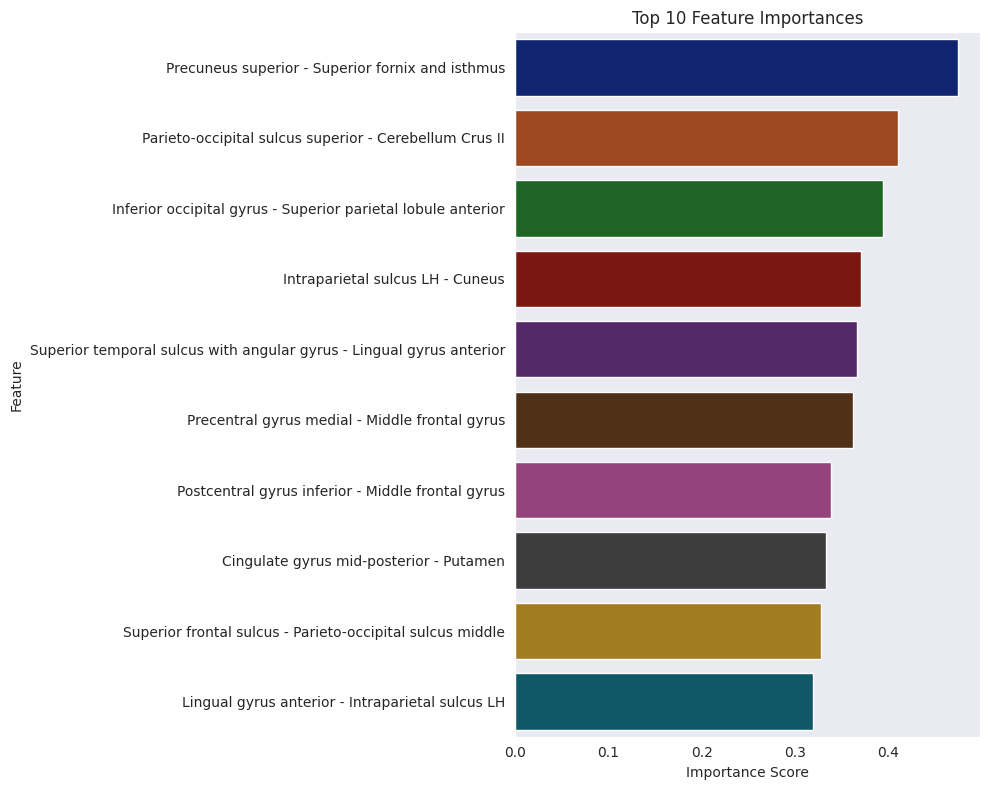

In [40]:
# Plot top 10 feature importances
top_10_feature_importances = importance_df.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_feature_importances)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [41]:
importance_df.head(5)

,Feature,Importance
0,Precuneus superior - Superior fornix and isthmus,0.474181
1,Parieto-occipital sulcus superior - Cerebellum...,0.410588
2,Inferior occipital gyrus - Superior parietal l...,0.394484
3,Intraparietal sulcus LH - Cuneus,0.370234
4,Superior temporal sulcus with angular gyrus - ...,0.365849


In [43]:
# Feature Importance Visuals

difumo_labels = difumo.labels

roi_names = 'Precuneus superior|Superior fornix and isthmus' 

ft_link = difumo_labels[difumo_labels['difumo_names'].str.contains(roi_names, case=False)]

roi_index = ft_link.index.tolist()

ft_link['difumo_names']

17             Precuneus superior
21    Superior fornix and isthmus
Name: difumo_names, dtype: object

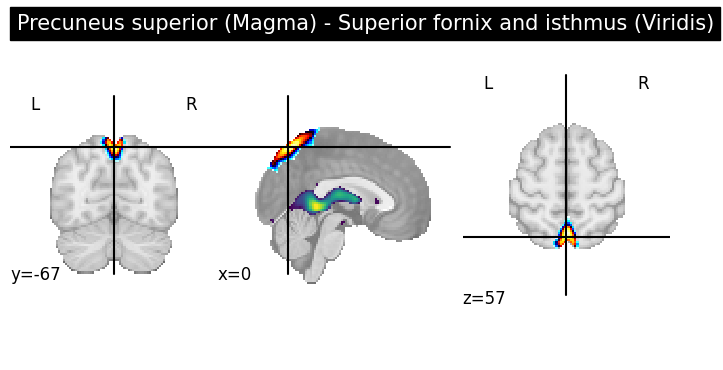

In [44]:
from nilearn import image

# First plot the map for the Region of Interest: index (i) in the atlas
display = plotting.plot_stat_map(
    image.index_img(atlas_filename, 17),
    colorbar=False,
    title='Precuneus superior (Magma) - Superior fornix and isthmus (Viridis)',
)

cmaps = [
    plotting.cm.black_red,
    plotting.cm.black_green,
    plotting.cm.black_pink,
]

for index, cmap in zip([21], cmaps ):
    display.add_overlay(image.index_img(atlas_filename, index), cmap='viridis')

plotting.show()

### Visualize Regions of Interest

In [45]:
difumo_labels = difumo.labels
marker_labels = difumo_labels['difumo_names'].tolist() 

# grab center coordinates for probabilistic atlas
coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps)

In [46]:
# Functions

def transform_df(df):
    """
    Transform the DataFrame by splitting the 'Feature Name' column into 'Marker1' and 'Marker2',
    dropping the original 'Feature Name' column, renaming 'Importance Score' to 'Correlation',
    and returning the transformed DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with columns 'Feature Index', 'Feature Name', and 'Importance Score'.
    
    Returns:
    pd.DataFrame: The transformed DataFrame with columns 'Feature Index', 'Marker1', 'Marker2', and 'Correlation'.
    """
    
    # Ensure 'Feature Name' column exists
    if 'Feature' not in df.columns or 'Importance' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Feature Name' and 'Importance Score' columns.")
    
    # Split `Feature Name` into `Marker1` and `Marker2`
    df[['Marker1', 'Marker2']] = df['Feature'].str.split(' - ', n=1, expand=True)
    
    # Drop the 'Feature Name' column
    df = df.drop(columns=['Feature'])
    
    
    return df



def visualize_connectome(df_sorted, coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired'):
    # Ensure marker_labels is a list
    if isinstance(marker_labels, pd.Index):
        marker_labels = marker_labels.tolist()

    # Extract unique markers from the top rows
    unique_markers = pd.unique(df_sorted[['Marker1', 'Marker2']].values.ravel('K'))

    # Filter marker labels and coordinates to only include those in unique_markers
    filtered_indices = [i for i, label in enumerate(marker_labels) if label in unique_markers]
    filtered_coords = coords[filtered_indices]
    filtered_labels = [marker_labels[i] for i in filtered_indices]

    # Normalize correlations for color mapping
    norm = colors.Normalize(vmin=df_sorted['Importance'].min(), vmax=df_sorted['Importance'].max())
    cmap_markers = colormaps.get_cmap(cmap_markers)
    cmap_edges = colormaps.get_cmap(cmap_edges)

    # Create a Plotly figure
    fig = go.Figure()

    # Add nodes to the plot
    fig.add_trace(go.Scatter3d(
        x=filtered_coords[:, 0],
        y=filtered_coords[:, 1],
        z=filtered_coords[:, 2],
        mode='markers+text',
        marker=dict(size=8, color=[colors.to_hex(cmap_markers(norm(c))) for c in df_sorted['Importance']]),  # Use cmap for node colors
        text=filtered_labels,
        textfont=dict(color='white', size=13, family="Arial"),  # Larger font size
        textposition='middle right',  # Position labels on the right
        name='Markers'
    ))

    # Add edges to the plot
    for i, row in df_sorted.iterrows():
        marker1 = row['Marker1']
        marker2 = row['Marker2']
        correlation = row['Importance']

        marker1_idx = filtered_labels.index(marker1)
        marker2_idx = filtered_labels.index(marker2)

        fig.add_trace(go.Scatter3d(
            x=[filtered_coords[marker1_idx, 0], filtered_coords[marker2_idx, 0]],
            y=[filtered_coords[marker1_idx, 1], filtered_coords[marker2_idx, 1]],
            z=[filtered_coords[marker1_idx, 2], filtered_coords[marker2_idx, 2]],
            mode='lines',
            line=dict(color=colors.to_hex(cmap_edges(norm(correlation))), width=3),  # Use cmap for edge colors
            name=f"{marker1} - {marker2} ({correlation:.2f})"
        ))

    # Update layout
    fig.update_layout(
        title=dict(
            text='',
            x=0.5,  # Center the title
            y=0.95,  # Move the title slightly up to avoid overlap
            font=dict(size=26, color='white', family="Arial")
        ),
        paper_bgcolor='black',  # Black background for the entire figure
        plot_bgcolor='black',   # Black background for the plot area
        scene=dict(
            xaxis=dict(
                title=dict(text='X', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',  # White axis lines
                showticklabels=False,
                zeroline=False
            ),
            yaxis=dict(
                title=dict(text='Y', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',
                showticklabels=False,
                zeroline=False
            ),
            zaxis=dict(
                title=dict(text='Z', font=dict(size=18, color='white')),
                showbackground=False,
                showgrid=True,
                gridcolor='rgba(50, 50, 50, 0.5)',  # Dark gray gridlines
                showline=True,
                linecolor='white',
                showticklabels=False,
                zeroline=False
            )
        ),
        margin=dict(
            l=20,  # Adjusted margins for better spacing
            r=20,
            b=20,
            t=20
        ),
        width=600,  # Width of the plot
        height=400,  # Height of the plot
        showlegend=True,
        legend=dict(
            x=0.0,  # Center the title
            y=-0.2,  # Move the title slightly up to avoid overlap
            font=dict(size=10, color='white', family="Arial"),  # White font for the legend
            bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the legend
        )
    )
    
    if fig:
        fig.write_html('connectome_plot.html')
        print("Plot successfully saved as 'connectome_plot.html'")
    else:
        print("No figure returned.")

    # Show the plot
    fig.show()

In [47]:
marker_corr = transform_df(importance_df)
marker_corr

,Importance,Marker1,Marker2
0,0.474181,Precuneus superior,Superior fornix and isthmus
1,0.410588,Parieto-occipital sulcus superior,Cerebellum Crus II
2,0.394484,Inferior occipital gyrus,Superior parietal lobule anterior
3,0.370234,Intraparietal sulcus LH,Cuneus
4,0.365849,Superior temporal sulcus with angular gyrus,Lingual gyrus anterior
...,...,...,...
2011,-0.216436,Lingual gyrus anterior,Caudate
2012,-0.237593,Superior frontal sulcus,Lateral occipital cortex
2013,-0.241752,Inferior occipital gyrus,Calcarine sulcus anterior
2014,-0.252339,Angular gyrus superior,Intraparietal sulcus LH


In [50]:
visualize_connectome(marker_corr.head(4), coords, marker_labels, cmap_markers='Paired', cmap_edges='cool')

Plot successfully saved as 'connectome_plot.html'
